In [1]:
# Library Imports 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import my_functions as mf
from scipy.optimize import curve_fit
from scipy.fftpack import fft, ifft, fftfreq
from scipy.special import voigt_profile
from scipy.signal import convolve
import re
import importlib
importlib.reload(mf)
from collections import defaultdict

In [3]:
data_path = "data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/"
figure_save_path="/Users/fergusayton/Documents/My Library/fayt3249/2024/Honours Thesis/Thesis Figures and Diagrams/Figures/MyResults"
data_file = "data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 20-02-00_freq_195.11847_rng_36.6852_gain_30_fld_0.09069666666666668.csv"


## Functions ## 

In [2]:
def read_B_field(file_name):
    match = re.search(r'fld_([0-9.]+)', file_name)
    if match: 
        
        b_field = float(match.group(1).strip("."))
        return b_field
    else: 
        print("Error: field value not found in filename.")



def normalise_traces(traces, floors = None, flip = False):
    '''
    Normalisation function for traces. Normalised between a provided floor for *each* trace
    (or zero) and the maximum of each array OR between zero and the maximum, if no floors provided.

    If flip is true, then subtracts 1 at the end and flips, so it's an upwards peak (for peak fitting convenience).

    Inputs:
        traces: enumerable of individual np.arrays. Typically a tuple. 
        floors = None: enumerable of detector floors/blanks the gain setting used to take data. This value will be subtracted before normalisation. 
        flip = False: if true, make the background 0 and flip the peaks so that they go upwards (rather than down from 1). 
    
    Returns:
        cal_traces: tuple of individual np.arrays.
    '''
    
    # If no floors provided, make them all zero
    if not floors:
        floors = np.zeros(len(traces))
    # Do the thing
    if flip: # if flip true then flip it
        cal_traces = tuple( 
            -1*((trace - floors[i]) / (np.max(trace) - floors[i]) - 1) for i, trace in enumerate(traces)
        )
    else: # otherwise don't flip it
        cal_traces = tuple( 
            (trace - floors[i]) / (np.max(trace) - floors[i]) for i, trace in enumerate(traces)
        )
    
    return cal_traces

    

## Single Spectrum ## 

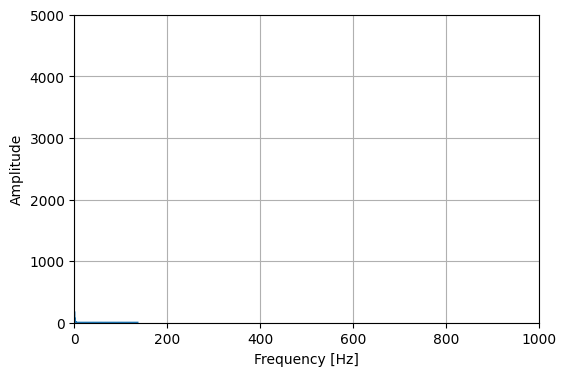

<Figure size 640x480 with 0 Axes>

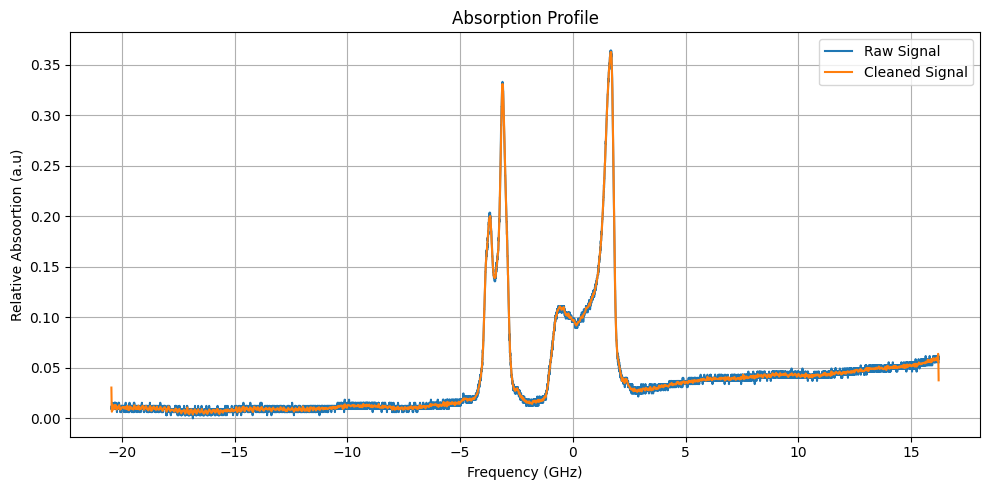

In [4]:

# Step 1: read CSV
data = pd.read_csv(data_file, header=None)

# Extract time, signal, and frequency
time_axis = data.iloc[0].values.astype(float)
voltage = data.iloc[1].values.astype(float)
freq_axis = data.iloc[2].values.astype(float)

# Normalise and Flip absorotion 
# signal = -voltage
# signal = mf.normalise_0_1(signal)


voltage_traces = (voltage,)  # tuple of a single 1D array
floors = (-0.03080024083683403,)

# Apply normalization (flip=True if you want dips → peaks)
normalized_traces = mf.normalise_traces(voltage_traces, floors=floors, flip=True)
signal =normalized_traces[0]

# Convert frequency from Hz to GHz for cleaner axis
freq_axis_GHz = freq_axis / 1e9
## Low Pass Band Filter ## 20 Hz. 
cleaned = mf.low_pass_band_filter_fft(20,freq_axis_GHz,signal,plot_check=True)

# Plot absorption profile
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(freq_axis_GHz, signal, label='Raw Signal')
ax.plot(freq_axis_GHz, cleaned, label='Cleaned Signal')
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Relative Absoortion (a.u)")
ax.set_title("Absorption Profile")
ax.grid(True)
ax.legend()
fig.tight_layout()
plt.show()



## 2D Colour Map ## 

In [59]:
data_files =  sorted(glob.glob(data_path +"*"))

voltages = [] 
fields = [] 

for file in data_files: 
    # Step 1: read CSV
    data = pd.read_csv(file, header=None)
    # Extract time, signal, and frequency
    time_axis = data.iloc[0].values.astype(float)
    voltage = data.iloc[1].values.astype(float)
    freq_axis = data.iloc[2].values.astype(float)

    #voltage = mf.low_pass_band_filter_fft(20,freq_axis_GHz,voltage,plot_check=False)

    # Convert frequency from Hz to GHz for cleaner axis
    freq_axis_GHz = freq_axis / 1e9

    B_field = read_B_field(file_name=file)
    fields.append(B_field)
    voltages.append(voltage)

fields = np.array(fields)
voltages = np.array(voltages)

# Sort by magnetic fieldusing arg sort
sort_idx = np.argsort(fields)
fields = fields[sort_idx]
voltages = voltages[sort_idx]


In [60]:
## Shift Frequency and  Normalise Volatage ## 
freq_shift = -0.675555 # GHz
freq_axis_GHz_shifted= freq_axis_GHz-freq_shift

signals = -voltages
signals = mf.normalise_0_1(signals)

    # Convert voltages list to tuple of 1D arrays
voltage_traces = tuple(voltages)

# Optional: detector floors (if known), otherwise will default to 0
# Example: floors = np.array([np.min(v) for v in voltage_traces])
floors =tuple(-0.0035351922089636857*np.ones(len(voltage_traces))) # or: floors = np.array([0.0]*len(voltage_traces))

# Apply normalization (flip=True if you want dips → peaks)
normalized_traces = normalise_traces(voltage_traces, floors=floors, flip=True)
signals = np.array(normalized_traces)

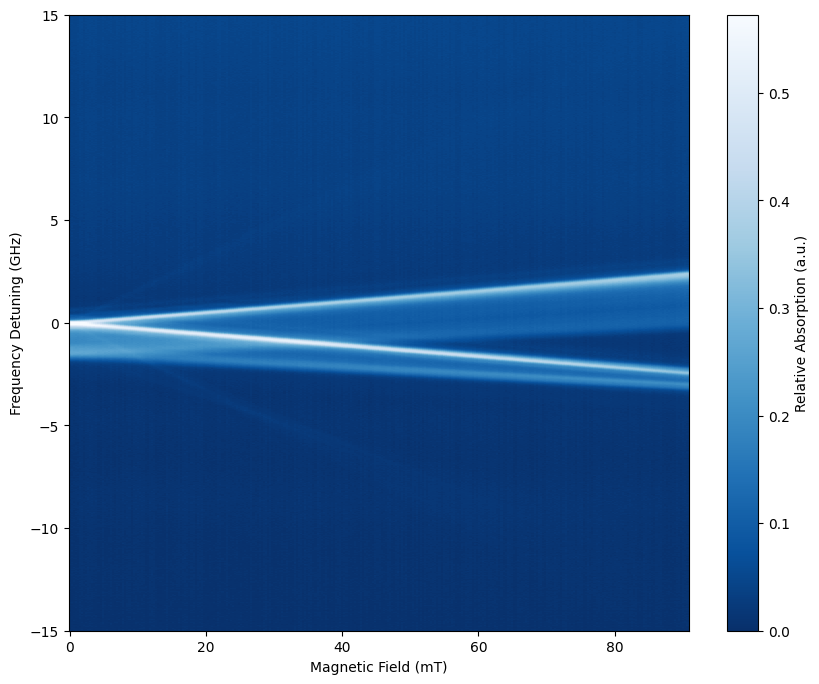

In [7]:
fig, ax = plt.subplots(figsize=(10,8))
#c= ax.pcolormesh(freq_axis_GHz, fields * 1000, voltages, shading='auto', cmap='Blues')
c=ax.pcolormesh(fields * 1000, freq_axis_GHz_shifted, signals.T, shading='auto', cmap='Blues_r')  # Alternative plot
ax.set_ylim([-15, 15])
#ax.set_ylim([80, 90])  # Uncomment and set limits if needed
cbar = fig.colorbar(c, ax=ax, label="Relative Absorption (a.u.)")
ax.set_xlabel("Magnetic Field (mT)")
ax.set_ylabel("Frequency Detuning (GHz)")
plt.show()


In [ ]:

mf.apply_fig_style(fig,ax,style="large", colorbar=cbar)
mf.save_figure(fig,"25_03_2025_IH_abosorption_site1",folder=figure_save_path,dpi=1200)
fig

## Linear Fitting and Graphing Peak Picking ## 

In [35]:
import pandas as pd
import numpy as np

# Paths to the peak data
peak_paths = {
    "A": "data_optics/peak_picking_data_2/2025_04_18_11_27_01_absorption_peaks_2025-03-25_site1_A.csv",
    "B": "data_optics/peak_picking_data_2/2025_04_18_11_38_46_absorption_peaks_2025-03-25_site1_B.csv",
    "C": "data_optics/peak_picking_data_2/2025_04_18_11_47_49_absorption_peaks_2025-03-25_site1_C.csv",
    "D": "data_optics/peak_picking_data_2/2025_04_18_11_56_05_absorption_peaks_2025-03-25_site1_D.csv",
    "E": "data_optics/peak_picking_data_2/2025_04_18_12_00_28_absorption_peaks_2025-03-25_site1_E.csv",
    "F": "data_optics/peak_picking_data_2/2025_04_18_12_03_43_absorption_peaks_2025-03-25_site1_F.csv"
}

peak_data = {}
slopes = {}
extrap_fields=np.arange(0, int(100),step=1)

# Load each peak data into a dictionary and calculate the slope and R^2
for peak, path in peak_paths.items():
    data = pd.read_csv(path)
    data = data.dropna() 
    freq = data['Frequency (GHz)'].values - freq_shift
    #print(freq)
    b_field = data['B Field (mT)'].values

    # Linear fit
    fit, cov = np.polyfit(b_field, freq, 1, cov=True)
    slope = fit[0]
    intercept = fit[1]
    slope_err = np.sqrt(cov[0, 0])  # standard error of slope
    intercept_err = np.sqrt(cov[1, 1])
    # Create the polynomial function for the fit
    poly = np.poly1d(fit)

    start_freq=poly(0)
    end_freq =poly(extrap_fields[-1])
    delta_f = np.abs(end_freq-start_freq)
    
    # Extrapolate the fit over the entire range of the predefined fields array
    extrapolated_fit = poly(extrap_fields)

    # Calculate fitted values for the original data
    fitted_values = poly(b_field)

    # Calculate R^2
    ss_res = np.sum((freq - fitted_values) ** 2)
    ss_tot = np.sum((freq - np.mean(freq)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    slopes[peak] = (slope, intercept, slope_err, intercept_err, r_squared)
    # Store the data and fit line
    peak_data[peak] = {
        "freq": freq,
        "b_field": b_field,
        "slope": slope,
        "r_squared": r_squared,
        "fit_line": fitted_values,
        "intercept": intercept,
        "extrapolated_fit": extrapolated_fit
    }
        # Store extended data
    peak_data[peak].update({
        "slope_err": slope_err,
        "intercept_err": intercept_err,
    })
    print(f"Slope of Peak {peak}: {slope:.6f} ± {slope_err:.6f} GHz/mT, R²: {r_squared:.6f}")
    print(f"Slope of Peak {peak}: {slope:.6f} GHz/mT, R²: {r_squared:.6f}, Intercept: {intercept:.6f}")
    print("Start Frequency=, " ,start_freq, "GHz")
    print("End Frequency=, " ,end_freq, "GHz")
    print("Delta F = ", delta_f, "GHz")
    print("\n")


Slope of Peak A: -0.026402 ± 0.000127 GHz/mT, R²: 0.998655
Slope of Peak A: -0.026402 GHz/mT, R²: 0.998655, Intercept: -0.750708
Start Frequency=,  -0.7507077814753231 GHz
End Frequency=,  -3.3644809197930927 GHz
Delta F =  2.61377313831777 GHz


Slope of Peak B: 0.026524 ± 0.000153 GHz/mT, R²: 0.998075
Slope of Peak B: 0.026524 GHz/mT, R²: 0.998075, Intercept: -0.755351
Start Frequency=,  -0.7553514294166069 GHz
End Frequency=,  1.8704878759213082 GHz
Delta F =  2.625839305337915 GHz


Slope of Peak C: -0.019249 ± 0.000460 GHz/mT, R²: 0.967982
Slope of Peak C: -0.019249 GHz/mT, R²: 0.967982, Intercept: -2.020418
Start Frequency=,  -2.020418025487542 GHz
End Frequency=,  -3.9260680314212477 GHz
Delta F =  1.9056500059337056 GHz


Slope of Peak D: 0.018046 ± 0.000244 GHz/mT, R²: 0.992543
Slope of Peak D: 0.018046 GHz/mT, R²: 0.992543, Intercept: -2.236930
Start Frequency=,  -2.2369297300718873 GHz
End Frequency=,  -0.4503860378606974 GHz
Delta F =  1.78654369221119 GHz


Slope of Peak E

In [37]:
import pandas as pd
import numpy as np

# Paths to the peak data
peak_paths = {
    "A": "data_optics/peak_picking_data_2/2025_04_18_11_27_01_absorption_peaks_2025-03-25_site1_A.csv",
    "B": "data_optics/peak_picking_data_2/2025_04_18_11_38_46_absorption_peaks_2025-03-25_site1_B.csv",
    "C": "data_optics/peak_picking_data_2/2025_04_18_11_47_49_absorption_peaks_2025-03-25_site1_C.csv",
    "D": "data_optics/peak_picking_data_2/2025_04_18_11_56_05_absorption_peaks_2025-03-25_site1_D.csv",
    "E": "data_optics/peak_picking_data_2/2025_04_18_12_00_28_absorption_peaks_2025-03-25_site1_E.csv",
    "F": "data_optics/peak_picking_data_2/2025_04_18_12_03_43_absorption_peaks_2025-03-25_site1_F.csv"
}
peak_data = {}
slopes = {}
extrap_fields = np.arange(0, int(100), step=1)  # Adjust fields array as needed

# Load each peak data into a dictionary and calculate the slope and R^2
for peak, path in peak_paths.items():
    data = pd.read_csv(path)
    data = data.dropna()

    # Extract data columns based on the new structure
    freq = data['Frequency (GHz)'].values
    signal = data['Signal'].values  # Signal data (can be used for normalization or analysis)
    linewidth = data['Linewidth (GHz)'].values  # Linewidth data (for further analysis or display)
    scale = data['Scale'].values  # Scale data (if needed for processing or fitting)
    b_field = data['B Field (mT)'].values  # Magnetic field values

    # Linear fit
    fit, cov = np.polyfit(b_field, freq, 1, cov=True)
    slope = fit[0]
    intercept = fit[1]
    slope_err = np.sqrt(cov[0, 0])  # standard error of slope
    intercept_err = np.sqrt(cov[1, 1])

    # Create the polynomial function for the fit
    poly = np.poly1d(fit)

    # Extrapolate the frequency values
    start_freq = poly(0)
    end_freq = poly(extrap_fields[-1])
    delta_f = np.abs(end_freq - start_freq)

    # Extrapolate the fit over the entire range of the predefined fields array
    extrapolated_fit = poly(extrap_fields)

    # Calculate fitted values for the original data
    fitted_values = poly(b_field)

    # Calculate R^2
    ss_res = np.sum((freq - fitted_values) ** 2)
    ss_tot = np.sum((freq - np.mean(freq)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    # Store the slope, intercept, and R^2 for each peak
    slopes[peak] = (slope, intercept, slope_err, intercept_err, r_squared)

    # Store the data, fit line, and other relevant information in the peak_data dictionary
    peak_data[peak] = {
        "freq": freq,
        "signal": signal,
        "linewidth": linewidth,
        "scale": scale,
        "b_field": b_field,
        "slope": slope,
        "intercept": intercept,
        "r_squared": r_squared,
        "fit_line": fitted_values,
        "extrapolated_fit": extrapolated_fit
    }

    # Store extended data such as the errors
    peak_data[peak].update({
        "slope_err": slope_err,
        "intercept_err": intercept_err,
        "start_freq": start_freq,
        "end_freq": end_freq,
        "delta_f": delta_f
    })

    # Print out the results for each peak
    print(f"Slope of Peak {peak}: {slope:.6f} ± {slope_err:.6f} GHz/mT, R²: {r_squared:.6f}")
    print(f"Slope of Peak {peak}: {slope:.6f} GHz/mT, R²: {r_squared:.6f}, Intercept: {intercept:.6f}")
    print("Start Frequency= ", start_freq, "GHz")
    print("End Frequency= ", end_freq, "GHz")
    print("Delta F = ", delta_f, "GHz")
    print("\n")


Slope of Peak A: -0.026402 ± 0.000127 GHz/mT, R²: 0.998655
Slope of Peak A: -0.026402 GHz/mT, R²: 0.998655, Intercept: -0.750708
Start Frequency=  -0.7507077814753231 GHz
End Frequency=  -3.3644809197930927 GHz
Delta F =  2.61377313831777 GHz


Slope of Peak B: 0.026524 ± 0.000153 GHz/mT, R²: 0.998075
Slope of Peak B: 0.026524 GHz/mT, R²: 0.998075, Intercept: -0.755351
Start Frequency=  -0.7553514294166069 GHz
End Frequency=  1.8704878759213082 GHz
Delta F =  2.625839305337915 GHz


Slope of Peak C: -0.019249 ± 0.000460 GHz/mT, R²: 0.967982
Slope of Peak C: -0.019249 GHz/mT, R²: 0.967982, Intercept: -2.020418
Start Frequency=  -2.020418025487542 GHz
End Frequency=  -3.9260680314212477 GHz
Delta F =  1.9056500059337056 GHz


Slope of Peak D: 0.018046 ± 0.000244 GHz/mT, R²: 0.992543
Slope of Peak D: 0.018046 GHz/mT, R²: 0.992543, Intercept: -2.236930
Start Frequency=  -2.2369297300718873 GHz
End Frequency=  -0.4503860378606974 GHz
Delta F =  1.78654369221119 GHz


Slope of Peak E: -0.134

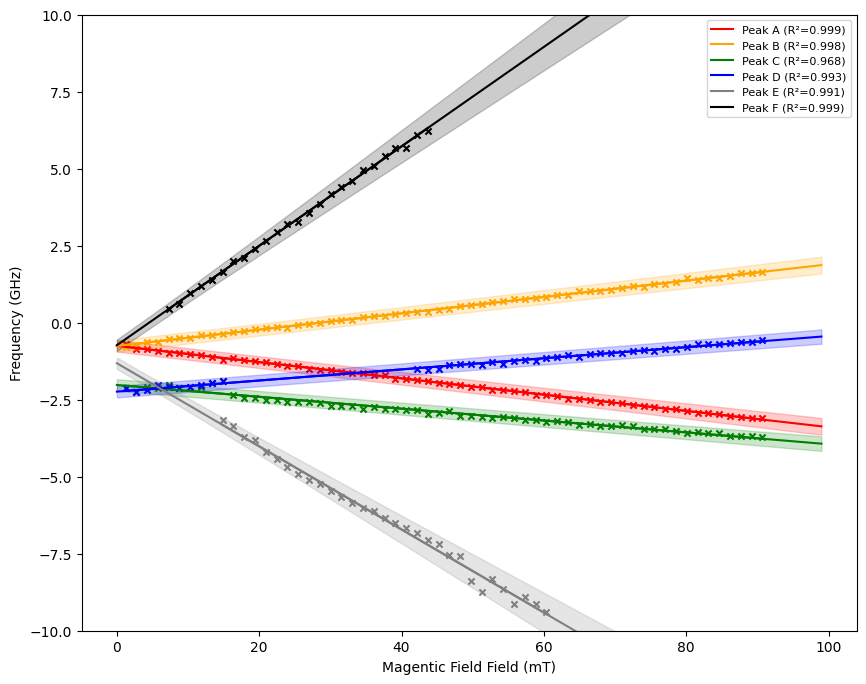

In [38]:
# Plot the data and linear fits
fig2, ax2 = plt.subplots(figsize=(10, 8))
#c = ax2.pcolormesh(fields * 1000,freq_axis_GHz, voltages.T, shading='auto', cmap='Blues')
# Plot the scatter points, linear fits, and extrapolated fits for each peak

uncert_f = 0.1875 #GHz
uncert_B_pct = 0.272/3.57220371#0.45 #%
colors = ['red', 'orange', 'green', 'blue', 'grey', 'k']
for i, (peak, data) in enumerate(peak_data.items()):
    freq_err = np.full_like(data['freq'], uncert_f)
    b_field = data['b_field']
    b_err = b_field * uncert_B_pct

    #ax2.errorbar(data['b_field'], data['freq'],xerr=b_err, yerr=freq_err,fmt=".",color=colors[i])#label=f"Peak {peak}"
    # Scatter plot of the original data points
    ax2.scatter(data['b_field'], data['freq'], color=colors[i], marker='x', s=20) #label=f"Peak {peak}"

    # Plot the fitted line within the original data range
    ax2.plot(data['b_field'], data['fit_line'], color=colors[i], label=f"Peak {peak} (R²={data['r_squared']:.3f})") # label=f"Fit {peak} (R²={data['r_squared']:.3f})"

    # Plot the extrapolated fit over the entire fields range
    ax2.plot(extrap_fields, data['extrapolated_fit'], color=colors[i])

        # Plot the extrapolated fit over the entire fields range
    #ax2.plot(extrap_fields, data['extrapolated_fit'], color=colors[i], linestyle='-')

    # --- Add shaded error region ---
    # Compute upper and lower bounds based on slope uncertainty
    slope = data['slope']
    intercept = data['intercept']
    slope_err = slopes[peak][0] * 0  # default fallback if not set
    if len(slopes[peak]) >= 4:
        slope_err = slopes[peak][2]  # slope_err is third if updated slopes[peak] has full info

    # Linear extrapolation with slope ± error
    # fit_upper = (slope + slope_err) * extrap_fields + intercept
    # fit_lower = (slope - slope_err) * extrap_fields + intercept

    # Total uncertainty in predicted frequency at each extrapolated B
    b_err_extrap = extrap_fields * uncert_B_pct  # extrapolated B uncertainty
    fit_center = slope * extrap_fields + intercept
    fit_err_band = np.sqrt((slope * b_err_extrap)**2 + uncert_f**2)

    fit_upper = fit_center + fit_err_band
    fit_lower = fit_center - fit_err_band

    peak_data[peak].update({
    "fit_upper": fit_upper,
    "fit_lower": fit_lower
    })

    # Shaded region between upper and lower
    ax2.fill_between(extrap_fields, fit_lower, fit_upper, color=colors[i], alpha=0.2)

# Add labels and legend
#fig2.colorbar(c, ax=ax2, label="Voltage")
ax2.set_ylim([-10,10])
ax2.set_xlabel("Magentic Field Field (mT)")
ax2.set_ylabel("Frequency (GHz)")
ax2.legend(fontsize=8)

In [34]:
print(extrap_fields)

[0 1 2 3 4 5 6]


In [ ]:
mf.apply_fig_style(fig2,ax2,style="large", line_size=0.8,marker_size=0.1)
mf.save_figure(fig2,"25_03_2025_IH_abosorption_site1_fitted_err2",folder=figure_save_path,dpi=1200)
fig2

Slope of deltaE = F-A_ground_o: 0.187802 GHz/mT, Intercept: 0.020892
Slope of deltaE = B-E_ground_o: 0.161479 GHz/mT, Intercept: 0.559390
Slope of deltaE = A-E_excited_o: 0.108553 GHz/mT, Intercept: 0.564034
Slope of deltaE = F-B_excited_o: 0.134876 GHz/mT, Intercept: 0.025536


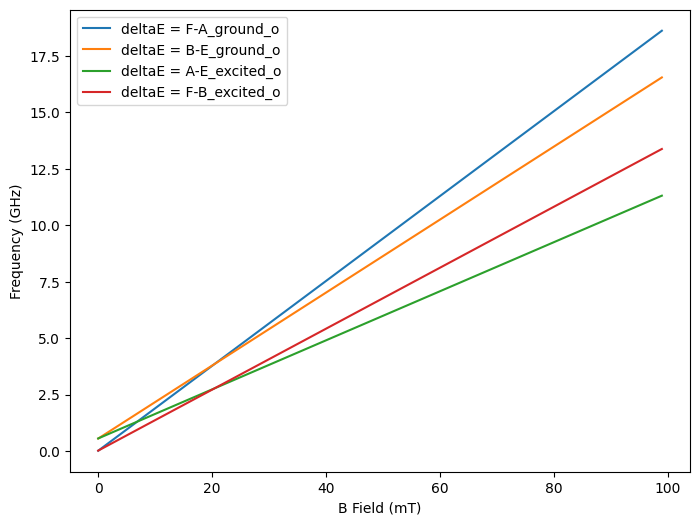

In [39]:
fig3, ax3 = plt.subplots(figsize=(8, 6))

# Get the extrapolated fit lines from the peak data
e2e_line = np.array(peak_data["A"]["extrapolated_fit"])
g2e_line = np.array(peak_data["F"]["extrapolated_fit"])
e2g_line = np.array(peak_data["E"]["extrapolated_fit"])
g2g_line = np.array(peak_data["B"]["extrapolated_fit"])

# Calculate the difference between lines
delta_E_abs_F_A = g2e_line - e2e_line
delta_E_abs_B_E = g2g_line - e2g_line
delta_E_abs_A_E = e2e_line - e2g_line
delta_E_abs_F_B = g2e_line - g2g_line

# Define a function to calculate the slope and plot the fitted line
def calculate_slope(x, y, label, units="GHz/mT"):
    # Perform linear fit
    fit = np.polyfit(x, y, 1)  # Degree 1 for linear fit
    slope, intercept = fit
    print(f"Slope of {label}: {slope:.6f} {units}, Intercept: {intercept:.6f}")
    
    # Plot the fitted line
    y_fit = np.poly1d(fit)(x)
   #ax3.plot(x, y_fit, linestyle='--', label=f"Fit {label} (Slope={slope:.3f})")
    return slope, intercept

# Plot the delta E lines
ax3.plot(extrap_fields, delta_E_abs_F_A, label="deltaE = F-A_ground_o")
ax3.plot(extrap_fields, delta_E_abs_B_E, label="deltaE = B-E_ground_o")
ax3.plot(extrap_fields, delta_E_abs_A_E, label="deltaE = A-E_excited_o")
ax3.plot(extrap_fields, delta_E_abs_F_B, label="deltaE = F-B_excited_o")

# Calculate slopes and plot fitted lines
slope_F_A, _ = calculate_slope(extrap_fields, delta_E_abs_F_A, "deltaE = F-A_ground_o")
slope_B_E, _ = calculate_slope(extrap_fields, delta_E_abs_B_E, "deltaE = B-E_ground_o")
slope_A_E, _ = calculate_slope(extrap_fields, delta_E_abs_A_E, "deltaE = A-E_excited_o")
slope_F_B, _ = calculate_slope(extrap_fields, delta_E_abs_F_B, "deltaE = F-B_excited_o")

# Plot settings
ax3.set_xlabel("B Field (mT)")
ax3.set_ylabel("Frequency (GHz)")
ax3.legend()
plt.show()


## G Tensor Calculations ## 

In [40]:
muB = 9.27400968e-24 #Bohr Magneton (J/T)
muN = 5.05078375e-27 #Nuclear Magneton (J/T)
hbar = 	1.054571817E-34 #Reduced planck constant (Js)
h = 2*np.pi*hbar #Planck constant (Js)
g_eff_F_A_ground_o = (h/muB)*slope_F_A*(10**9)/(10**(-3))
g_eff_B_E_ground_o = (h/muB)*slope_B_E*(10**9)/(10**(-3))
g_eff_F_A_excited_o =(h/muB)* slope_A_E*(10**9)/(10**(-3))
g_eff_A_E_excited_o = (h/muB)*slope_F_B*(10**9)/(10**(-3))

print("g_eff_F_A_ground_o = ",g_eff_F_A_ground_o )
print("g_eff_B_E_ground_o= ",g_eff_B_E_ground_o )
print("Average_Ground_o_ =", np.average([g_eff_F_A_ground_o,g_eff_B_E_ground_o]))
print("g_eff_F_A_excited_o = ",g_eff_F_A_excited_o )
print("g_eff_A_E_excited_o = ",g_eff_A_E_excited_o )
print("Average_Ground_o_ =", np.average([g_eff_F_A_excited_o,g_eff_A_E_excited_o]))

#  Can I calculate full g tensor ? 

g_eff_F_A_ground_o =  13.418003649312674
g_eff_B_E_ground_o=  11.537279897045112
Average_Ground_o_ = 12.477641773178892
g_eff_F_A_excited_o =  7.75588133613905
g_eff_A_E_excited_o =  9.636605088406613
Average_Ground_o_ = 8.696243212272831


## G TENSORS WITH UNCERT ## 

In [41]:
# ---- Compute g_eff from extrapolated slopes (including slope uncertainty from fill_between) ----

def get_delta_slope_and_error(peak1, peak2, label):
    y = np.array(peak_data[peak1]["extrapolated_fit"]) - np.array(peak_data[peak2]["extrapolated_fit"])
    y_upper = np.array(peak_data[peak1]["fit_upper"]) - np.array(peak_data[peak2]["fit_lower"])
    y_lower = np.array(peak_data[peak1]["fit_lower"]) - np.array(peak_data[peak2]["fit_upper"])

    m = np.polyfit(extrap_fields, y, 1)[0]
    m_upper = np.polyfit(extrap_fields, y_upper, 1)[0]
    m_lower = np.polyfit(extrap_fields, y_lower, 1)[0]
    m_err = np.abs(m_upper - m_lower) / 2

    print(f"{label}: slope = {m:.6f} ± {m_err:.6f} GHz/mT")
    return m, m_err


# Run this for each deltaE line
slope_F_A, slope_F_A_err = get_delta_slope_and_error("F", "A", "deltaE = F-A_ground_o")
slope_B_E, slope_B_E_err = get_delta_slope_and_error("B", "E", "deltaE = B-E_ground_o")
slope_A_E, slope_A_E_err = get_delta_slope_and_error("A", "E", "deltaE = A-E_excited_o")
slope_F_B, slope_F_B_err = get_delta_slope_and_error("F", "B", "deltaE = F-B_excited_o")


# ---- Physical constants ----
muB = 9.27400968e-24  # Bohr Magneton (J/T)
hbar = 1.054571817E-34  # Reduced Planck constant (Js)
h = 2 * np.pi * hbar
scale = (h / muB) * 1e9 / 1e-3  # Converts GHz/mT to unitless g_eff

# ---- Convert slopes to g_eff with uncertainty ----
g_eff_F_A = slope_F_A * scale
g_eff_F_A_err = slope_F_A_err * scale

g_eff_B_E = slope_B_E * scale
g_eff_B_E_err = slope_B_E_err * scale

g_eff_A_E = slope_A_E * scale
g_eff_A_E_err = slope_A_E_err * scale

g_eff_F_B = slope_F_B * scale
g_eff_F_B_err = slope_F_B_err * scale

# ---- Averages with propagated error ----
avg_ground = np.mean([g_eff_F_A, g_eff_B_E])
avg_ground_err = np.sqrt(g_eff_F_A_err**2 + g_eff_B_E_err**2) / 2

avg_excited = np.mean([g_eff_A_E, g_eff_F_B])
avg_excited_err = np.sqrt(g_eff_A_E_err**2 + g_eff_F_B_err**2) / 2

# ---- Output ----
print("\n---- g_eff Results ----")
print(f"g_eff_F_A_ground_o     = {g_eff_F_A:.3f} ± {g_eff_F_A_err:.3f}")
print(f"g_eff_B_E_ground_o     = {g_eff_B_E:.3f} ± {g_eff_B_E_err:.3f}")
print(f"Average Ground g_eff   = {avg_ground:.3f} ± {avg_ground_err:.3f}")
print("")
print(f"g_eff_A_E_excited_o    = {g_eff_A_E:.3f} ± {g_eff_A_E_err:.3f}")
print(f"g_eff_F_B_excited_o    = {g_eff_F_B:.3f} ± {g_eff_F_B_err:.3f}")
print(f"Average Excited g_eff  = {avg_excited:.3f} ± {avg_excited_err:.3f}")


deltaE = F-A_ground_o: slope = 0.187802 ± 0.012063 GHz/mT
deltaE = B-E_ground_o: slope = 0.161479 ± 0.009992 GHz/mT
deltaE = A-E_excited_o: slope = 0.108553 ± 0.009985 GHz/mT
deltaE = F-B_excited_o: slope = 0.134876 ± 0.012070 GHz/mT

---- g_eff Results ----
g_eff_F_A_ground_o     = 13.418 ± 0.862
g_eff_B_E_ground_o     = 11.537 ± 0.714
Average Ground g_eff   = 12.478 ± 0.560

g_eff_A_E_excited_o    = 7.756 ± 0.713
g_eff_F_B_excited_o    = 9.637 ± 0.862
Average Excited g_eff  = 8.696 ± 0.560


## Global Magnetic Field Inhomogeniety ## 
- The Zero field splitting is characterisitc of strain on the crystal. Meaning that part of the crystal is under a an amount of stress. 
- The gradient of the that absopriton line as compared to the other line should give us an estimate on the magnetic field homoegenity across the crystal if we assume the starin and the unstrained part are at the length of the crystal. This should give use b-axis magnetic field gradient. 

$$\Delta B = B(\frac{m'-m}{m})$$
See notes for derivation.

In [42]:


def calculate_homogeneity_features(target_B_field, slope_strained, slope_unstrained): # Slope GHz/mt
    delta_B = target_B_field*np.abs((slope_strained-slope_unstrained)/slope_unstrained)
    delta_f_strained = slope_strained*delta_B
    delta_f_unstrained = slope_unstrained*delta_B
    return delta_B, np.abs(delta_f_strained), np.abs(delta_f_unstrained) # GHZ and MT

    
target_field = 60 #mt 
## Get Slopes of Lines ## 
print("Peak Pair 1")
print("Slope of Strained A = ", peak_data["A"]["slope"], "GHz/mT")
print("Slope of Unstrained C = ", peak_data["C"]["slope"], "GHz/mT")
print("Slope Difference abs(A-C) =", np.abs(peak_data["A"]["slope"]-peak_data["C"]["slope"]), "GHz/mT")
delta_B_1, delta_f_strained_1, delta_f_unstrained_1 = calculate_homogeneity_features(target_field, peak_data["A"]["slope"],peak_data["C"]["slope"] )
print(f"At B ={target_field}, Field Grad = {delta_B_1} mT, Strained FWHM = {delta_f_strained_1*1000} MHz, Unstrained FWHM = {delta_f_unstrained_1*1000} MHz") 
print("\n")
print("Peak Pair 2")
print("Slope of Strained B = ", peak_data["B"]["slope"], "GHz/mT")
print("Slope of Unstrained D = ", peak_data["D"]["slope"], "GHz/mT")
print("Slope Difference abs(B-D) =", np.abs(peak_data["B"]["slope"]-peak_data["D"]["slope"]), "GHz/mT")
delta_B_2, delta_f_strained_2, delta_f_unstrained_2 = calculate_homogeneity_features(target_field, peak_data["B"]["slope"],peak_data["D"]["slope"])
print(f"At B ={target_field}, Field Grad = {delta_B_2} mT, Strained FWHM = {delta_f_strained_2*1000} MHz, Unstrained FWHM = {delta_f_unstrained_2*1000} MHz ") 

## Average ## 
delta_B_av= np.average([delta_B_1, delta_B_2])
delta_f_strained_av = np.average([delta_f_strained_1, delta_f_strained_2])
delta_f_unstrained_av = np.average([delta_f_unstrained_1, delta_f_unstrained_2])
print("\n")
print("AVERAGE")
print(f"At B = {target_field} mT, Field Grad = {delta_B_av} mT over 5.8mm, Strained FWHM = {delta_f_strained_av*1000} MHz, Unstrained FWHM = {delta_f_unstrained_av*1000} MHz ") 




Peak Pair 1
Slope of Strained A =  -0.026401748871896658 GHz/mT
Slope of Unstrained C =  -0.019248989958926318 GHz/mT
Slope Difference abs(A-C) = 0.00715275891297034 GHz/mT
At B =60, Field Grad = 22.29548333153989 mT, Strained FWHM = 588.6397518968741 MHz, Unstrained FWHM = 429.16553477822043 MHz


Peak Pair 2
Slope of Strained B =  0.026523629346847627 GHz/mT
Slope of Unstrained D =  0.01804589588092111 GHz/mT
Slope Difference abs(B-D) = 0.008477733465926517 GHz/mT
At B =60, Field Grad = 28.187240540015104 mT, Strained FWHM = 747.6279203937978 MHz, Unstrained FWHM = 508.6640079555911 MHz 


AVERAGE
At B = 60 mT, Field Grad = 25.241361935777498 mT over 5.8mm, Strained FWHM = 668.133836145336 MHz, Unstrained FWHM = 468.9147713669057 MHz 


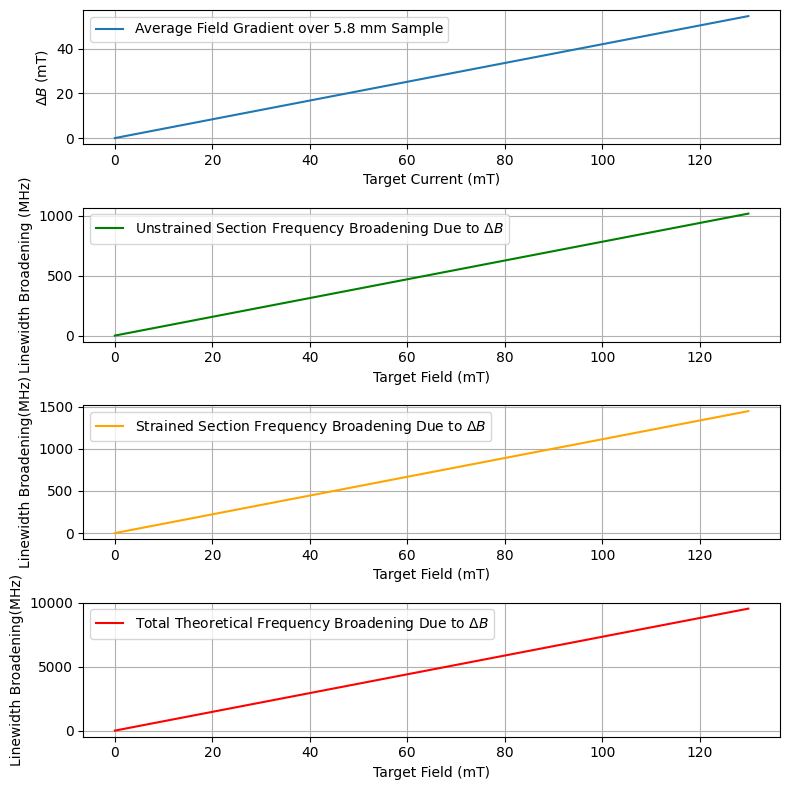

In [43]:
## Plot ## 
target_fields=np.arange(0,140,10)

delta_B_1, delta_f_strained_1, delta_f_unstrained_1 = calculate_homogeneity_features(target_fields, peak_data["A"]["slope"],peak_data["C"]["slope"] )
delta_B_2, delta_f_strained_2, delta_f_unstrained_2 = calculate_homogeneity_features(target_fields, peak_data["B"]["slope"],peak_data["D"]["slope"])
delta_B_av =[]
delta_f_strained_av =[]
delta_f_unstrained_av =[]
delta_f_theoretical =[]
g_estimate = 12.485805793985854
#g_estimate = 4.4

for i in range(0,len(target_fields)): 
    delta_B_av.append(np.average([delta_B_1[i], delta_B_2[i]]))
    delta_f_unstrained_av.append(np.average([delta_f_unstrained_1[i], delta_f_unstrained_2[i]]))
    delta_f_strained_av.append(np.average([delta_f_strained_1[i], delta_f_strained_2[i]]))
    delta_f_theoretical.append((muB/h)*g_estimate*delta_B_av[i]*10**(-3)/(10**9))


delta_f_theoretical= np.array(delta_f_theoretical)
delta_B_av =np.array(delta_B_av)
delta_f_strained_av =np.array(delta_f_strained_av)
delta_f_unstrained_av = np.array(delta_f_unstrained_av)
# delta_B_av= np.average([delta_B_1, delta_B_2])
# delta_f_strained_av = np.average([delta_f_strained_1, delta_f_strained_2])
# delta_f_unstrained_av = np.average([delta_f_unstrained_1, delta_f_unstrained_2])
coil_const_used = 3.57220371 # mT/A
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8,8 )) 
ax1.plot(target_fields, delta_B_av, label="Average Field Gradient over 5.8 mm Sample")
ax1.grid() 
ax1.set_xlabel(r"Target Current (mT)")
#ax1.set_xlabel(r"Target Field (mT)")
ax1.set_ylabel(r"$\Delta B$ (mT)")
ax1.legend()


ax2.plot(target_fields, delta_f_unstrained_av*1000,color ="green", label=r"Unstrained Section Frequency Broadening Due to $\Delta B$")
ax2.grid() 
ax2.set_xlabel(r"Target Field (mT)")
ax2.set_ylabel(r"Linewidth Broadening (MHz)")
ax2.legend()


ax3.plot(target_fields, delta_f_strained_av*1000, color="orange", label=r"Strained Section Frequency Broadening Due to $\Delta B$")
ax3.grid() 
ax3.set_xlabel(r"Target Field (mT)")
ax3.set_ylabel(r"Linewidth Broadening(MHz)")
ax3.legend()

ax4.plot(target_fields, delta_f_theoretical*1000, color="red", label=r"Total Theoretical Frequency Broadening Due to $\Delta B$")
ax4.grid() 
ax4.set_xlabel(r"Target Field (mT)")
ax4.set_ylabel(r"Linewidth Broadening(MHz)")
ax4.legend()
plt.tight_layout()

In [44]:
#Pecentage#
slope, intercept = calculate_slope(target_fields, delta_B_av,"delta B  v amp", units="mT/mT")
print("Field Variation across sample", slope*100, "%")

Slope of delta B  v amp: 0.420689 mT/mT, Intercept: -0.000000
Field Variation across sample 42.06893655962916 %


In [45]:
## COIL CONSTANT ## 
slope, intercept = calculate_slope(target_fields/coil_const_used, delta_B_av,"delta B  v amp", units="mT/A")
print("Max Coil Constant Estimate in Sample =", coil_const_used+slope/2, "mt/A")
print("Min Coil Constant Estimate in Sample =", coil_const_used-slope/2, "mT/A")

print("Coil Constant Field Variation across sample", slope/5.8, "mt/(A mm)")

Slope of delta B  v amp: 1.502788 mT/A, Intercept: -0.000000
Max Coil Constant Estimate in Sample = 4.32359776627031 mt/A
Min Coil Constant Estimate in Sample = 2.8208096537296905 mT/A
Coil Constant Field Variation across sample 0.2591013987138999 mt/(A mm)


In [46]:
def get_field_homogeneity_features(target_field, peak_data, g_estimate=12.485805793985854, muB=9.2740100783e-24, h=6.62607015e-34):
    """
    For a given target magnetic field (in mT), return average ΔB and expected frequency broadenings.
    """
    if not isinstance(target_field, (int, float)):
        raise ValueError("target_field must be a float or int representing field in mT")

    # Run homogeneity calculations for strained/unstrained peak pairs
    delta_B_1, delta_f_strained_1, delta_f_unstrained_1 = calculate_homogeneity_features(target_field, peak_data["A"]["slope"],peak_data["C"]["slope"] )
    delta_B_2, delta_f_strained_2, delta_f_unstrained_2 = calculate_homogeneity_features(target_field, peak_data["B"]["slope"],peak_data["D"]["slope"])

    # Compute averages
    delta_B_av = np.average([delta_B_1, delta_B_2])
    delta_f_strained_av = np.average([delta_f_strained_1, delta_f_strained_2])*1e9
    delta_f_unstrained_av = np.average([delta_f_unstrained_1, delta_f_unstrained_2])*1e9# convert to Hz 

    # Theoretical frequency broadening: Δf = (μB / h) * g * ΔB
    delta_f_theoretical = (muB / h) * g_estimate * delta_B_av * 1e-3  # convert mT → T
    return {
        "delta_B_av (mT)": delta_B_av,
        # "delta_f_unstrained (Hz)": delta_f_unstrained_av,
        # "delta_f_strained (Hz)": delta_f_strained_av,
        "delta_f_theoretical (Hz)": delta_f_theoretical
    }

target_field = 60.03
result = get_field_homogeneity_features(target_field, peak_data,g_estimate=4.4)
for key, val in result.items():
    if 'Hz' in key:
        print(f"{key}: {val/1e6:.3f} MHz")
    else:
        print(f"{key}: {val:.3f}")

delta_B_av (mT): 25.254
delta_f_theoretical (Hz): 1555.228 MHz


## Local Linewidth ##

90.69666666666669

--- Fitting Lorentzians at B = 0.09 mT ---
  Trying A at B = 90.70 mT
    Guess: Gamma=0.3992, x0=-3.1016, scale=0.2073
    Bounds: [[np.float64(0.009757477413644333), np.float64(-2.175885572), np.float64(0.10284701257662432)]], [[np.float64(0.9757477413644332), np.float64(-2.0758855720000002), np.float64(1.2341641509194918)]]
  Trying B at B = 90.70 mT
    Guess: Gamma=0.6209, x0=1.6440, scale=0.3528
    Bounds: [[np.float64(0.003991695305581757), np.float64(-3.1516333129999996), np.float64(0.051821757804679125)]], [[np.float64(0.3991695305581757), np.float64(-3.051633313), np.float64(0.414574062437433)]]
  Trying C at B = 90.70 mT
    Guess: Gamma=0.6653, x0=-3.7226, scale=0.2043
    Bounds: [[np.float64(0.006209303808682769), np.float64(1.5940488836927649), np.float64(0.08819278716641042)]], [[np.float64(0.6209303808682769), np.float64(1.694048883692765), np.float64(0.7055422973312834)]]
  Trying D at B = 90.70 mT
    Guess: Gamma=1.3749, x0=-0.5736, scale=0.2355


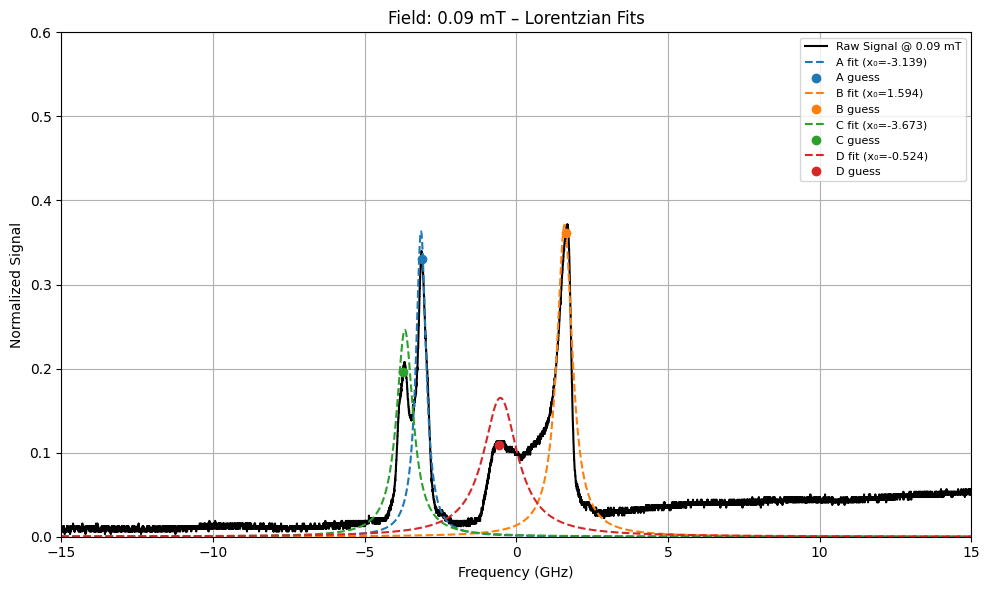

89.18

--- Fitting Lorentzians at B = 0.09 mT ---
  Trying A at B = 89.18 mT
    Guess: Gamma=0.3992, x0=-3.1016, scale=0.2099
    Bounds: [[np.float64(0.013749172719226124), np.float64(-0.623559619), np.float64(0.0588809460891741)]], [[np.float64(1.3749172719226124), np.float64(-0.5235596189999999), np.float64(0.4710475687133928)]]
  Trying B at B = 89.18 mT
    Guess: Gamma=0.5322, x0=1.5997, scale=0.3020
    Bounds: [[np.float64(0.003991695305581757), np.float64(-3.1516333129999996), np.float64(0.05247836643545607)]], [[np.float64(0.3991695305581757), np.float64(-3.051633313), np.float64(0.4198269314836486)]]
  Trying C at B = 89.18 mT
    Guess: Gamma=0.5322, x0=-3.6782, scale=0.1675
    Bounds: [[np.float64(0.005322260407442379), np.float64(1.5496967136307453), np.float64(0.075505004271385)]], [[np.float64(0.5322260407442378), np.float64(1.6496967136307454), np.float64(0.60404003417108)]]
  Trying D at B = 89.18 mT
    Guess: Gamma=1.5080, x0=-0.6179, scale=0.2565
    Bounds: [[np

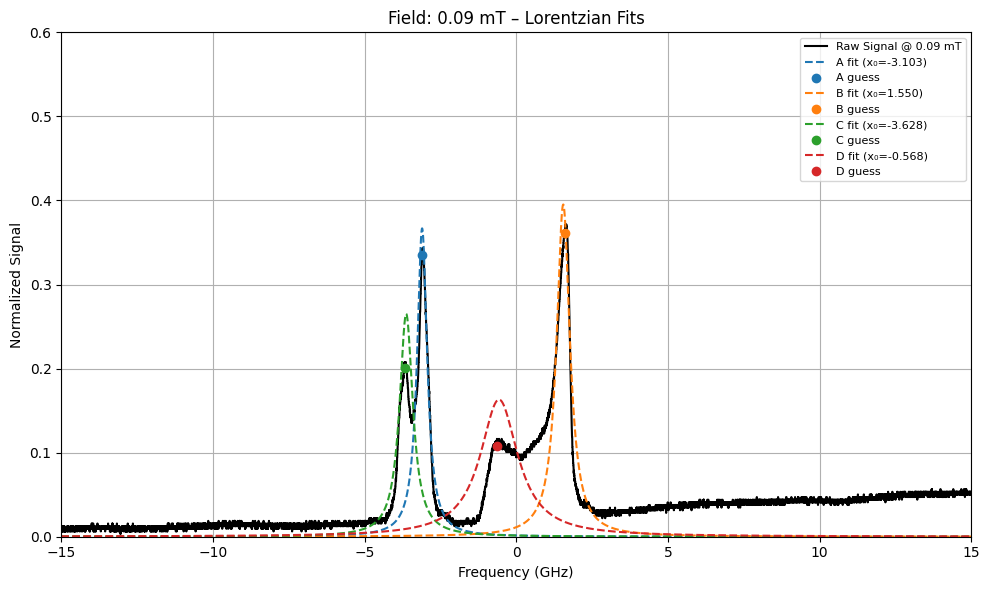

87.66333333333334

--- Fitting Lorentzians at B = 0.09 mT ---
  Trying A at B = 87.66 mT
    Guess: Gamma=0.3548, x0=-3.0573, scale=0.1910
    Bounds: [[np.float64(0.01507973782108671), np.float64(-0.667911789), np.float64(0.06411451081304945)]], [[np.float64(1.507973782108671), np.float64(-0.567911789), np.float64(0.5129160865043956)]]
  Trying B at B = 87.66 mT
    Guess: Gamma=0.5766, x0=1.5997, scale=0.3336
    Bounds: [[np.float64(0.003548173604961562), np.float64(-3.107281143), np.float64(0.04775363119622455)]], [[np.float64(0.3548173604961562), np.float64(-3.007281143), np.float64(0.3820290495697964)]]
  Trying C at B = 87.66 mT
    Guess: Gamma=0.6209, x0=-3.6782, scale=0.1880
    Bounds: [[np.float64(0.005765782108062574), np.float64(1.5496967136307453), np.float64(0.083389631919989)]], [[np.float64(0.5765782108062574), np.float64(1.6496967136307454), np.float64(0.667117055359912)]]
  Trying D at B = 87.66 mT
    Guess: Gamma=1.4193, x0=-0.6179, scale=0.2403
    Bounds: [[np.f

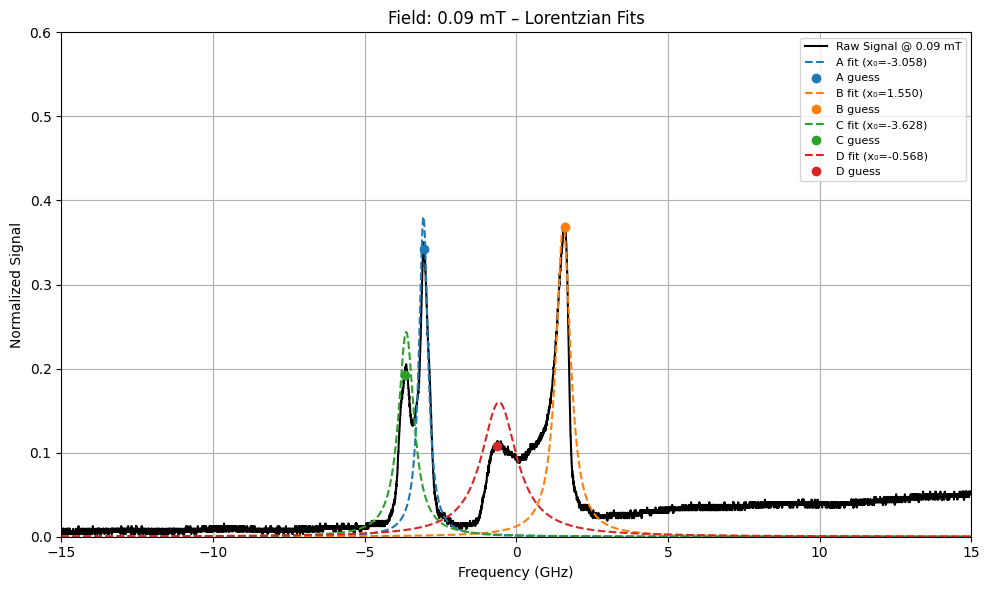

86.14666666666668

--- Fitting Lorentzians at B = 0.09 mT ---
  Trying A at B = 86.15 mT
    Guess: Gamma=0.4435, x0=-3.0129, scale=0.2428
    Bounds: [[np.float64(0.01419269441984632), np.float64(-0.667911789), np.float64(0.060064366458097374)]], [[np.float64(1.419269441984632), np.float64(-0.567911789), np.float64(0.480514931664779)]]
  Trying B at B = 86.15 mT
    Guess: Gamma=0.6209, x0=1.5110, scale=0.3469
    Bounds: [[np.float64(0.004435217006201952), np.float64(-3.062928973), np.float64(0.06071054145798802)]], [[np.float64(0.4435217006201952), np.float64(-2.9629289730000004), np.float64(0.4856843316639042)]]
  Trying C at B = 86.15 mT
    Guess: Gamma=0.5766, x0=-3.6782, scale=0.1657
    Bounds: [[np.float64(0.006209303808682769), np.float64(1.4609923735067027), np.float64(0.08671340360038347)]], [[np.float64(0.6209303808682769), np.float64(1.5609923735067028), np.float64(0.6937072288030678)]]
  Trying D at B = 86.15 mT
    Guess: Gamma=1.5080, x0=-0.6623, scale=0.2549
    Boun

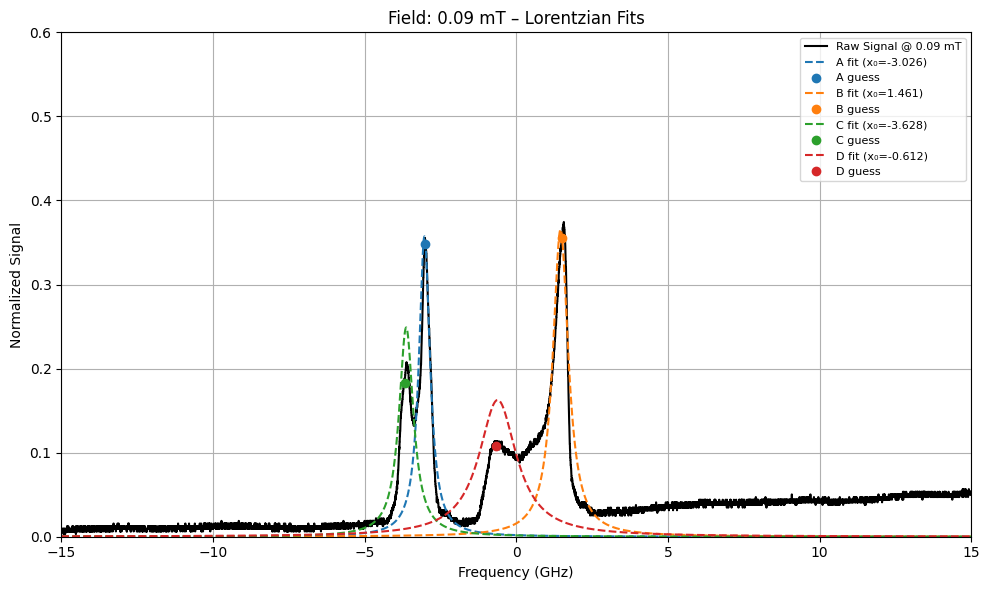

84.63000000000001

--- Fitting Lorentzians at B = 0.08 mT ---
  Trying A at B = 84.63 mT
    Guess: Gamma=0.3548, x0=-2.9686, scale=0.1994
    Bounds: [[np.float64(0.01507973782108671), np.float64(-0.71226396), np.float64(0.06372149646430803)]], [[np.float64(1.507973782108671), np.float64(-0.6122639599999999), np.float64(0.5097719717144642)]]
  Trying B at B = 84.63 mT
    Guess: Gamma=0.6209, x0=1.4666, scale=0.3454
    Bounds: [[np.float64(0.003548173604961562), np.float64(-3.0185768029999998), np.float64(0.0498601410017157)]], [[np.float64(0.3548173604961562), np.float64(-2.918576803), np.float64(0.3988811280137256)]]
  Trying C at B = 84.63 mT
    Guess: Gamma=0.5322, x0=-3.5895, scale=0.1678
    Bounds: [[np.float64(0.006209303808682769), np.float64(1.4166402034446832), np.float64(0.08635569487740923)]], [[np.float64(0.6209303808682769), np.float64(1.5166402034446833), np.float64(0.6908455590192738)]]
  Trying D at B = 84.63 mT
    Guess: Gamma=1.5080, x0=-0.7066, scale=0.2570
   

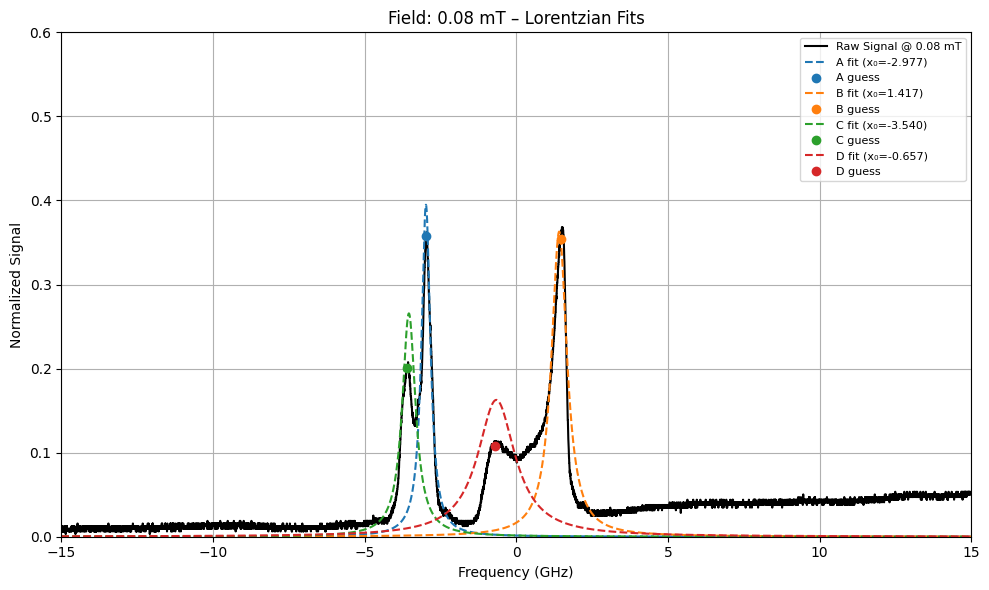

83.11333333333334

--- Fitting Lorentzians at B = 0.08 mT ---
  Trying A at B = 83.11 mT
    Guess: Gamma=0.4435, x0=-2.9242, scale=0.2516
    Bounds: [[np.float64(0.01507973782108671), np.float64(-0.75661613), np.float64(0.06423815357868745)]], [[np.float64(1.507973782108671), np.float64(-0.65661613), np.float64(0.5139052286294996)]]
  Trying B at B = 83.11 mT
    Guess: Gamma=0.6209, x0=1.4666, scale=0.3554
    Bounds: [[np.float64(0.004435217006201952), np.float64(-2.974224633), np.float64(0.0628946010102216)]], [[np.float64(0.4435217006201952), np.float64(-2.8742246330000003), np.float64(0.5031568080817728)]]
  Trying C at B = 83.11 mT
    Guess: Gamma=0.5766, x0=-3.5895, scale=0.1785
    Bounds: [[np.float64(0.006209303808682769), np.float64(1.4166402034446832), np.float64(0.08886118095523222)]], [[np.float64(0.6209303808682769), np.float64(1.5166402034446833), np.float64(0.7108894476418578)]]
  Trying D at B = 83.11 mT
    Guess: Gamma=1.3749, x0=-0.7066, scale=0.2349
    Bounds:

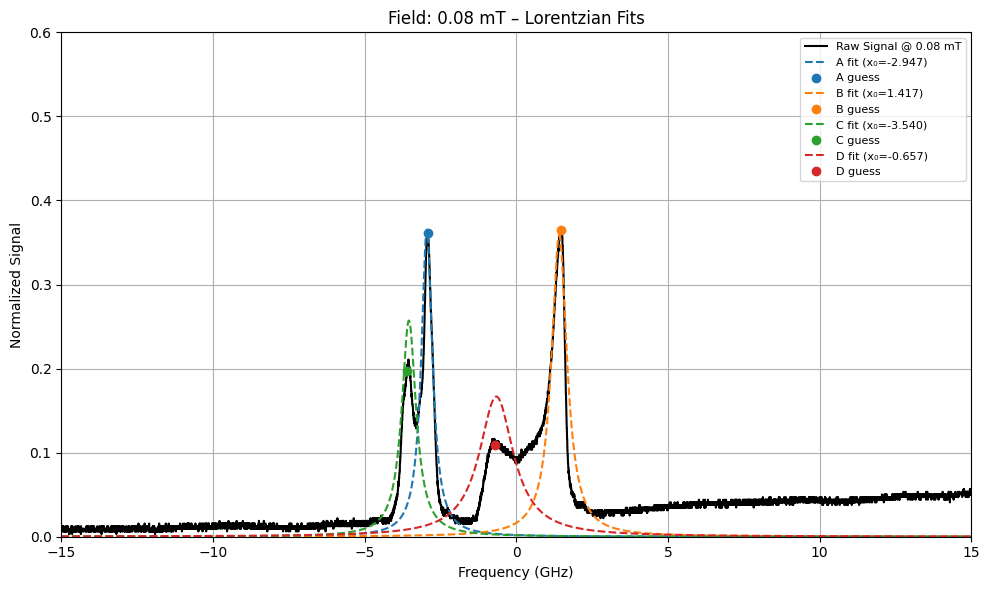

81.59666666666668

--- Fitting Lorentzians at B = 0.08 mT ---
  Trying A at B = 81.60 mT
    Guess: Gamma=0.3992, x0=-2.9242, scale=0.2157
    Bounds: [[np.float64(0.013749172719226124), np.float64(-0.75661613), np.float64(0.05873223686838003)]], [[np.float64(1.3749172719226124), np.float64(-0.65661613), np.float64(0.4698578949470402)]]
  Trying B at B = 81.60 mT
    Guess: Gamma=0.5766, x0=1.3779, scale=0.3164
    Bounds: [[np.float64(0.003991695305581757), np.float64(-2.974224633), np.float64(0.05392024608895327)]], [[np.float64(0.3991695305581757), np.float64(-2.8742246330000003), np.float64(0.4313619687116262)]]
  Trying C at B = 81.60 mT
    Guess: Gamma=0.5322, x0=-3.5452, scale=0.1672
    Bounds: [[np.float64(0.005765782108062574), np.float64(1.3279358633206442), np.float64(0.07909754829508757)]], [[np.float64(0.5765782108062574), np.float64(1.4279358633206443), np.float64(0.6327803863607006)]]
  Trying D at B = 81.60 mT
    Guess: Gamma=1.3306, x0=-0.7066, scale=0.2273
    Boun

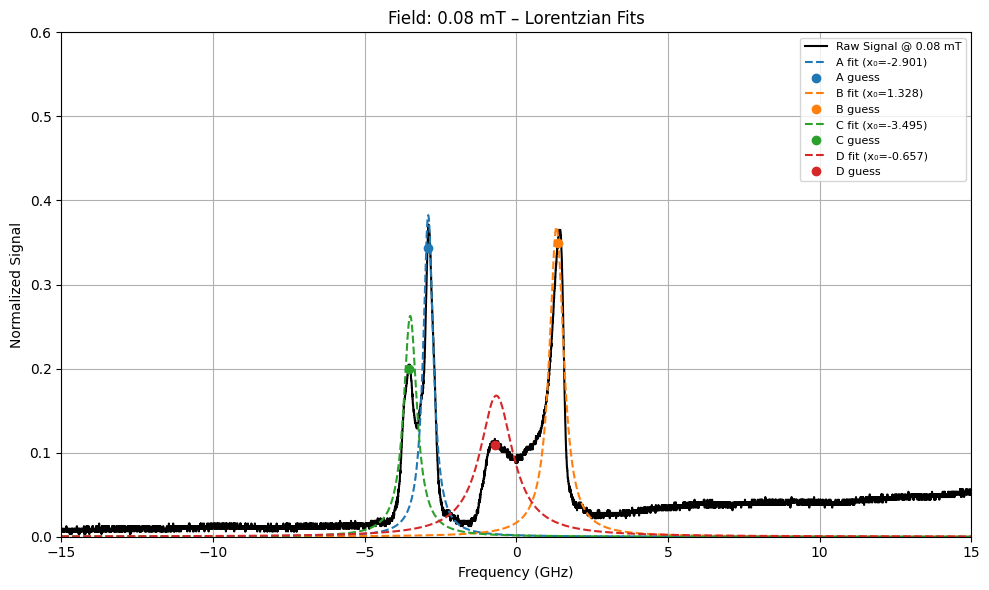

80.08

--- Fitting Lorentzians at B = 0.08 mT ---
  Trying A at B = 80.08 mT
    Guess: Gamma=0.3548, x0=-2.8799, scale=0.1978
    Bounds: [[np.float64(0.01330565101860593), np.float64(-0.75661613), np.float64(0.05681866959121123)]], [[np.float64(1.3305651018605928), np.float64(-0.65661613), np.float64(0.4545493567296898)]]
  Trying B at B = 80.08 mT
    Guess: Gamma=0.6653, x0=1.4666, scale=0.3369
    Bounds: [[np.float64(0.003548173604961562), np.float64(-2.9298724629999997), np.float64(0.04944344238188037)]], [[np.float64(0.3548173604961562), np.float64(-2.829872463), np.float64(0.395547539055043)]]
  Trying C at B = 80.08 mT
    Guess: Gamma=0.6653, x0=-3.5895, scale=0.1907
    Bounds: [[np.float64(0.006652825509302965), np.float64(1.4166402034446832), np.float64(0.08423584467948565)]], [[np.float64(0.6652825509302964), np.float64(1.5166402034446833), np.float64(0.6738867574358852)]]
  Trying D at B = 80.08 mT
    Guess: Gamma=1.3306, x0=-0.7953, scale=0.2296
    Bounds: [[np.float

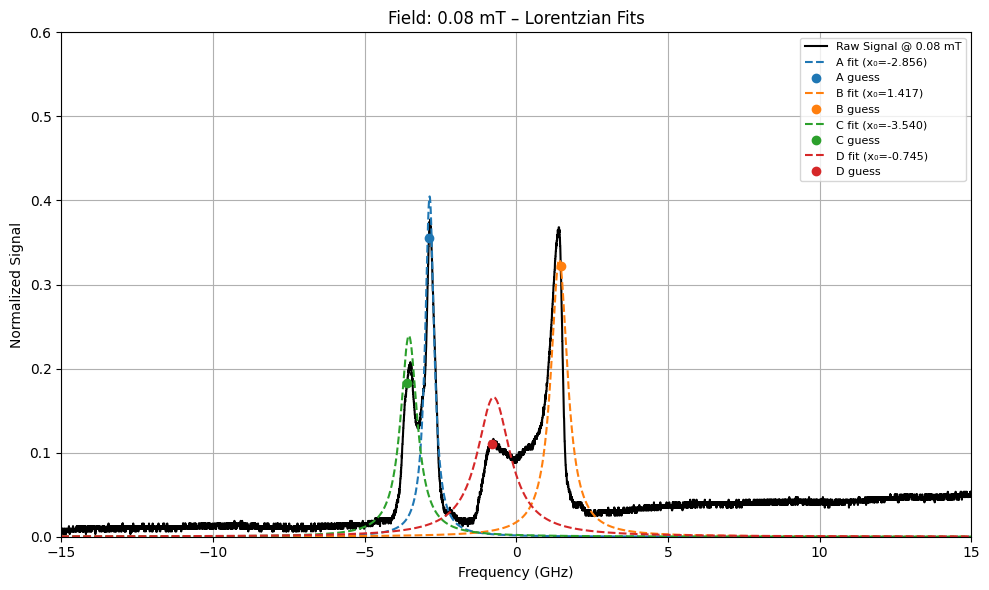

78.56333333333333

--- Fitting Lorentzians at B = 0.08 mT ---
  Trying A at B = 78.56 mT
    Guess: Gamma=0.3992, x0=-2.7912, scale=0.2345
    Bounds: [[np.float64(0.01330565101860593), np.float64(-0.84532047), np.float64(0.0573997539215789)]], [[np.float64(1.3305651018605928), np.float64(-0.7453204699999999), np.float64(0.4591980313726312)]]
  Trying B at B = 78.56 mT
    Guess: Gamma=0.6209, x0=1.3336, scale=0.3524
    Bounds: [[np.float64(0.003991695305581757), np.float64(-2.8411681229999997), np.float64(0.0586323689074301)]], [[np.float64(0.3991695305581757), np.float64(-2.741168123), np.float64(0.4690589512594408)]]
  Trying C at B = 78.56 mT
    Guess: Gamma=0.6209, x0=-3.5008, scale=0.1941
    Bounds: [[np.float64(0.006209303808682734), np.float64(1.2835836932586246), np.float64(0.08809596793975942)]], [[np.float64(0.6209303808682733), np.float64(1.3835836932586247), np.float64(0.7047677435180754)]]
  Trying D at B = 78.56 mT
    Guess: Gamma=1.4193, x0=-0.8397, scale=0.2418
   

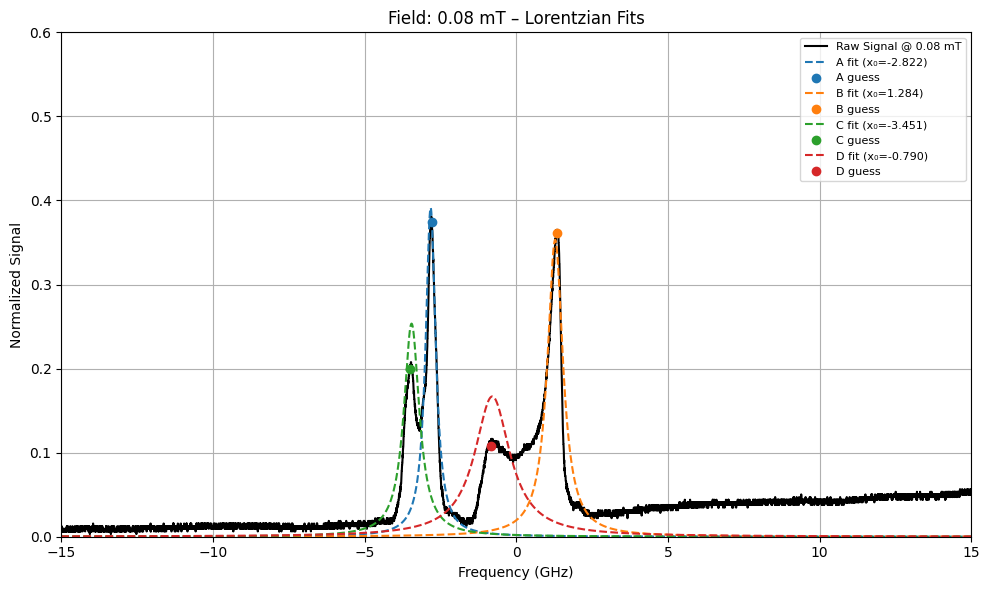

77.04666666666667

--- Fitting Lorentzians at B = 0.08 mT ---
  Trying A at B = 77.05 mT
    Guess: Gamma=0.3992, x0=-2.7912, scale=0.2345
    Bounds: [[np.float64(0.01419269441984632), np.float64(-0.88967264), np.float64(0.0604430624806852)]], [[np.float64(1.419269441984632), np.float64(-0.7896726399999999), np.float64(0.4835444998454816)]]
  Trying B at B = 77.05 mT
    Guess: Gamma=0.5766, x0=1.2449, scale=0.3098
    Bounds: [[np.float64(0.003991695305581757), np.float64(-2.8411681229999997), np.float64(0.058632433849063276)]], [[np.float64(0.3991695305581757), np.float64(-2.741168123), np.float64(0.4690594707925062)]]
  Trying C at B = 77.05 mT
    Guess: Gamma=0.5766, x0=-3.4565, scale=0.1830
    Bounds: [[np.float64(0.005765782108062539), np.float64(1.1948793531345856), np.float64(0.07745315496638087)]], [[np.float64(0.5765782108062538), np.float64(1.2948793531345857), np.float64(0.619625239731047)]]
  Trying D at B = 77.05 mT
    Guess: Gamma=1.3749, x0=-0.8397, scale=0.2372
   

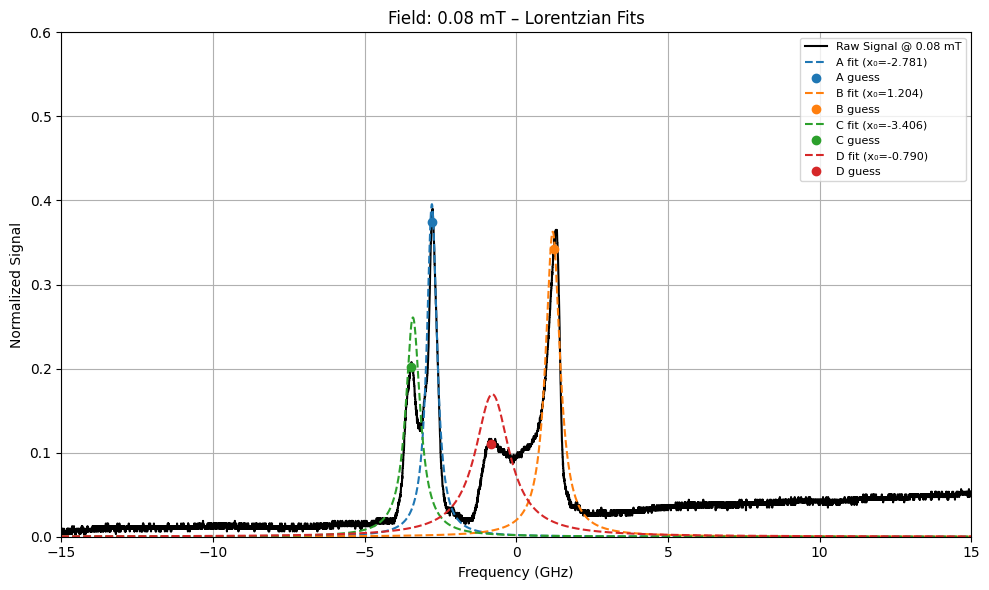

75.53

--- Fitting Lorentzians at B = 0.08 mT ---
  Trying A at B = 75.53 mT
    Guess: Gamma=0.3548, x0=-2.7468, scale=0.2120
    Bounds: [[np.float64(0.013749172719226124), np.float64(-0.88967264), np.float64(0.059298273810821776)]], [[np.float64(1.3749172719226124), np.float64(-0.7896726399999999), np.float64(0.4743861904865742)]]
  Trying B at B = 75.53 mT
    Guess: Gamma=0.6209, x0=1.2449, scale=0.3488
    Bounds: [[np.float64(0.003548173604961597), np.float64(-2.7968159519999998), np.float64(0.053005585939866526)]], [[np.float64(0.3548173604961597), np.float64(-2.696815952), np.float64(0.4240446875189322)]]
  Trying C at B = 75.53 mT
    Guess: Gamma=0.6653, x0=-3.4565, scale=0.2052
    Bounds: [[np.float64(0.006209303808682734), np.float64(1.1948793531345856), np.float64(0.08720289425)]], [[np.float64(0.6209303808682733), np.float64(1.2948793531345857), np.float64(0.697623154)]]
  Trying D at B = 75.53 mT
    Guess: Gamma=1.4193, x0=-0.9284, scale=0.2390
    Bounds: [[np.float6

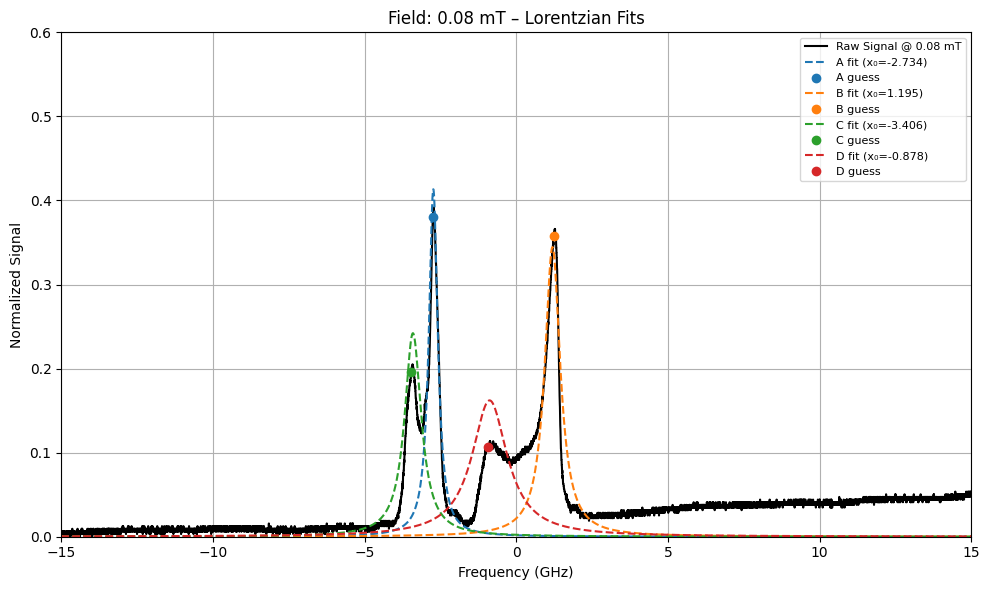

74.01333333333334

--- Fitting Lorentzians at B = 0.07 mT ---
  Trying A at B = 74.01 mT
    Guess: Gamma=0.3992, x0=-2.7025, scale=0.2447
    Bounds: [[np.float64(0.01419269441984632), np.float64(-0.9783769800000001), np.float64(0.059750823712086676)]], [[np.float64(1.419269441984632), np.float64(-0.87837698), np.float64(0.4780065896966934)]]
  Trying B at B = 74.01 mT
    Guess: Gamma=0.4879, x0=1.1562, scale=0.2566
    Bounds: [[np.float64(0.0039916953055817925), np.float64(-2.752463782), np.float64(0.06117974941085998)]], [[np.float64(0.3991695305581793), np.float64(-2.6524637820000003), np.float64(0.4894379952868798)]]
  Trying C at B = 74.01 mT
    Guess: Gamma=0.5766, x0=-3.4565, scale=0.1699
    Bounds: [[np.float64(0.004878738706822147), np.float64(1.1061750130105465), np.float64(0.06415280922535956)]], [[np.float64(0.4878738706822147), np.float64(1.2061750130105466), np.float64(0.5132224738028764)]]
  Trying D at B = 74.01 mT
    Guess: Gamma=1.3306, x0=-0.8840, scale=0.2291


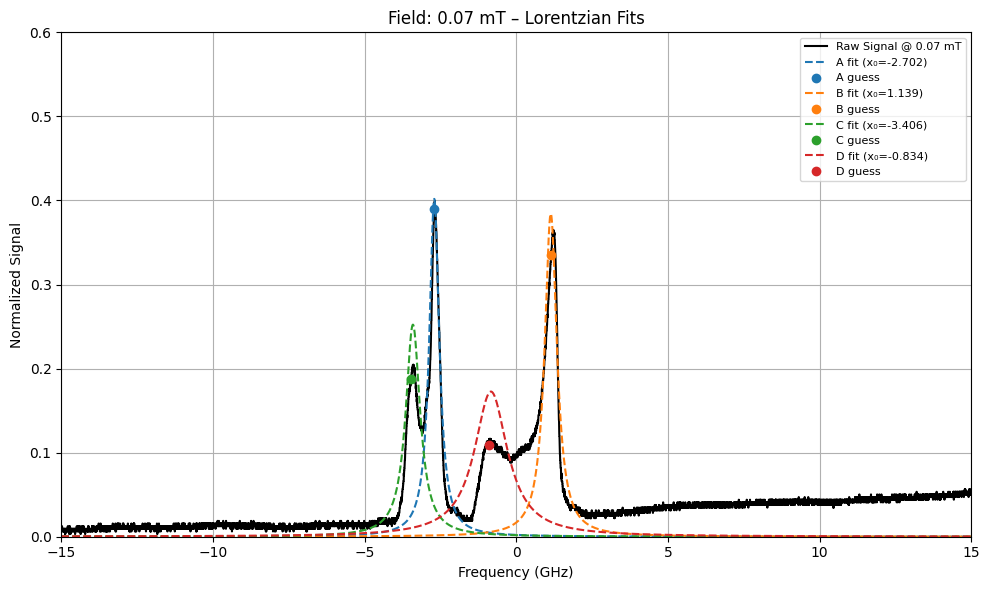

72.49666666666667

--- Fitting Lorentzians at B = 0.07 mT ---
  Trying A at B = 72.50 mT
    Guess: Gamma=0.3548, x0=-2.6581, scale=0.2195
    Bounds: [[np.float64(0.01330565101860593), np.float64(-0.93402481), np.float64(0.057273785704436)]], [[np.float64(1.3305651018605928), np.float64(-0.83402481), np.float64(0.458190285635488)]]
  Trying B at B = 72.50 mT
    Guess: Gamma=0.5766, x0=1.2005, scale=0.3251
    Bounds: [[np.float64(0.003548173604961597), np.float64(-2.7081116119999997), np.float64(0.05488273165935562)]], [[np.float64(0.3548173604961597), np.float64(-2.608111612), np.float64(0.439061853274845)]]
  Trying C at B = 72.50 mT
    Guess: Gamma=0.5766, x0=-3.3677, scale=0.1808
    Bounds: [[np.float64(0.005765782108062539), np.float64(1.1505271830725659), np.float64(0.08127025327777596)]], [[np.float64(0.5765782108062538), np.float64(1.250527183072566), np.float64(0.6501620262222076)]]
  Trying D at B = 72.50 mT
    Guess: Gamma=1.3749, x0=-0.9284, scale=0.2331
    Bounds: [[

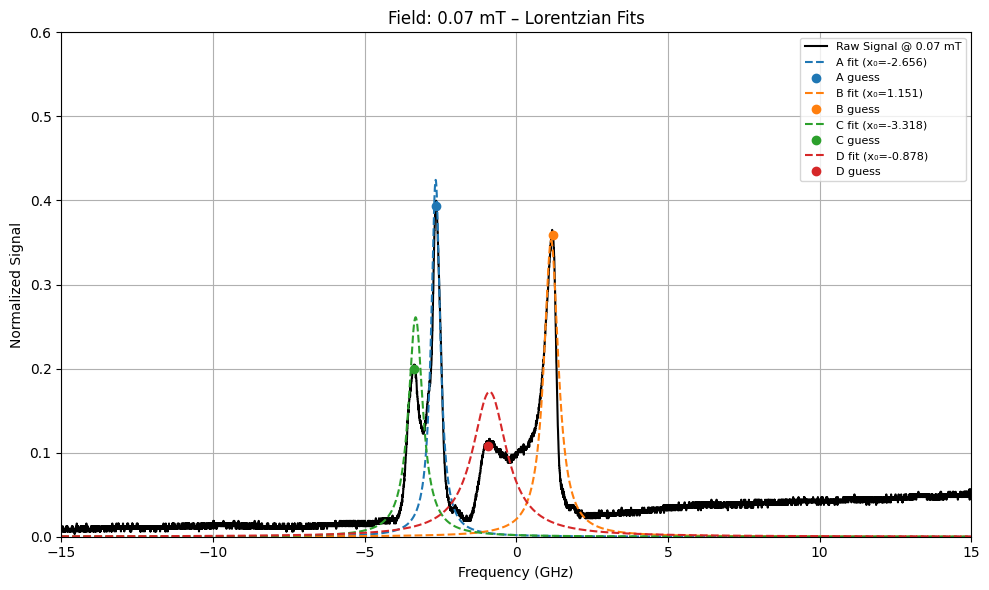

70.98

--- Fitting Lorentzians at B = 0.07 mT ---
  Trying A at B = 70.98 mT
    Guess: Gamma=0.3548, x0=-2.6138, scale=0.2219
    Bounds: [[np.float64(0.013749172719226124), np.float64(-0.9783769800000001), np.float64(0.058268751082579374)]], [[np.float64(1.3749172719226124), np.float64(-0.87837698), np.float64(0.466150008660635)]]
  Trying B at B = 70.98 mT
    Guess: Gamma=0.5766, x0=1.1118, scale=0.3180
    Bounds: [[np.float64(0.003548173604961597), np.float64(-2.663759442), np.float64(0.05546961333788417)]], [[np.float64(0.3548173604961597), np.float64(-2.5637594420000003), np.float64(0.4437569067030734)]]
  Trying C at B = 70.98 mT
    Guess: Gamma=0.6653, x0=-3.3234, scale=0.2074
    Bounds: [[np.float64(0.005765782108062539), np.float64(1.061822842948527), np.float64(0.07949728985492975)]], [[np.float64(0.5765782108062538), np.float64(1.1618228429485271), np.float64(0.635978318839438)]]
  Trying D at B = 70.98 mT
    Guess: Gamma=1.4636, x0=-0.9727, scale=0.2552
    Bounds: [[

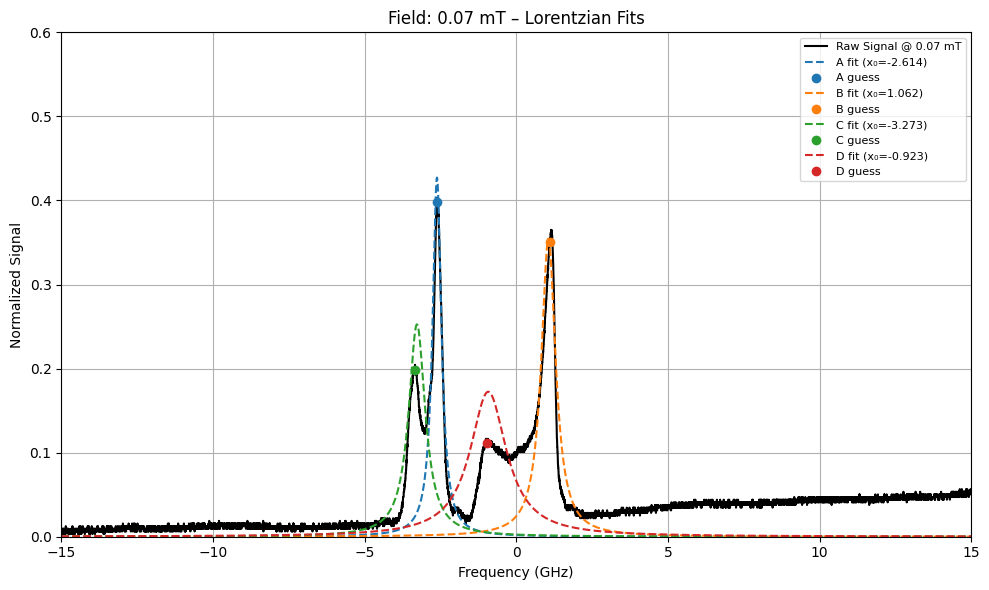

69.46333333333334

--- Fitting Lorentzians at B = 0.07 mT ---
  Trying A at B = 69.46 mT
    Guess: Gamma=0.3992, x0=-2.5694, scale=0.2538
    Bounds: [[np.float64(0.014636216120466514), np.float64(-1.02272915), np.float64(0.06379928552210923)]], [[np.float64(1.4636216120466514), np.float64(-0.92272915), np.float64(0.5103942841768738)]]
  Trying B at B = 69.46 mT
    Guess: Gamma=0.5766, x0=1.0675, scale=0.3157
    Bounds: [[np.float64(0.0039916953055817925), np.float64(-2.6194072719999997), np.float64(0.06345260936657188)]], [[np.float64(0.3991695305581793), np.float64(-2.519407272), np.float64(0.507620874932575)]]
  Trying C at B = 69.46 mT
    Guess: Gamma=0.6653, x0=-3.3677, scale=0.1988
    Bounds: [[np.float64(0.005765782108062574), np.float64(1.0174706728865075), np.float64(0.07893001656171403)]], [[np.float64(0.5765782108062574), np.float64(1.1174706728865076), np.float64(0.6314401324937122)]]
  Trying D at B = 69.46 mT
    Guess: Gamma=1.3306, x0=-0.9727, scale=0.2338
    Boun

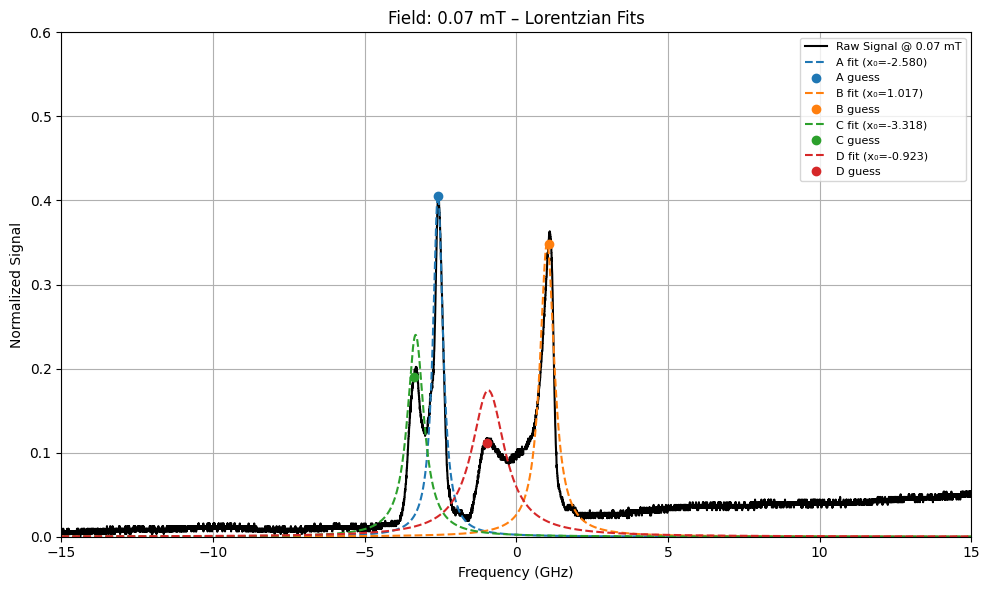

67.94666666666667

--- Fitting Lorentzians at B = 0.07 mT ---
  Trying A at B = 67.95 mT
    Guess: Gamma=0.3548, x0=-2.5694, scale=0.2094
    Bounds: [[np.float64(0.01330565101860593), np.float64(-1.02272915), np.float64(0.0584412022397502)]], [[np.float64(1.3305651018605928), np.float64(-0.92272915), np.float64(0.4675296179180016)]]
  Trying B at B = 67.95 mT
    Guess: Gamma=0.5322, x0=1.0231, scale=0.2888
    Bounds: [[np.float64(0.003548173604961597), np.float64(-2.6194072719999997), np.float64(0.05234221216962545)]], [[np.float64(0.3548173604961597), np.float64(-2.519407272), np.float64(0.4187376973570036)]]
  Trying C at B = 67.95 mT
    Guess: Gamma=0.5766, x0=-3.3677, scale=0.1659
    Bounds: [[np.float64(0.005322260407442379), np.float64(0.973118502824488), np.float64(0.07218885744344035)]], [[np.float64(0.5322260407442378), np.float64(1.073118502824488), np.float64(0.5775108595475228)]]
  Trying D at B = 67.95 mT
    Guess: Gamma=1.2862, x0=-0.9727, scale=0.2267
    Bounds: 

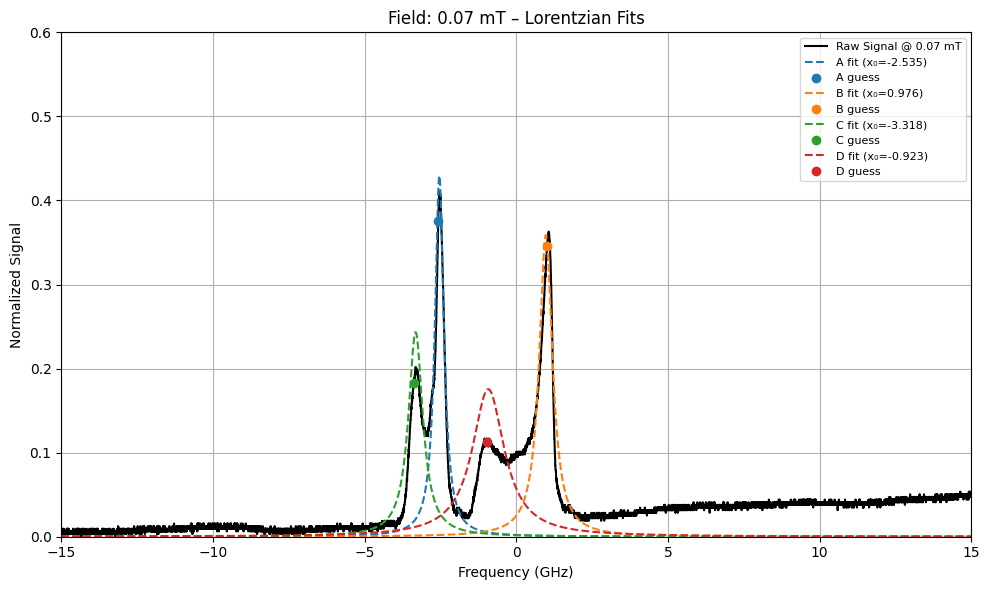

66.43

--- Fitting Lorentzians at B = 0.07 mT ---
  Trying A at B = 66.43 mT
    Guess: Gamma=0.3992, x0=-2.5251, scale=0.2409
    Bounds: [[np.float64(0.012862129317985731), np.float64(-1.02272915), np.float64(0.05667087301141392)]], [[np.float64(1.286212931798573), np.float64(-0.92272915), np.float64(0.4533669840913114)]]
  Trying B at B = 66.43 mT
    Guess: Gamma=0.0000, x0=1.0231, scale=0.0000
    Bounds: [[np.float64(0.0039916953055817925), np.float64(-2.575055102), np.float64(0.06023448684037605)]], [[np.float64(0.3991695305581793), np.float64(-2.4750551020000002), np.float64(0.4818758947230084)]]
Fit failed for B at B = 0.07 mT: Each lower bound must be strictly less than each upper bound.
  Trying C at B = 66.43 mT
    Guess: Gamma=0.5766, x0=-3.2790, scale=0.1767
    Bounds: [[np.float64(0.0), np.float64(0.973118502824488), np.float64(0.0)]], [[np.float64(0.0), np.float64(1.073118502824488), np.float64(0.0)]]
  Trying D at B = 66.43 mT
    Guess: Gamma=1.3749, x0=-1.0171, sca

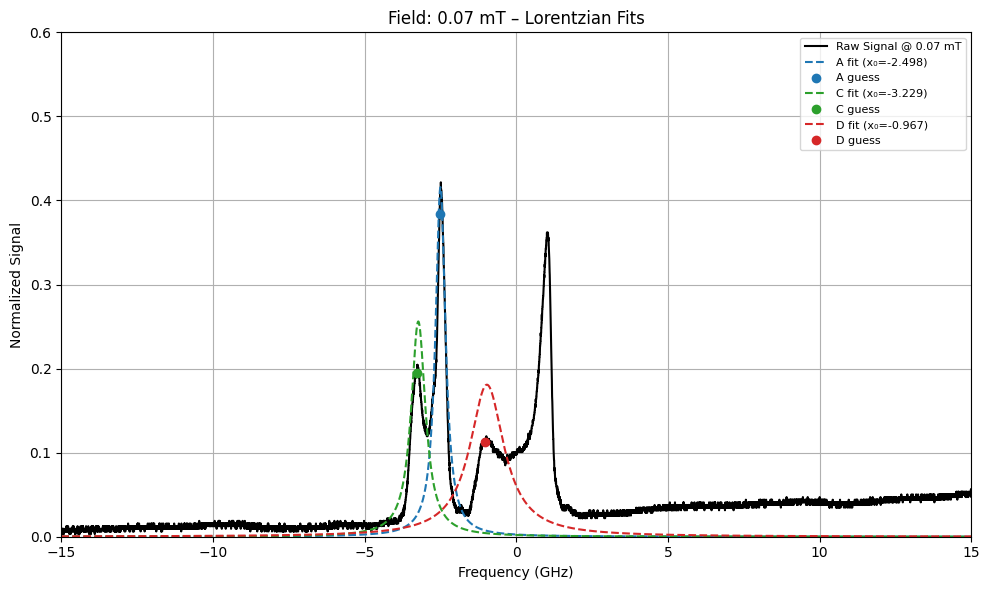

64.91333333333334

--- Fitting Lorentzians at B = 0.06 mT ---
  Trying A at B = 64.91 mT
    Guess: Gamma=0.3548, x0=-2.4807, scale=0.2199
    Bounds: [[np.float64(0.013749172719226124), np.float64(-1.06708132), np.float64(0.060674482551483125)]], [[np.float64(1.3749172719226124), np.float64(-0.9670813199999999), np.float64(0.485395860411865)]]
  Trying B at B = 64.91 mT
    Guess: Gamma=0.5322, x0=1.0231, scale=0.2919
    Bounds: [[np.float64(0.003548173604961597), np.float64(-2.5307029319999996), np.float64(0.05497107103269557)]], [[np.float64(0.3548173604961597), np.float64(-2.430702932), np.float64(0.4397685682615646)]]
  Trying C at B = 64.91 mT
    Guess: Gamma=0.6209, x0=-3.3234, scale=0.1746
    Bounds: [[np.float64(0.005322260407442379), np.float64(0.973118502824488), np.float64(0.07297247330981747)]], [[np.float64(0.5322260407442378), np.float64(1.073118502824488), np.float64(0.5837797864785398)]]
  Trying D at B = 64.91 mT
    Guess: Gamma=1.5080, x0=-1.1058, scale=0.2615
  

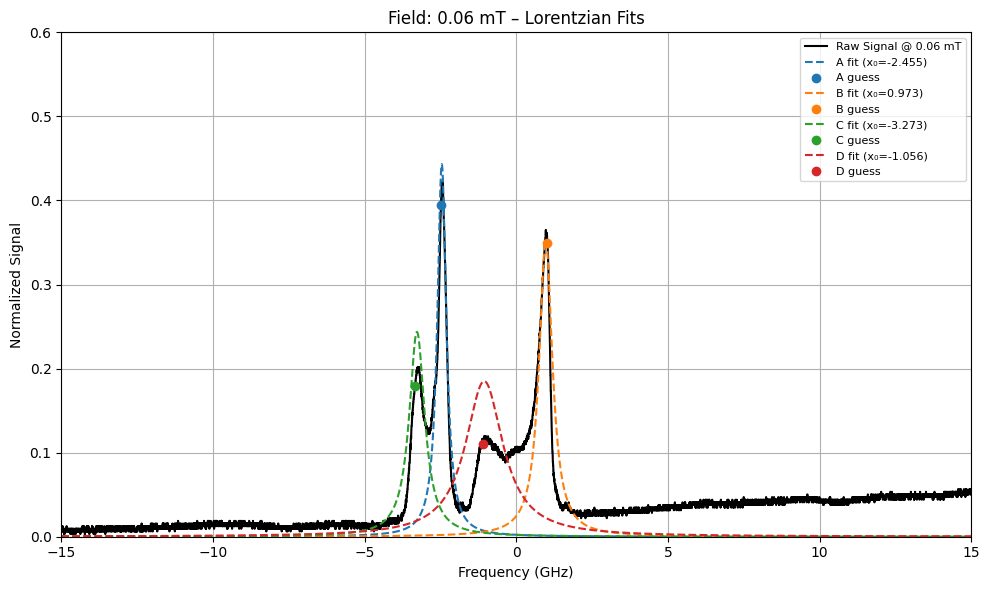

63.39666666666667

--- Fitting Lorentzians at B = 0.06 mT ---
  Trying A at B = 63.40 mT
    Guess: Gamma=0.2661, x0=-2.4807, scale=0.1414
    Bounds: [[np.float64(0.01507973782108671), np.float64(-1.15578566), np.float64(0.06538706530507438)]], [[np.float64(1.507973782108671), np.float64(-1.05578566), np.float64(0.523096522440595)]]
  Trying B at B = 63.40 mT
    Guess: Gamma=0.4879, x0=0.8901, scale=0.2591
    Bounds: [[np.float64(0.0026611302037212073), np.float64(-2.5307029319999996), np.float64(0.03535584565997942)]], [[np.float64(0.2661130203721207), np.float64(-2.430702932), np.float64(0.2828467652798354)]]
  Trying C at B = 63.40 mT
    Guess: Gamma=0.5766, x0=-3.2347, scale=0.1762
    Bounds: [[np.float64(0.004878738706822184), np.float64(0.8400619926384294), np.float64(0.0647853920417879)]], [[np.float64(0.4878738706822183), np.float64(0.9400619926384295), np.float64(0.5182831363343032)]]
  Trying D at B = 63.40 mT
    Guess: Gamma=1.3749, x0=-1.0614, scale=0.2414
    Bounds:

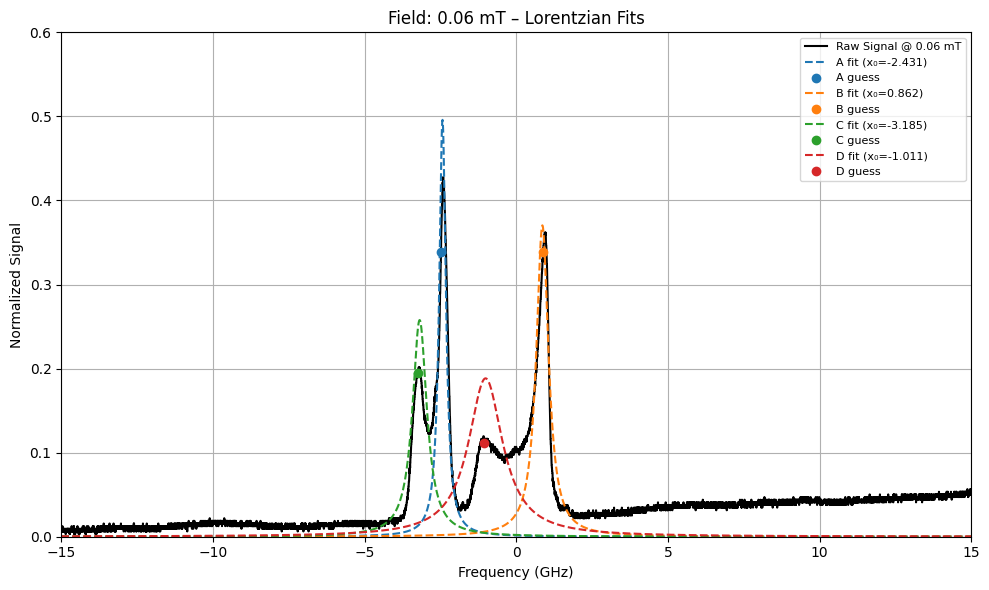

61.88

--- Fitting Lorentzians at B = 0.06 mT ---
  Trying A at B = 61.88 mT
    Guess: Gamma=0.3548, x0=-2.3920, scale=0.2311
    Bounds: [[np.float64(0.013749172719226124), np.float64(-1.11143349), np.float64(0.0603558336288518)]], [[np.float64(1.3749172719226124), np.float64(-1.01143349), np.float64(0.4828466690308144)]]
  Trying B at B = 61.88 mT
    Guess: Gamma=0.5322, x0=0.8901, scale=0.2979
    Bounds: [[np.float64(0.003548173604961597), np.float64(-2.441998592), np.float64(0.057781874632436676)]], [[np.float64(0.3548173604961597), np.float64(-2.3419985920000004), np.float64(0.4622549970594934)]]
  Trying C at B = 61.88 mT
    Guess: Gamma=0.5322, x0=-3.1903, scale=0.1638
    Bounds: [[np.float64(0.005322260407442379), np.float64(0.8400619926384294), np.float64(0.07448539101473182)]], [[np.float64(0.5322260407442378), np.float64(0.9400619926384295), np.float64(0.5958831281178546)]]
  Trying D at B = 61.88 mT
    Guess: Gamma=1.4636, x0=-1.1058, scale=0.2614
    Bounds: [[np.flo

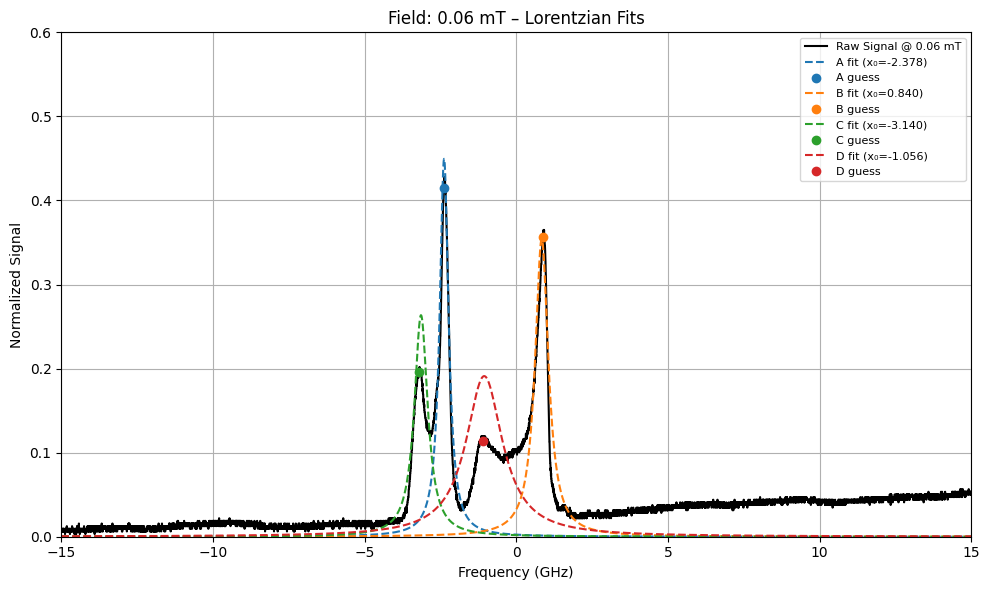

60.36333333333334

--- Fitting Lorentzians at B = 0.06 mT ---
  Trying A at B = 60.36 mT
    Guess: Gamma=0.3992, x0=-2.3476, scale=0.2636
    Bounds: [[np.float64(0.014636216120466514), np.float64(-1.15578566), np.float64(0.06533941487291478)]], [[np.float64(1.4636216120466514), np.float64(-1.05578566), np.float64(0.5227153189833182)]]
  Trying B at B = 60.36 mT
    Guess: Gamma=0.4879, x0=0.8457, scale=0.2721
    Bounds: [[np.float64(0.0039916953055817925), np.float64(-2.3976464219999998), np.float64(0.06589635209659653)]], [[np.float64(0.3991695305581793), np.float64(-2.297646422), np.float64(0.5271708167727722)]]
  Trying C at B = 60.36 mT
    Guess: Gamma=0.6653, x0=-3.2347, scale=0.1907
    Bounds: [[np.float64(0.004878738706822184), np.float64(0.7957098225764099), np.float64(0.0680257996315542)]], [[np.float64(0.4878738706822183), np.float64(0.89570982257641), np.float64(0.5442063970524336)]]
  Trying D at B = 60.36 mT
    Guess: Gamma=1.3306, x0=-1.1501, scale=0.2378
    Bounds

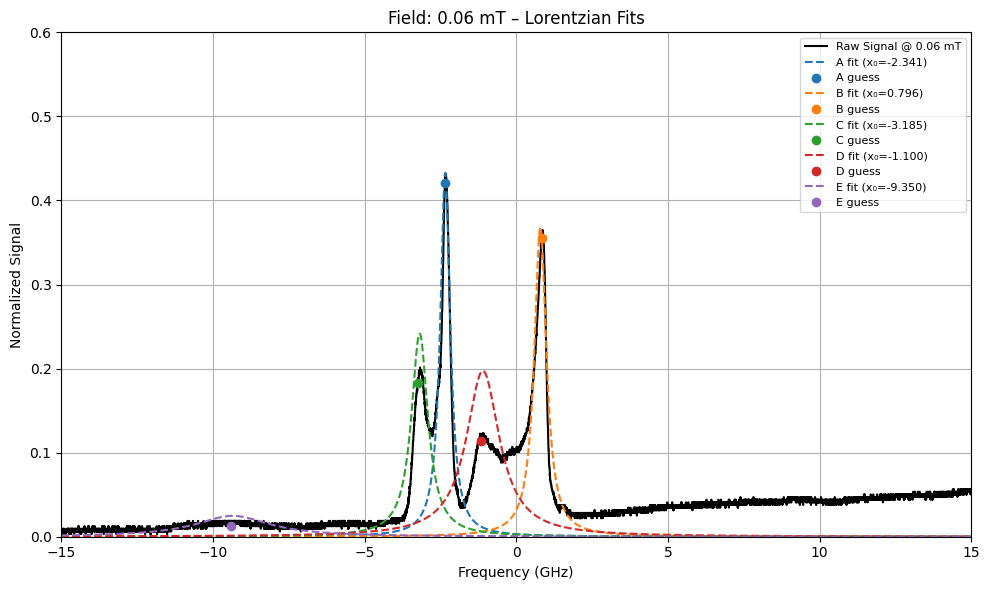

58.84666666666667

--- Fitting Lorentzians at B = 0.06 mT ---
  Trying A at B = 58.85 mT
    Guess: Gamma=0.3548, x0=-2.3476, scale=0.2040
    Bounds: [[np.float64(0.03015947564217342), np.float64(-9.449641462), np.float64(0.01470357775)]], [[np.float64(3.015947564217342), np.float64(-9.349641462), np.float64(0.117628622)]]
  Trying B at B = 58.85 mT
    Guess: Gamma=0.4879, x0=0.8014, scale=0.2698
    Bounds: [[np.float64(0.003548173604961562), np.float64(-2.3976464219999998), np.float64(0.05099159702049918)]], [[np.float64(0.3548173604961562), np.float64(-2.297646422), np.float64(0.4079327761639934)]]
  Trying C at B = 58.85 mT
    Guess: Gamma=0.5766, x0=-3.1460, scale=0.1754
    Bounds: [[np.float64(0.004878738706822184), np.float64(0.7513576525143904), np.float64(0.06744253851080402)]], [[np.float64(0.4878738706822183), np.float64(0.8513576525143904), np.float64(0.5395403080864322)]]
  Trying D at B = 58.85 mT
    Guess: Gamma=1.4636, x0=-1.2388, scale=0.2561
    Bounds: [[np.floa

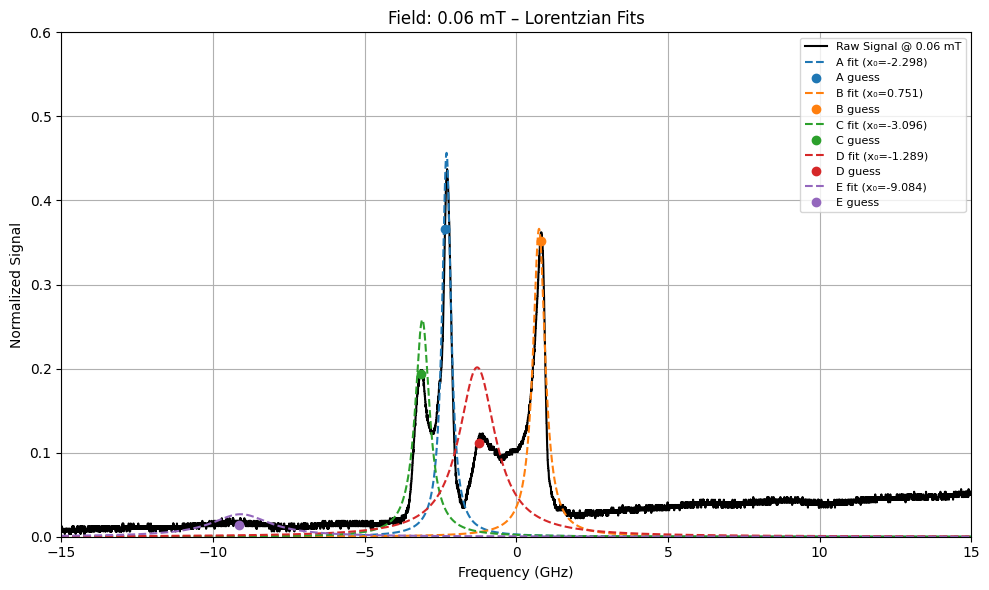

57.330000000000005

--- Fitting Lorentzians at B = 0.06 mT ---
  Trying A at B = 57.33 mT
    Guess: Gamma=0.2661, x0=-2.2589, scale=0.1801
    Bounds: [[np.float64(0.023950171833490668), np.float64(-9.183528441), np.float64(0.012595937)]], [[np.float64(2.3950171833490668), np.float64(-9.083528440999999), np.float64(0.100767496)]]
  Trying B at B = 57.33 mT
    Guess: Gamma=0.4879, x0=0.7570, scale=0.2687
    Bounds: [[np.float64(0.002661130203721171), np.float64(-2.3089420819999997), np.float64(0.0450199835)]], [[np.float64(0.2661130203721171), np.float64(-2.208942082), np.float64(0.360159868)]]
  Trying C at B = 57.33 mT
    Guess: Gamma=0.5322, x0=-3.1460, scale=0.1587
    Bounds: [[np.float64(0.004878738706822184), np.float64(0.7070054824523708), np.float64(0.0671842856394549)]], [[np.float64(0.4878738706822183), np.float64(0.8070054824523709), np.float64(0.5374742851156392)]]
  Trying D at B = 57.33 mT
    Guess: Gamma=1.3306, x0=-1.1945, scale=0.2462
    Bounds: [[np.float64(0.00

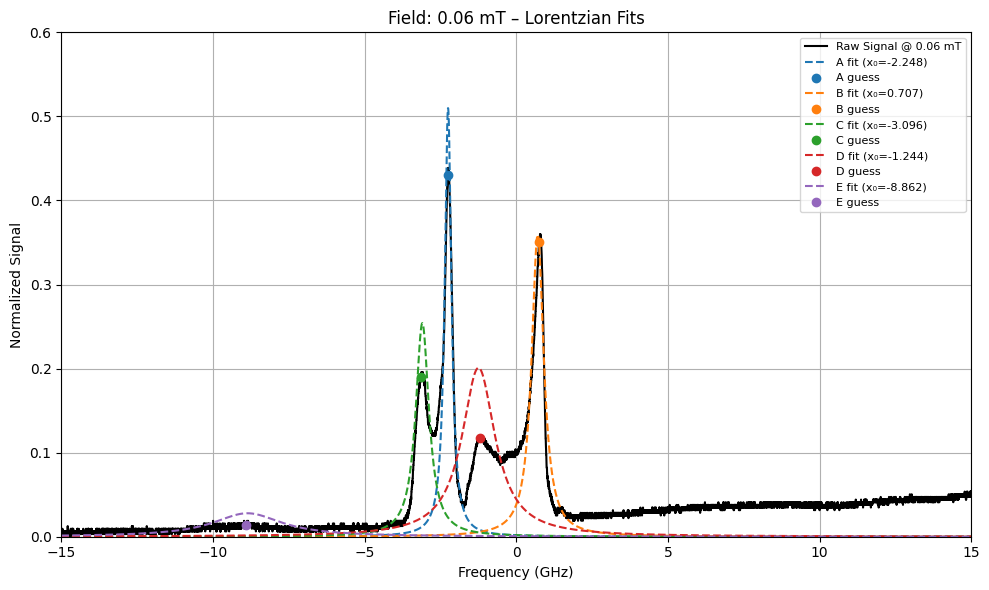

55.81333333333334

--- Fitting Lorentzians at B = 0.06 mT ---
  Trying A at B = 55.81 mT
    Guess: Gamma=0.3548, x0=-2.2146, scale=0.2424
    Bounds: [[np.float64(0.027941867139072426), np.float64(-8.961767591000001), np.float64(0.01532064925)]], [[np.float64(2.7941867139072425), np.float64(-8.861767591), np.float64(0.122565194)]]
  Trying B at B = 55.81 mT
    Guess: Gamma=0.5322, x0=0.7570, scale=0.3007
    Bounds: [[np.float64(0.003548173604961562), np.float64(-2.264589912), np.float64(0.060596635827383324)]], [[np.float64(0.3548173604961562), np.float64(-2.1645899120000003), np.float64(0.4847730866190666)]]
  Trying C at B = 55.81 mT
    Guess: Gamma=0.5766, x0=-3.1016, scale=0.1716
    Bounds: [[np.float64(0.005322260407442379), np.float64(0.7070054824523708), np.float64(0.0751835557493322)]], [[np.float64(0.5322260407442378), np.float64(0.8070054824523709), np.float64(0.6014684459946577)]]
  Trying D at B = 55.81 mT
    Guess: Gamma=1.2862, x0=-1.2388, scale=0.2381
    Bounds: [

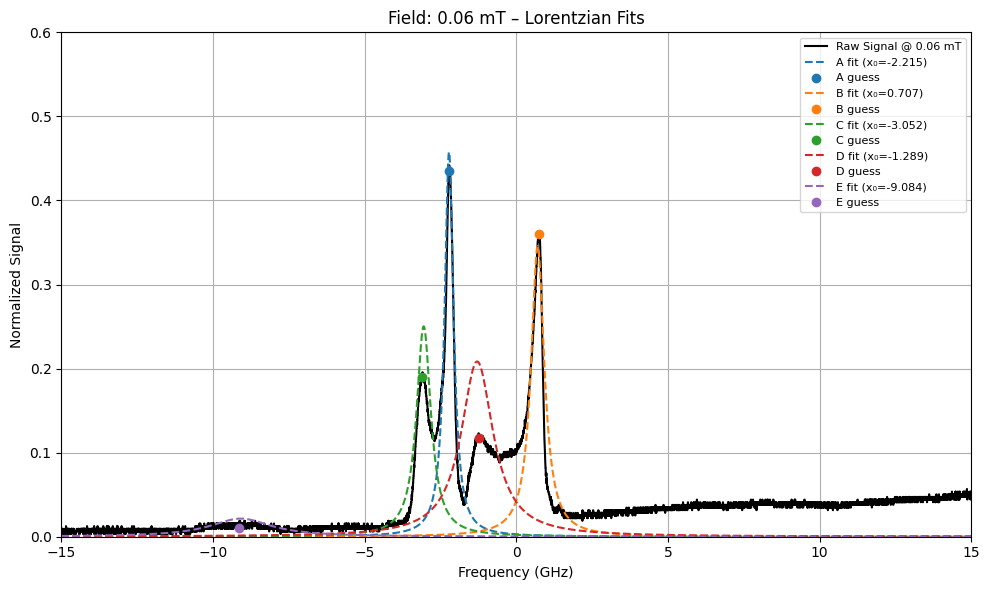

54.29666666666667

--- Fitting Lorentzians at B = 0.05 mT ---
  Trying A at B = 54.30 mT
    Guess: Gamma=0.3992, x0=-2.1702, scale=0.2754
    Bounds: [[np.float64(0.02483721523473106), np.float64(-9.183528441), np.float64(0.01050959975)]], [[np.float64(2.483721523473106), np.float64(-9.083528440999999), np.float64(0.084076798)]]
  Trying B at B = 54.30 mT
    Guess: Gamma=0.4435, x0=0.7127, scale=0.2518
    Bounds: [[np.float64(0.003991695305581757), np.float64(-2.2202377419999997), np.float64(0.0688520641314353)]], [[np.float64(0.3991695305581757), np.float64(-2.120237742), np.float64(0.5508165130514824)]]
  Trying C at B = 54.30 mT
    Guess: Gamma=0.5766, x0=-3.0573, scale=0.1730
    Bounds: [[np.float64(0.004435217006201988), np.float64(0.6626533123903477), np.float64(0.0629380422078059)]], [[np.float64(0.4435217006201988), np.float64(0.7626533123903478), np.float64(0.5035043376624472)]]
  Trying D at B = 54.30 mT
    Guess: Gamma=1.4636, x0=-1.3275, scale=0.2700
    Bounds: [[np.

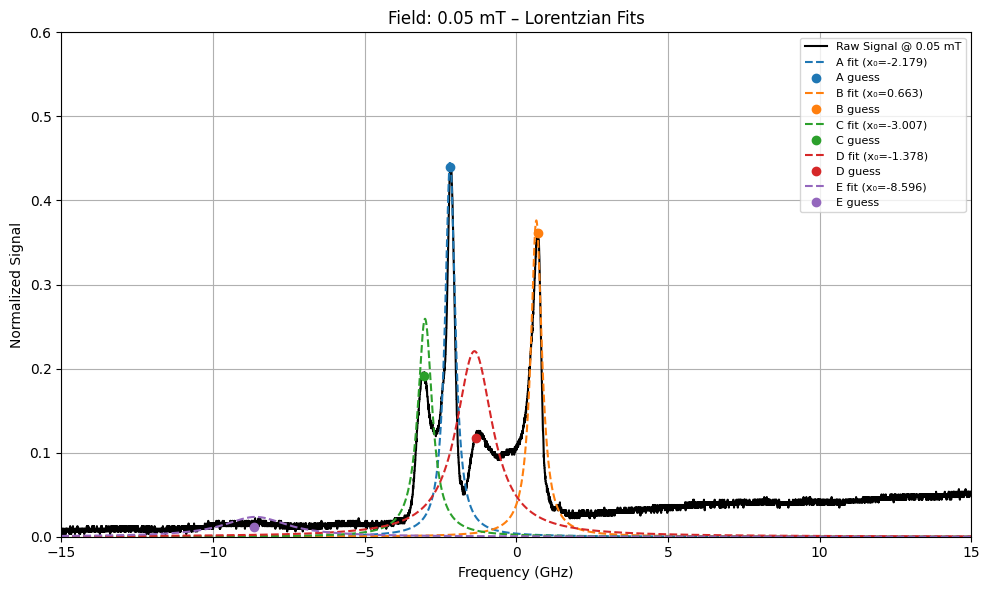

52.78

--- Fitting Lorentzians at B = 0.05 mT ---
  Trying A at B = 52.78 mT
    Guess: Gamma=0.3992, x0=-2.1702, scale=0.2553
    Bounds: [[np.float64(0.02572425863597143), np.float64(-8.695654571), np.float64(0.01191580025)]], [[np.float64(2.572425863597143), np.float64(-8.595654570999999), np.float64(0.095326402)]]
  Trying B at B = 52.78 mT
    Guess: Gamma=0.4435, x0=0.6683, scale=0.2520
    Bounds: [[np.float64(0.003991695305581757), np.float64(-2.2202377419999997), np.float64(0.06382003330073507)]], [[np.float64(0.3991695305581757), np.float64(-2.120237742), np.float64(0.5105602664058806)]]
  Trying C at B = 52.78 mT
    Guess: Gamma=0.6209, x0=-3.1016, scale=0.1750
    Bounds: [[np.float64(0.004435217006201988), np.float64(0.6183011423283282), np.float64(0.06299404666635658)]], [[np.float64(0.4435217006201988), np.float64(0.7183011423283283), np.float64(0.5039523733308526)]]
  Trying D at B = 52.78 mT
    Guess: Gamma=1.1975, x0=-1.2832, scale=0.2340
    Bounds: [[np.float64(0.

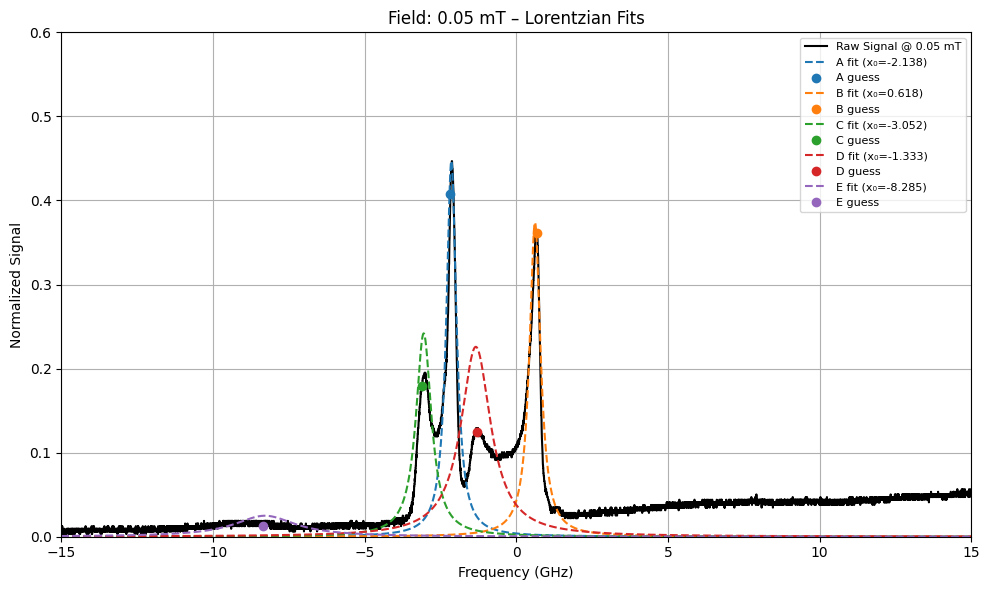

51.263333333333335

--- Fitting Lorentzians at B = 0.05 mT ---
  Trying A at B = 51.26 mT
    Guess: Gamma=0.3105, x0=-2.0815, scale=0.2175
    Bounds: [[np.float64(0.024837215234731022), np.float64(-8.38518938), np.float64(0.0121819820907169)]], [[np.float64(2.4837215234731023), np.float64(-8.285189379999998), np.float64(0.0974558567257352)]]
  Trying B at B = 51.26 mT
    Guess: Gamma=0.4435, x0=0.6239, scale=0.2515
    Bounds: [[np.float64(0.003104651904341367), np.float64(-2.1315334019999996), np.float64(0.054372522379284076)]], [[np.float64(0.3104651904341367), np.float64(-2.031533402), np.float64(0.4349801790342726)]]
  Trying C at B = 51.26 mT
    Guess: Gamma=0.7540, x0=-3.0573, scale=0.2148
    Bounds: [[np.float64(0.004435217006201988), np.float64(0.5739489722663087), np.float64(0.06287797991591015)]], [[np.float64(0.4435217006201988), np.float64(0.6739489722663088), np.float64(0.5030238393272812)]]
  Trying D at B = 51.26 mT
    Guess: Gamma=1.1975, x0=-1.3719, scale=0.2336


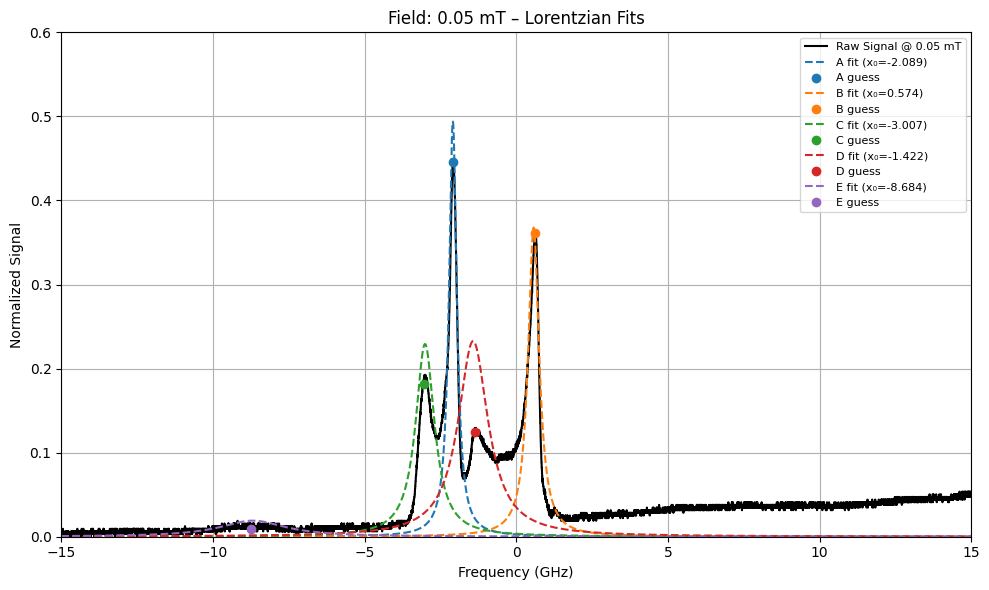

49.74666666666667

--- Fitting Lorentzians at B = 0.05 mT ---
  Trying A at B = 49.75 mT
    Guess: Gamma=0.3548, x0=-2.0815, scale=0.2336
    Bounds: [[np.float64(0.02661130203721182), np.float64(-8.784358911), np.float64(0.00999182425)]], [[np.float64(2.661130203721182), np.float64(-8.684358910999999), np.float64(0.079934594)]]
  Trying B at B = 49.75 mT
    Guess: Gamma=0.3992, x0=0.5796, scale=0.2279
    Bounds: [[np.float64(0.003548173604961562), np.float64(-2.1315334019999996), np.float64(0.05839830975)]], [[np.float64(0.3548173604961562), np.float64(-2.031533402), np.float64(0.467186478)]]
  Trying C at B = 49.75 mT
    Guess: Gamma=0.7983, x0=-3.0129, scale=0.2284
    Bounds: [[np.float64(0.0039916953055817925), np.float64(0.5295968022042892), np.float64(0.0569773142243742)]], [[np.float64(0.3991695305581793), np.float64(0.6295968022042893), np.float64(0.4558185137949936)]]
  Trying D at B = 49.75 mT
    Guess: Gamma=1.2419, x0=-1.3275, scale=0.2514
    Bounds: [[np.float64(0.0

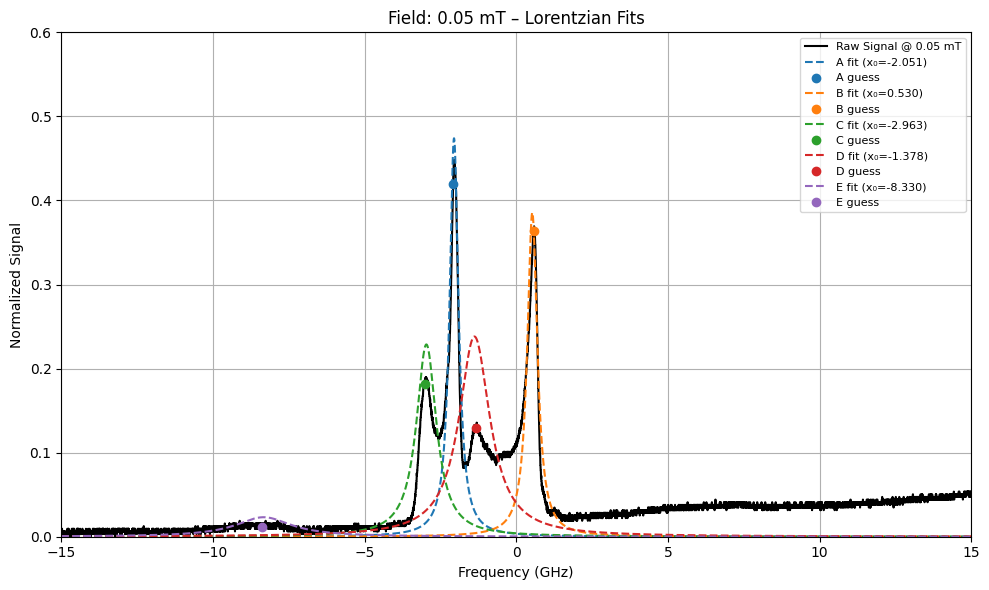

48.23

--- Fitting Lorentzians at B = 0.05 mT ---
  Trying A at B = 48.23 mT
    Guess: Gamma=0.3992, x0=-2.0372, scale=0.2681
    Bounds: [[np.float64(0.022619606731630066), np.float64(-8.429541550000001), np.float64(0.010309315881861524)]], [[np.float64(2.2619606731630064), np.float64(-8.32954155), np.float64(0.0824745270548922)]]
  Trying B at B = 48.23 mT
    Guess: Gamma=0.4435, x0=0.5352, scale=0.2530
    Bounds: [[np.float64(0.003991695305581757), np.float64(-2.0871812309999997), np.float64(0.06703227339491268)]], [[np.float64(0.3991695305581757), np.float64(-1.9871812309999999), np.float64(0.5362581871593014)]]
  Trying C at B = 48.23 mT
    Guess: Gamma=0.7096, x0=-3.0129, scale=0.1996
    Bounds: [[np.float64(0.004435217006201952), np.float64(0.4852446321422697), np.float64(0.06326109227536478)]], [[np.float64(0.4435217006201952), np.float64(0.5852446321422697), np.float64(0.5060887382029182)]]
  Trying D at B = 48.23 mT
    Guess: Gamma=1.2862, x0=-1.3275, scale=0.2647
    B

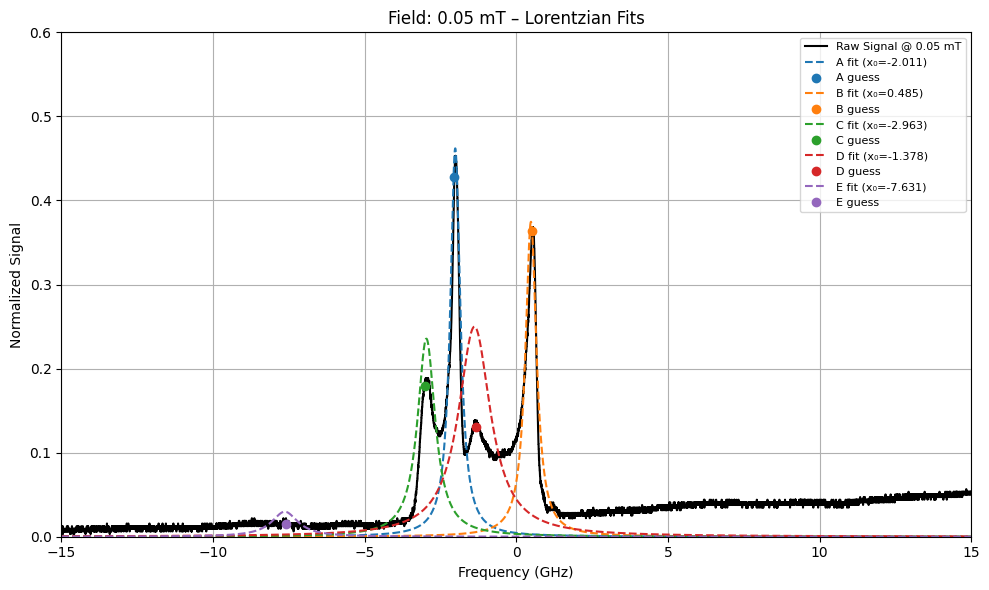

46.71333333333334

--- Fitting Lorentzians at B = 0.05 mT ---
  Trying A at B = 46.71 mT
    Guess: Gamma=0.3548, x0=-1.9928, scale=0.2436
    Bounds: [[np.float64(0.010644520814884758), np.float64(-7.631202489), np.float64(0.0062225645)]], [[np.float64(1.0644520814884757), np.float64(-7.531202489), np.float64(0.049780516)]]
  Trying B at B = 46.71 mT
    Guess: Gamma=0.4435, x0=0.4465, scale=0.2327
    Bounds: [[np.float64(0.003548173604961562), np.float64(-2.042829061), np.float64(0.060900946157624675)]], [[np.float64(0.3548173604961562), np.float64(-1.9428290609999999), np.float64(0.4872075692609974)]]
  Trying C at B = 46.71 mT
    Guess: Gamma=0.6653, x0=-2.8799, scale=0.1906
    Bounds: [[np.float64(0.004435217006201952), np.float64(0.3965402920182306), np.float64(0.058183574031599225)]], [[np.float64(0.4435217006201952), np.float64(0.4965402920182306), np.float64(0.4654685922527938)]]
  Trying D at B = 46.71 mT
    Guess: Gamma=1.1088, x0=-1.3719, scale=0.2283
    Bounds: [[np.f

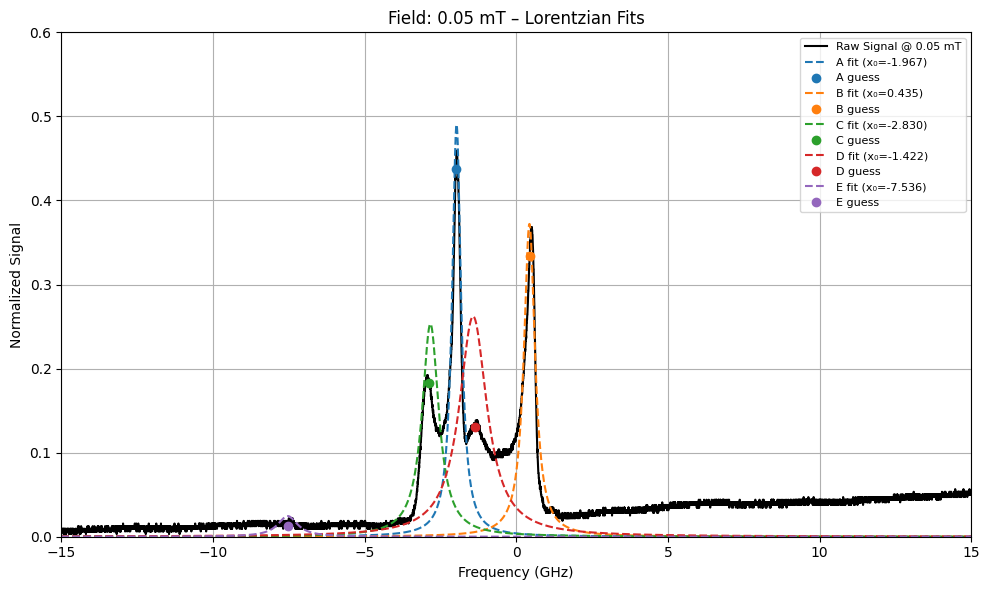

45.19666666666667

--- Fitting Lorentzians at B = 0.05 mT ---
  Trying A at B = 45.20 mT
    Guess: Gamma=0.3105, x0=-1.9485, scale=0.2158
    Bounds: [[np.float64(0.00798339061), np.float64(-7.586850319), np.float64(0.00385472475)]], [[np.float64(0.798339061), np.float64(-7.486850319), np.float64(0.030837798)]]
  Trying B at B = 45.20 mT
    Guess: Gamma=0.4879, x0=0.4022, scale=0.2531
    Bounds: [[np.float64(0.003104651904341367), np.float64(-1.9984768910000001), np.float64(0.053956763530878075)]], [[np.float64(0.3104651904341367), np.float64(-1.898476891), np.float64(0.4316541082470246)]]
  Trying C at B = 45.20 mT
    Guess: Gamma=0.5766, x0=-2.9242, scale=0.1662
    Bounds: [[np.float64(0.004878738706822147), np.float64(0.35218812195621113), np.float64(0.06328682400720882)]], [[np.float64(0.4878738706822147), np.float64(0.4521881219562111), np.float64(0.5062945920576706)]]
  Trying D at B = 45.20 mT
    Guess: Gamma=1.3749, x0=-1.5050, scale=0.2958
    Bounds: [[np.float64(0.0057

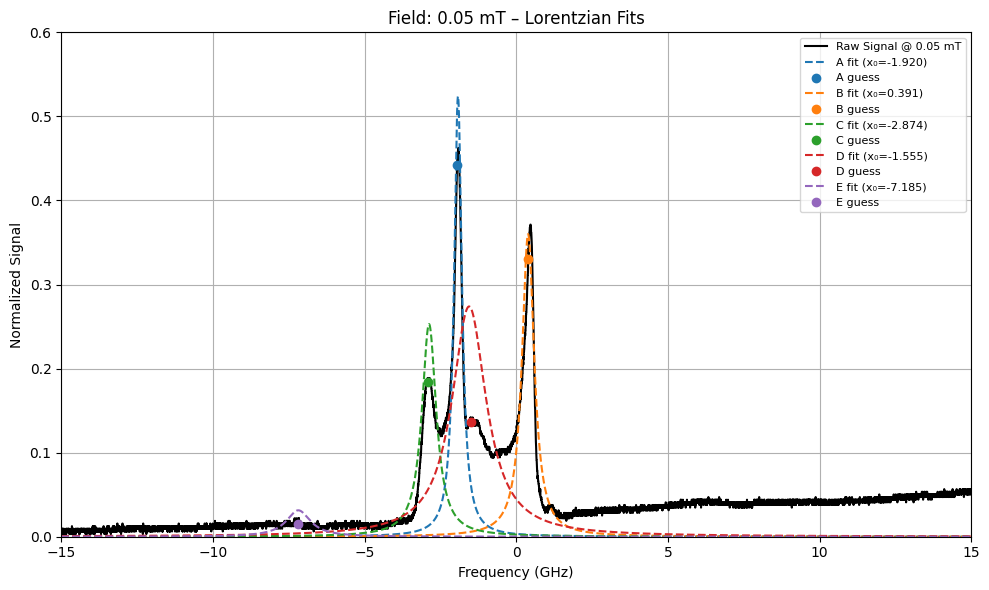

43.68000000000001

--- Fitting Lorentzians at B = 0.04 mT ---
  Trying A at B = 43.68 mT
    Guess: Gamma=0.3992, x0=-1.9041, scale=0.2810
    Bounds: [[np.float64(0.009757477413644333), np.float64(-7.232032959), np.float64(0.0060222035)]], [[np.float64(0.9757477413644332), np.float64(-7.132032959), np.float64(0.048177628)]]
  Trying B at B = 43.68 mT
    Guess: Gamma=0.4435, x0=0.3578, scale=0.2273
    Bounds: [[np.float64(0.0039916953055817925), np.float64(-1.9541247210000001), np.float64(0.07025294639442828)]], [[np.float64(0.3991695305581793), np.float64(-1.854124721), np.float64(0.5620235711554262)]]
  Trying C at B = 43.68 mT
    Guess: Gamma=0.5322, x0=-2.9686, scale=0.1391
    Bounds: [[np.float64(0.004435217006201952), np.float64(0.3078359518941916), np.float64(0.0568337712040373)]], [[np.float64(0.4435217006201952), np.float64(0.4078359518941916), np.float64(0.4546701696322984)]]
  Trying D at B = 43.68 mT
    Guess: Gamma=1.5523, x0=-1.5493, scale=0.3540
    Bounds: [[np.flo

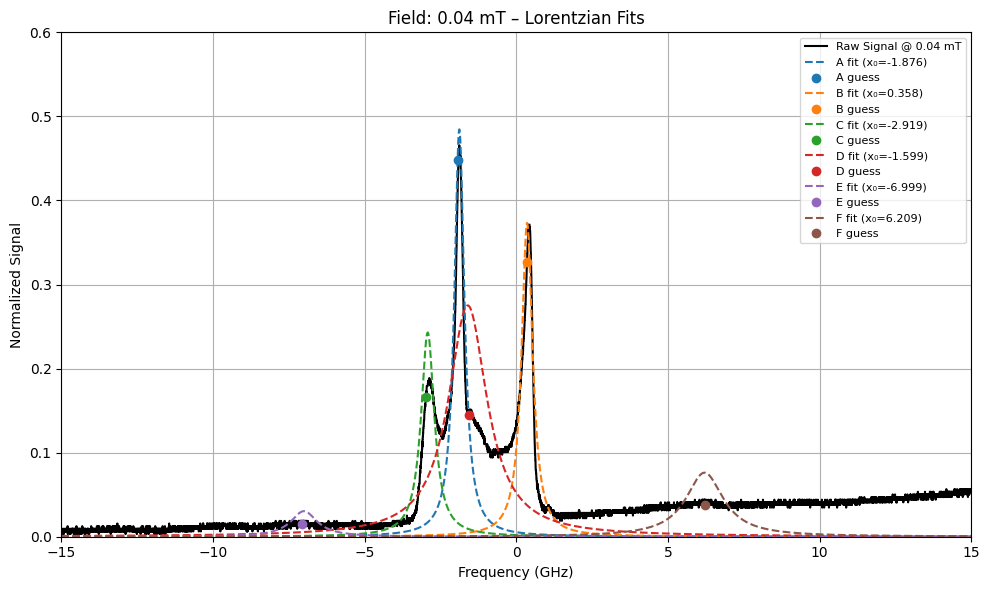

42.16333333333333

--- Fitting Lorentzians at B = 0.04 mT ---
  Trying A at B = 42.16 mT
    Guess: Gamma=0.3548, x0=-1.8598, scale=0.2559
    Bounds: [[np.float64(0.01507973782108671), np.float64(6.162322400080794), np.float64(0.02256184375)]], [[np.float64(1.507973782108671), np.float64(6.2623224000807935), np.float64(0.18049475)]]
  Trying B at B = 42.16 mT
    Guess: Gamma=0.4435, x0=0.3578, scale=0.2500
    Bounds: [[np.float64(0.003548173604961597), np.float64(-1.909772551), np.float64(0.0639862723002035)]], [[np.float64(0.3548173604961597), np.float64(-1.809772551), np.float64(0.511890178401628)]]
  Trying C at B = 42.16 mT
    Guess: Gamma=0.6653, x0=-2.8355, scale=0.1918
    Bounds: [[np.float64(0.004435217006201952), np.float64(0.3078359518941916), np.float64(0.06249062665180485)]], [[np.float64(0.4435217006201952), np.float64(0.4078359518941916), np.float64(0.4999250132144388)]]
  Trying D at B = 42.16 mT
    Guess: Gamma=1.5080, x0=-1.5050, scale=0.3730
    Bounds: [[np.flo

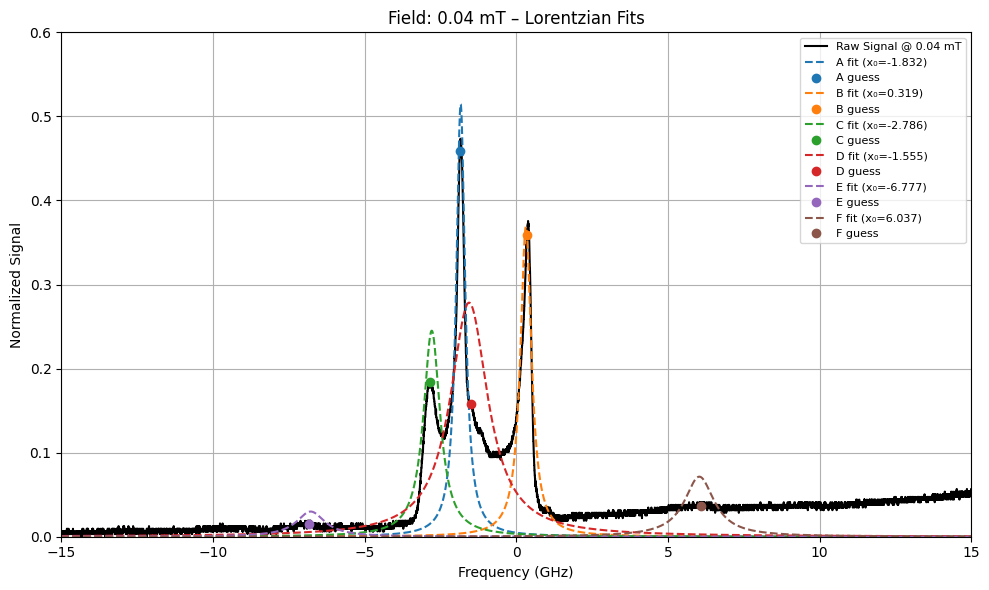

40.64666666666667

--- Fitting Lorentzians at B = 0.04 mT ---
  Trying A at B = 40.65 mT
    Guess: Gamma=0.4435, x0=-1.8154, scale=0.3288
    Bounds: [[np.float64(0.011975085916745344), np.float64(6.029265889894735), np.float64(0.017212608)]], [[np.float64(1.1975085916745345), np.float64(6.129265889894735), np.float64(0.137700864)]]
  Trying B at B = 40.65 mT
    Guess: Gamma=0.4435, x0=0.3135, scale=0.2495
    Bounds: [[np.float64(0.004435217006201988), np.float64(-1.865420381), np.float64(0.08221005328734317)]], [[np.float64(0.4435217006201988), np.float64(-1.765420381), np.float64(0.6576804262987453)]]
  Trying C at B = 40.65 mT
    Guess: Gamma=0.5766, x0=-2.8355, scale=0.1652
    Bounds: [[np.float64(0.004435217006201952), np.float64(0.263483781832172), np.float64(0.062367496480025)]], [[np.float64(0.4435217006201952), np.float64(0.363483781832172), np.float64(0.4989399718402)]]
  Trying E at B = 40.65 mT
    Guess: Gamma=1.0645, x0=-6.6498, scale=0.0285
    Bounds: [[np.float64(

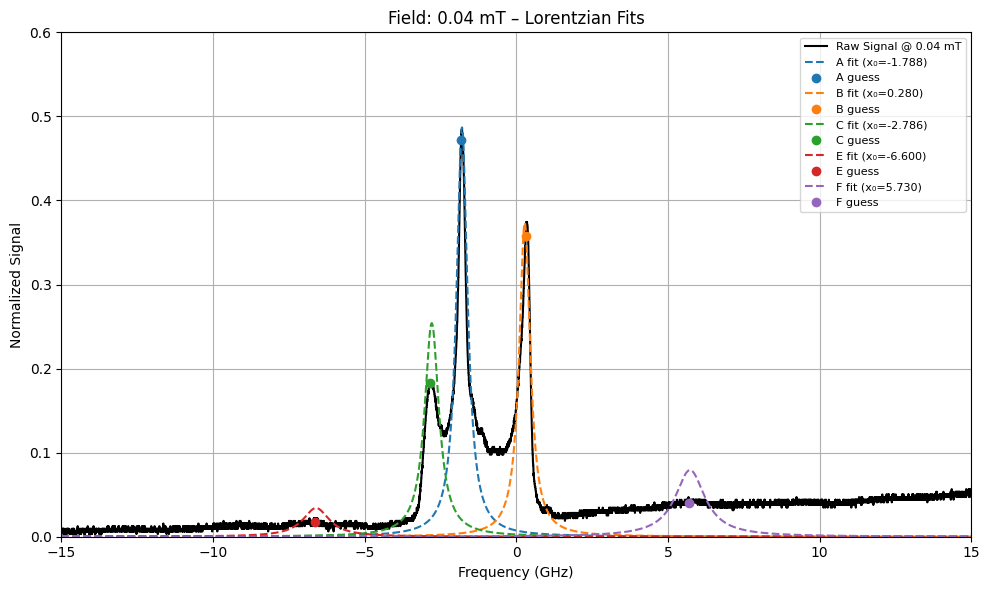

39.13

--- Fitting Lorentzians at B = 0.04 mT ---
  Trying A at B = 39.13 mT
    Guess: Gamma=0.3548, x0=-1.8154, scale=0.2359
    Bounds: [[np.float64(0.011975085916745308), np.float64(5.63009635933656), np.float64(0.01892110775)]], [[np.float64(1.1975085916745307), np.float64(5.730096359336559), np.float64(0.151368862)]]
  Trying B at B = 39.13 mT
    Guess: Gamma=0.4435, x0=0.2691, scale=0.2461
    Bounds: [[np.float64(0.003548173604961597), np.float64(-1.865420381), np.float64(0.05897920623513835)]], [[np.float64(0.3548173604961597), np.float64(-1.765420381), np.float64(0.4718336498811068)]]
  Trying C at B = 39.13 mT
    Guess: Gamma=0.7096, x0=-2.7912, scale=0.2004
    Bounds: [[np.float64(0.004435217006201952), np.float64(0.2191316117701525), np.float64(0.06151302864915972)]], [[np.float64(0.4435217006201952), np.float64(0.3191316117701525), np.float64(0.4921042291932778)]]
  Trying E at B = 39.13 mT
    Guess: Gamma=1.0201, x0=-6.5168, scale=0.0232
    Bounds: [[np.float64(0.00

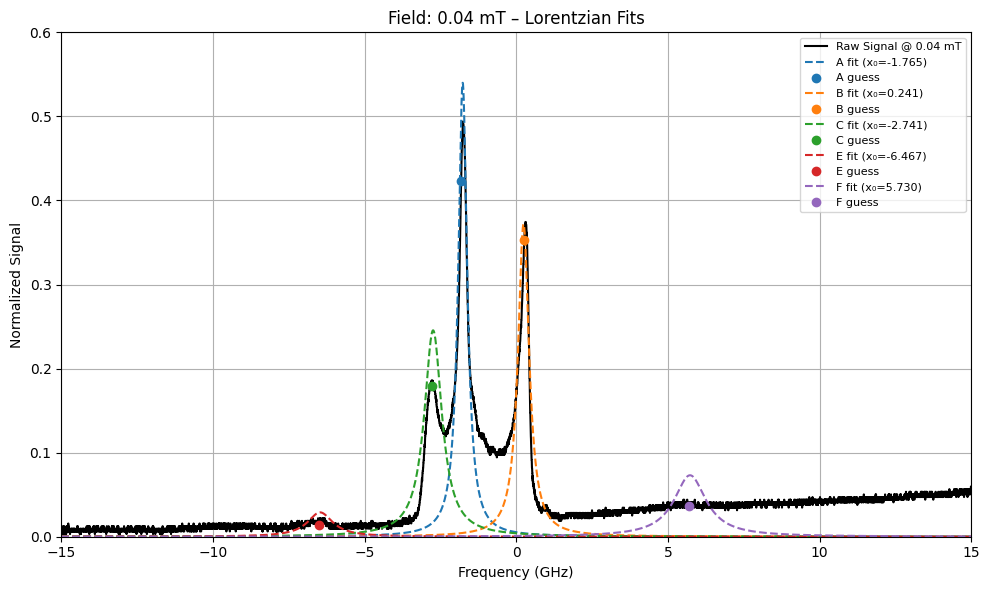

37.61333333333334

--- Fitting Lorentzians at B = 0.04 mT ---
  Trying A at B = 37.61 mT
    Guess: Gamma=0.4435, x0=-1.6824, scale=0.3411
    Bounds: [[np.float64(0.012862129317985698), np.float64(5.63009635933656), np.float64(0.018464098)]], [[np.float64(1.2862129317985698), np.float64(5.730096359336559), np.float64(0.147712784)]]
  Trying B at B = 37.61 mT
    Guess: Gamma=0.4435, x0=0.2248, scale=0.2456
    Bounds: [[np.float64(0.004435217006201988), np.float64(-1.732363871), np.float64(0.08526399116320472)]], [[np.float64(0.4435217006201988), np.float64(-1.632363871), np.float64(0.6821119293056378)]]
  Trying C at B = 37.61 mT
    Guess: Gamma=0.6653, x0=-2.7912, scale=0.1854
    Bounds: [[np.float64(0.004435217006201952), np.float64(0.17477944170813298), np.float64(0.06140323528000065)]], [[np.float64(0.4435217006201952), np.float64(0.274779441708133), np.float64(0.4912258822400052)]]
  Trying E at B = 37.61 mT
    Guess: Gamma=0.9757, x0=-6.3393, scale=0.0226
    Bounds: [[np.fl

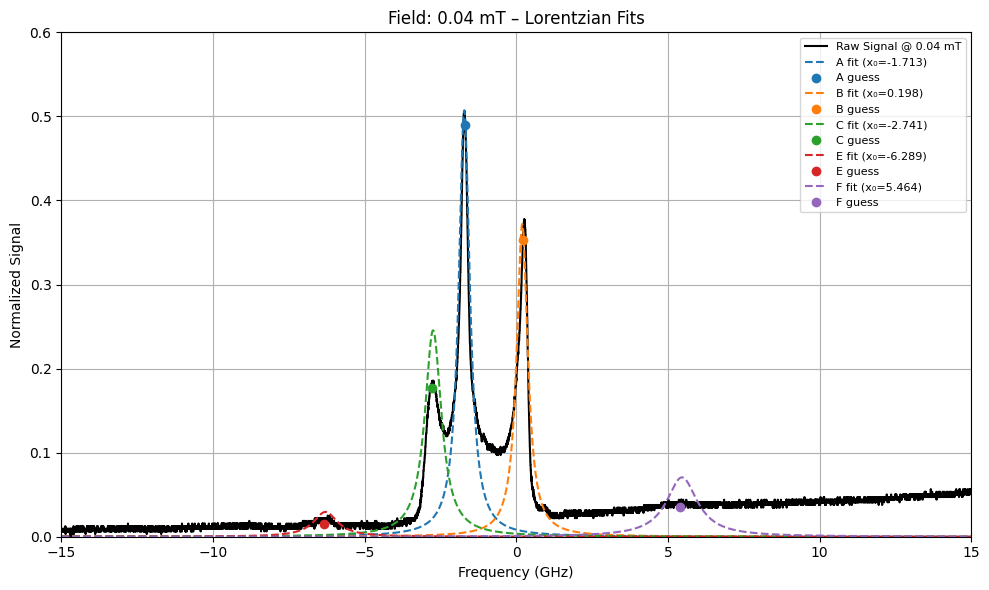

36.09666666666666

--- Fitting Lorentzians at B = 0.04 mT ---
  Trying A at B = 36.10 mT
    Guess: Gamma=0.3105, x0=-1.6824, scale=0.2482
    Bounds: [[np.float64(0.012418607617365539), np.float64(5.363983338964439), np.float64(0.017216475)]], [[np.float64(1.2418607617365538), np.float64(5.4639833389644386), np.float64(0.1377318)]]
  Trying B at B = 36.10 mT
    Guess: Gamma=0.4435, x0=0.2248, scale=0.2617
    Bounds: [[np.float64(0.0031046519043414025), np.float64(-1.732363871), np.float64(0.062055369277632576)]], [[np.float64(0.3104651904341402), np.float64(-1.632363871), np.float64(0.4964429542210606)]]
  Trying C at B = 36.10 mT
    Guess: Gamma=0.6209, x0=-2.7468, scale=0.1721
    Bounds: [[np.float64(0.004435217006201952), np.float64(0.17477944170813298), np.float64(0.06541566275025827)]], [[np.float64(0.4435217006201952), np.float64(0.274779441708133), np.float64(0.5233253020020662)]]
  Trying E at B = 36.10 mT
    Guess: Gamma=0.7540, x0=-6.1176, scale=0.0179
    Bounds: [[np.

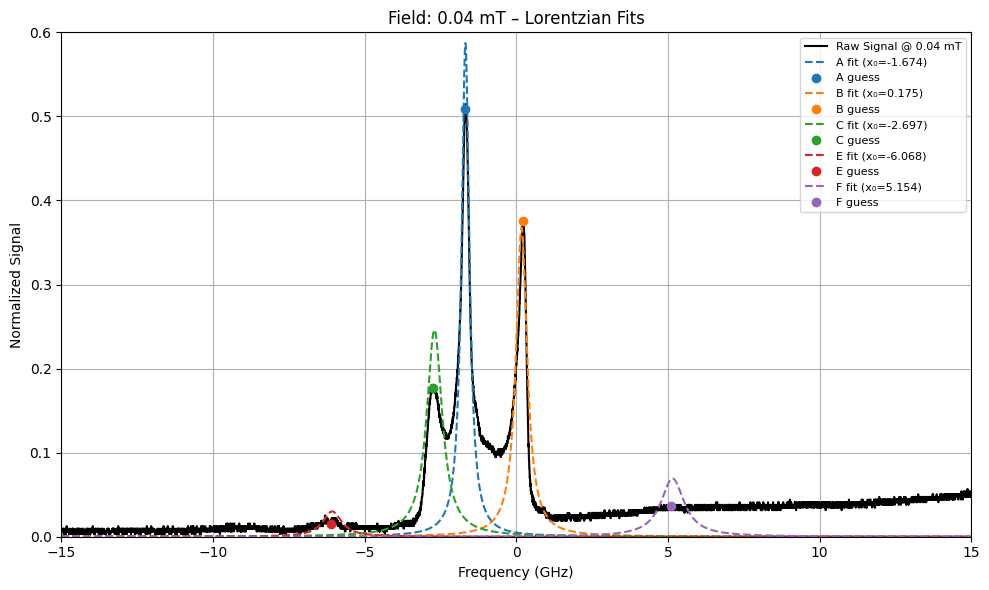

34.58

--- Fitting Lorentzians at B = 0.03 mT ---
  Trying A at B = 34.58 mT
    Guess: Gamma=0.4879, x0=-1.6380, scale=0.3987
    Bounds: [[np.float64(0.009313955713024137), np.float64(5.053518148530302), np.float64(0.01333638325)]], [[np.float64(0.9313955713024136), np.float64(5.153518148530302), np.float64(0.106691066)]]
  Trying B at B = 34.58 mT
    Guess: Gamma=0.3992, x0=0.1804, scale=0.2367
    Bounds: [[np.float64(0.004878738706822184), np.float64(-1.688011701), np.float64(0.09967166069623268)]], [[np.float64(0.4878738706822183), np.float64(-1.5880117009999999), np.float64(0.7973732855698614)]]
  Trying C at B = 34.58 mT
    Guess: Gamma=0.6653, x0=-2.7912, scale=0.1766
    Bounds: [[np.float64(0.003991695305581757), np.float64(0.1304272716461135), np.float64(0.05916820226256965)]], [[np.float64(0.3991695305581757), np.float64(0.23042727164611349), np.float64(0.4733456181005572)]]
  Trying E at B = 34.58 mT
    Guess: Gamma=0.7096, x0=-6.0289, scale=0.0198
    Bounds: [[np.flo

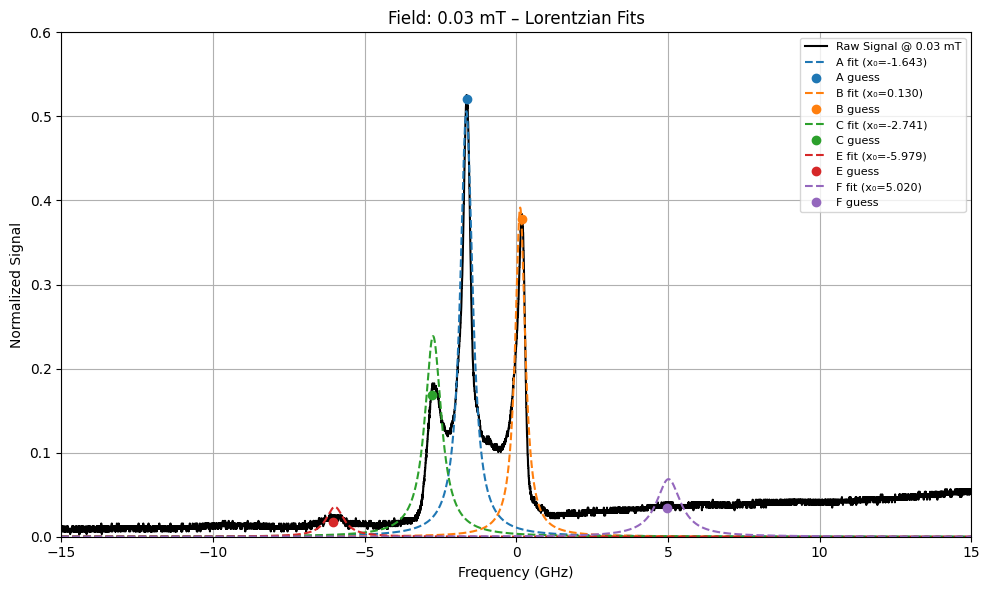

33.06333333333333

--- Fitting Lorentzians at B = 0.03 mT ---
  Trying A at B = 33.06 mT
    Guess: Gamma=0.3992, x0=-1.6380, scale=0.3081
    Bounds: [[np.float64(0.009757477413644333), np.float64(4.9204616383442445), np.float64(0.01312850571754655)]], [[np.float64(0.9757477413644332), np.float64(5.020461638344244), np.float64(0.1050280457403724)]]
  Trying B at B = 33.06 mT
    Guess: Gamma=0.3548, x0=0.0917, scale=0.1907
    Bounds: [[np.float64(0.0039916953055817925), np.float64(-1.688011701), np.float64(0.07702560615386637)]], [[np.float64(0.3991695305581793), np.float64(-1.5880117009999999), np.float64(0.616204849230931)]]
  Trying C at B = 33.06 mT
    Guess: Gamma=0.6209, x0=-2.7025, scale=0.1701
    Bounds: [[np.float64(0.003548173604961562), np.float64(0.04172293199999999), np.float64(0.04767699120602495)]], [[np.float64(0.3548173604961562), np.float64(0.141722932), np.float64(0.3814159296481996)]]
  Trying E at B = 33.06 mT
    Guess: Gamma=0.6209, x0=-5.8515, scale=0.0201
 

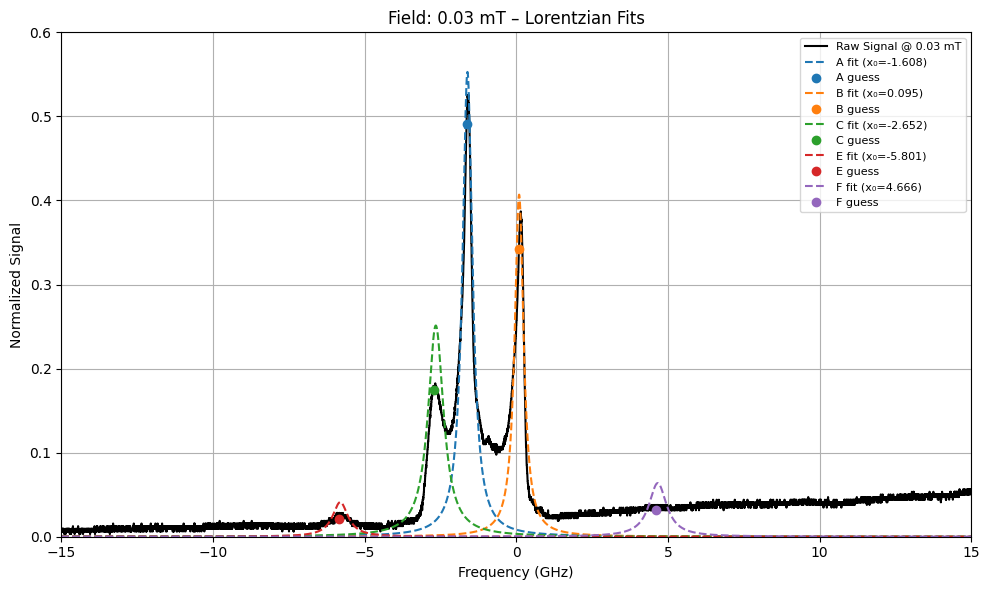

31.546666666666667

--- Fitting Lorentzians at B = 0.03 mT ---
  Trying A at B = 31.55 mT
    Guess: Gamma=0.4879, x0=-1.5937, scale=0.3802
    Bounds: [[np.float64(0.00709634721), np.float64(4.565644277848084), np.float64(0.0088917850357072)]], [[np.float64(0.709634721), np.float64(4.6656442778480836), np.float64(0.0711342802856576)]]
  Trying B at B = 31.55 mT
    Guess: Gamma=0.3992, x0=0.0917, scale=0.2376
    Bounds: [[np.float64(0.004878738706822184), np.float64(-1.643659531), np.float64(0.09504418004240353)]], [[np.float64(0.4878738706822183), np.float64(-1.5436595309999999), np.float64(0.7603534403392282)]]
  Trying C at B = 31.55 mT
    Guess: Gamma=0.6653, x0=-2.7025, scale=0.1783
    Bounds: [[np.float64(0.0039916953055817925), np.float64(0.04172293199999999), np.float64(0.059412223906975176)]], [[np.float64(0.3991695305581793), np.float64(0.141722932), np.float64(0.4752977912558014)]]
  Trying E at B = 31.55 mT
    Guess: Gamma=0.7096, x0=-5.6741, scale=0.0235
    Bounds: [

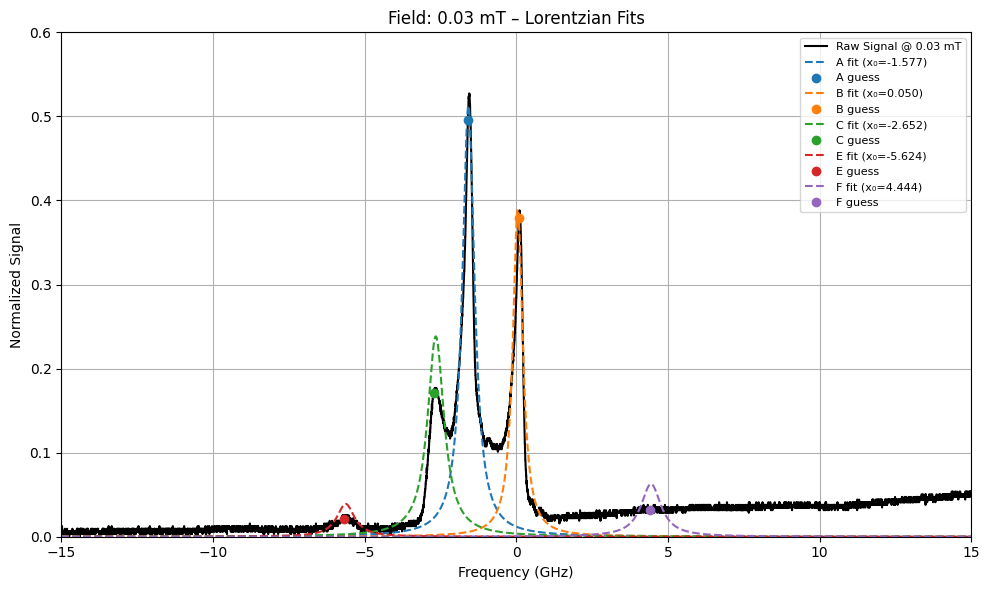

30.03

--- Fitting Lorentzians at B = 0.03 mT ---
  Trying A at B = 30.03 mT
    Guess: Gamma=0.5766, x0=-1.5493, scale=0.4556
    Bounds: [[np.float64(0.00798339061), np.float64(4.343883427537986), np.float64(0.009842002020015126)]], [[np.float64(0.798339061), np.float64(4.443883427537986), np.float64(0.078736016160121)]]
  Trying B at B = 30.03 mT
    Guess: Gamma=0.3548, x0=0.0474, scale=0.2111
    Bounds: [[np.float64(0.005765782108062574), np.float64(-1.5993073610000001), np.float64(0.1139015249559194)]], [[np.float64(0.5765782108062574), np.float64(-1.499307361), np.float64(0.9112121996473552)]]
  Trying C at B = 30.03 mT
    Guess: Gamma=0.6209, x0=-2.7025, scale=0.1645
    Bounds: [[np.float64(0.003548173604961597), np.float64(-0.0026292390000000054), np.float64(0.05276780162994225)]], [[np.float64(0.3548173604961597), np.float64(0.097370761), np.float64(0.422142413039538)]]
  Trying E at B = 30.03 mT
    Guess: Gamma=0.5322, x0=-5.4523, scale=0.0196
    Bounds: [[np.float64(0.

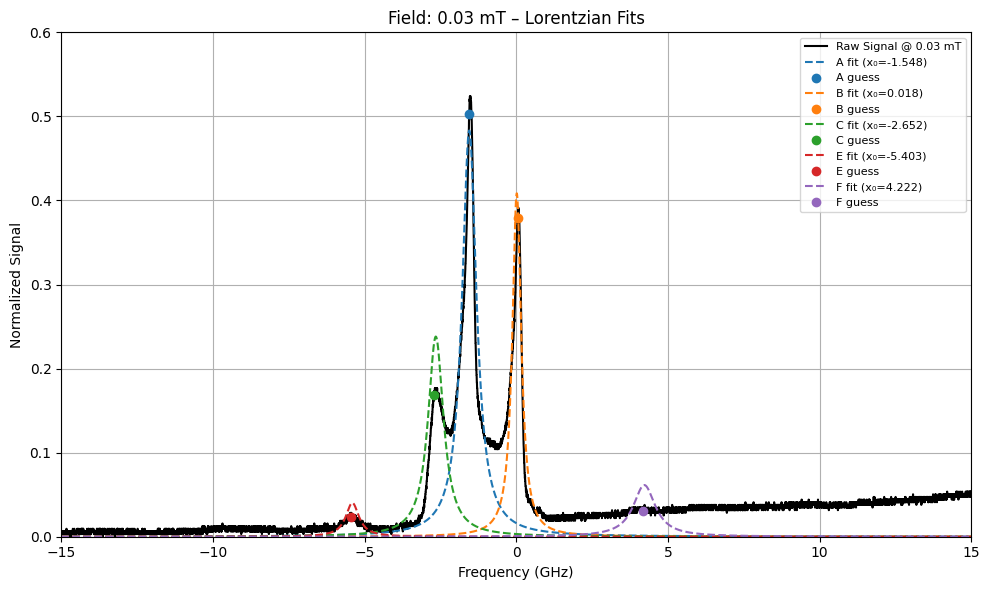

28.513333333333332

--- Fitting Lorentzians at B = 0.03 mT ---
  Trying A at B = 28.51 mT
    Guess: Gamma=0.4879, x0=-1.5493, scale=0.3362
    Bounds: [[np.float64(0.00887043401), np.float64(4.122122577227889), np.float64(0.0107062205)]], [[np.float64(0.887043401), np.float64(4.222122577227888), np.float64(0.085649764)]]
  Trying B at B = 28.51 mT
    Guess: Gamma=0.3992, x0=0.0030, scale=0.2386
    Bounds: [[np.float64(0.004878738706822184), np.float64(-1.5993073610000001), np.float64(0.08403919127142885)]], [[np.float64(0.4878738706822183), np.float64(-1.499307361), np.float64(0.6723135301714308)]]
  Trying C at B = 28.51 mT
    Guess: Gamma=0.6209, x0=-2.6138, scale=0.1697
    Bounds: [[np.float64(0.0039916953055817925), np.float64(-0.046981409), np.float64(0.059646828874328324)]], [[np.float64(0.3991695305581793), np.float64(0.053018591000000004), np.float64(0.4771746309946266)]]
  Trying E at B = 28.51 mT
    Guess: Gamma=0.6209, x0=-5.2305, scale=0.0239
    Bounds: [[np.float64(

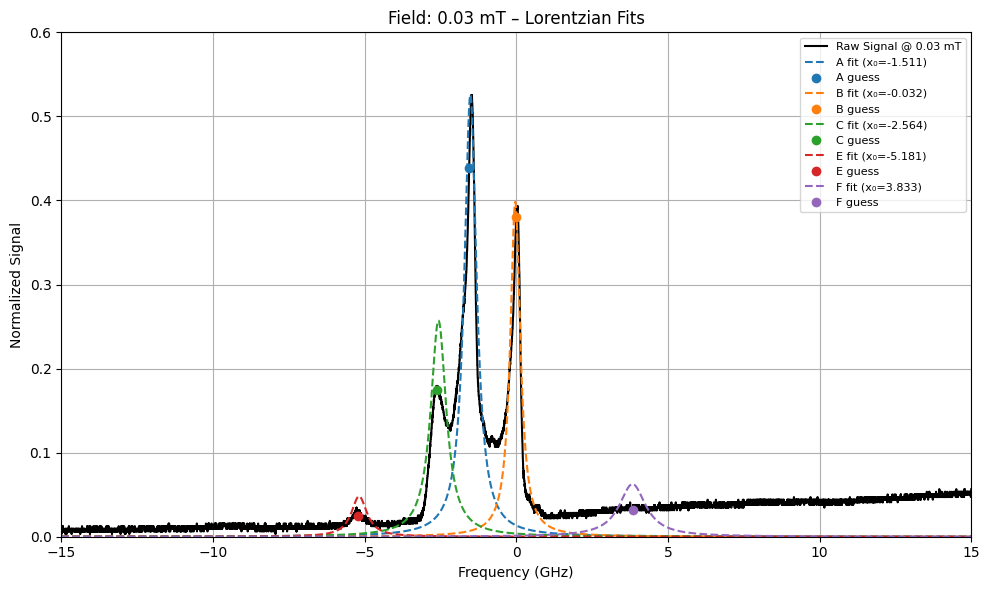

26.99666666666667

--- Fitting Lorentzians at B = 0.03 mT ---
  Trying A at B = 27.00 mT
    Guess: Gamma=0.5322, x0=-1.5050, scale=0.3675
    Bounds: [[np.float64(0.01064452081488472), np.float64(3.811657386793748), np.float64(0.013096490721357474)]], [[np.float64(1.064452081488472), np.float64(3.9116573867937476), np.float64(0.1047719257708598)]]
  Trying B at B = 27.00 mT
    Guess: Gamma=0.4879, x0=-0.0413, scale=0.2877
    Bounds: [[np.float64(0.005322260407442379), np.float64(-1.5549551910000001), np.float64(0.0918868044320546)]], [[np.float64(0.5322260407442378), np.float64(-1.454955191), np.float64(0.7350944354564368)]]
  Trying C at B = 27.00 mT
    Guess: Gamma=0.7096, x0=-2.5694, scale=0.1897
    Bounds: [[np.float64(0.004878738706822184), np.float64(-0.091333579), np.float64(0.07193327375)]], [[np.float64(0.4878738706822183), np.float64(0.008666421), np.float64(0.57546619)]]
  Trying E at B = 27.00 mT
    Guess: Gamma=0.4879, x0=-5.0975, scale=0.0181
    Bounds: [[np.float6

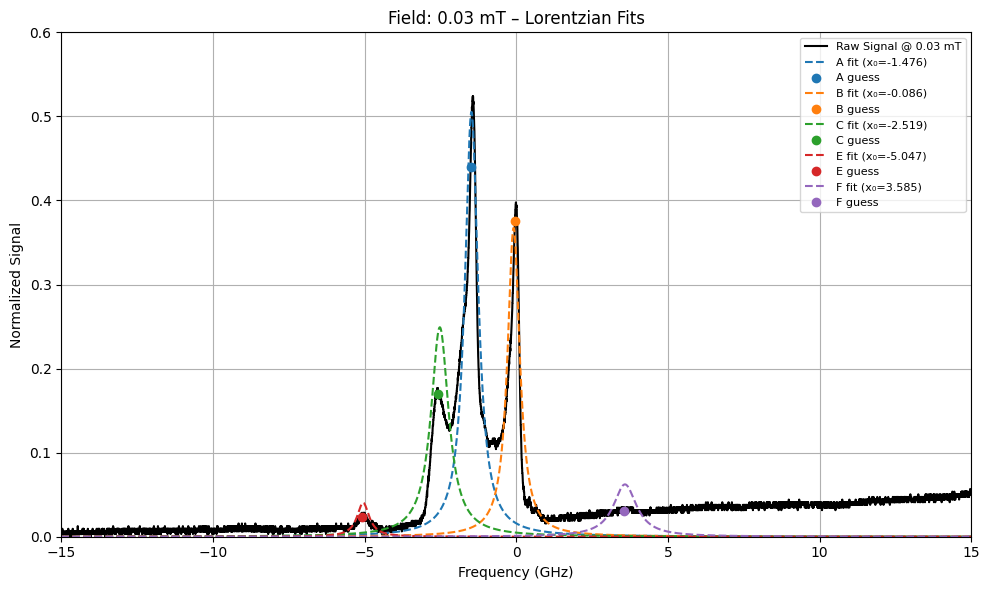

25.480000000000004

--- Fitting Lorentzians at B = 0.03 mT ---
  Trying A at B = 25.48 mT
    Guess: Gamma=0.5766, x0=-1.4163, scale=0.4613
    Bounds: [[np.float64(0.009313955713024173), np.float64(3.501192196359612), np.float64(0.0113842)]], [[np.float64(0.9313955713024172), np.float64(3.601192196359612), np.float64(0.0910736)]]
  Trying B at B = 25.48 mT
    Guess: Gamma=0.4435, x0=-0.0857, scale=0.2619
    Bounds: [[np.float64(0.005765782108062574), np.float64(-1.466250851), np.float64(0.11533133657012287)]], [[np.float64(0.5765782108062574), np.float64(-1.366250851), np.float64(0.922650692560983)]]
  Trying C at B = 25.48 mT
    Guess: Gamma=0.6209, x0=-2.5694, scale=0.1661
    Bounds: [[np.float64(0.004435217006201988), np.float64(-0.13568574900000002), np.float64(0.06546617784804715)]], [[np.float64(0.4435217006201988), np.float64(-0.035685749), np.float64(0.5237294227843772)]]
  Trying E at B = 25.48 mT
    Guess: Gamma=0.4435, x0=-4.9201, scale=0.0159
    Bounds: [[np.float64(

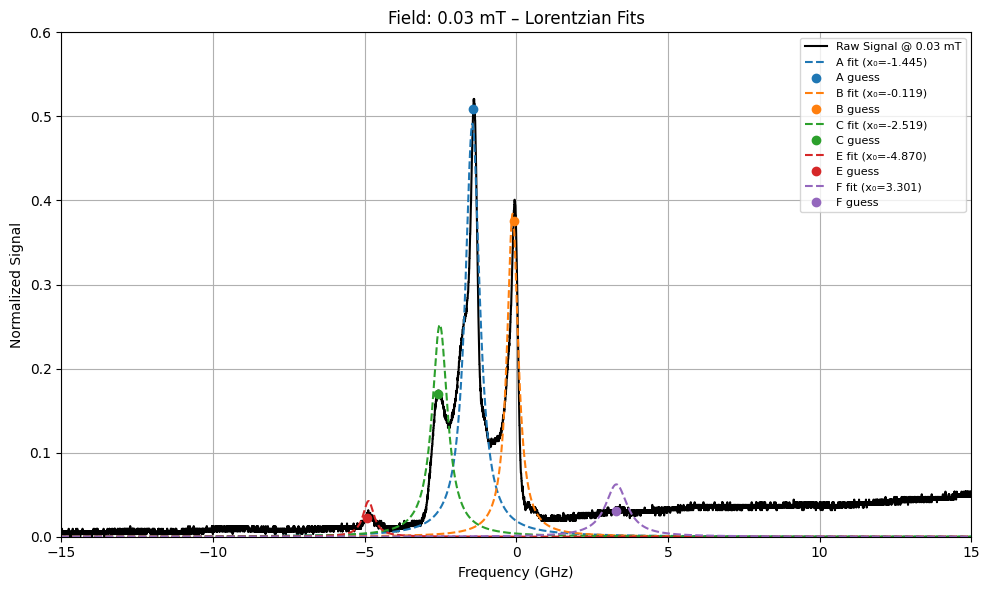

23.96333333333334

--- Fitting Lorentzians at B = 0.02 mT ---
  Trying A at B = 23.96 mT
    Guess: Gamma=0.5322, x0=-1.4163, scale=0.3766
    Bounds: [[np.float64(0.00887043401), np.float64(3.2350791759874946), np.float64(0.01084780175)]], [[np.float64(0.887043401), np.float64(3.3350791759874943), np.float64(0.086782414)]]
  Trying B at B = 23.96 mT
    Guess: Gamma=0.5322, x0=-0.1744, scale=0.2663
    Bounds: [[np.float64(0.005322260407442343), np.float64(-1.466250851), np.float64(0.09414757222697852)]], [[np.float64(0.5322260407442343), np.float64(-1.366250851), np.float64(0.7531805778158281)]]
  Trying C at B = 23.96 mT
    Guess: Gamma=0.7540, x0=-2.5694, scale=0.1996
    Bounds: [[np.float64(0.005322260407442379), np.float64(-0.22439008900000001), np.float64(0.06657702247207557)]], [[np.float64(0.5322260407442378), np.float64(-0.124390089), np.float64(0.5326161797766046)]]
  Trying E at B = 23.96 mT
    Guess: Gamma=0.4435, x0=-4.6983, scale=0.0138
    Bounds: [[np.float64(0.0075

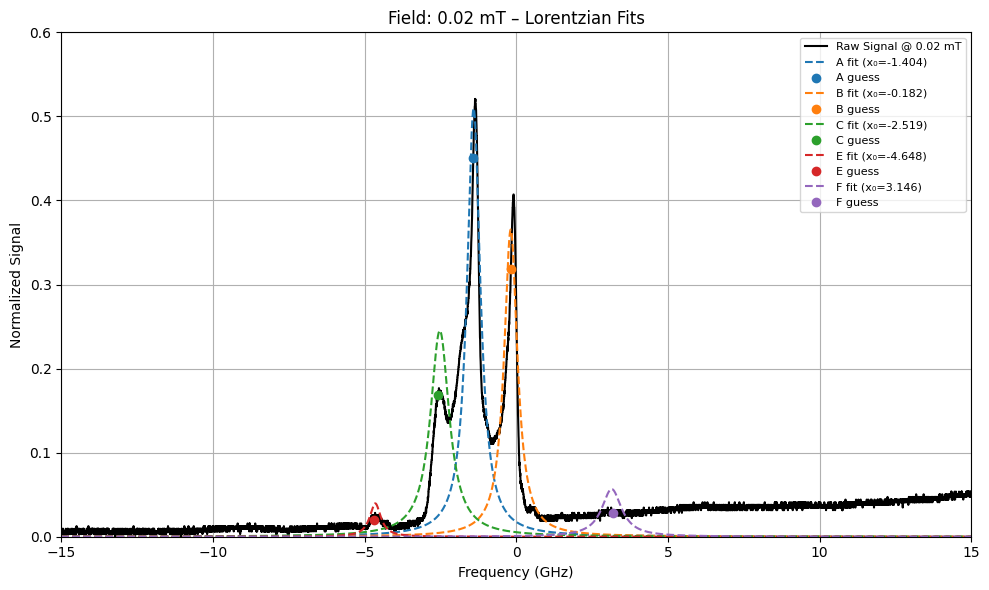

22.446666666666665

--- Fitting Lorentzians at B = 0.02 mT ---
  Trying A at B = 22.45 mT
    Guess: Gamma=0.4435, x0=-1.3275, scale=0.3531
    Bounds: [[np.float64(0.00798339061), np.float64(3.1463748358634556), np.float64(0.00888777820417175)]], [[np.float64(0.798339061), np.float64(3.246374835863455), np.float64(0.071102225633374)]]
  Trying B at B = 22.45 mT
    Guess: Gamma=0.3992, x0=-0.1300, scale=0.2543
    Bounds: [[np.float64(0.004435217006201952), np.float64(-1.37754651), np.float64(0.08828107146657135)]], [[np.float64(0.4435217006201952), np.float64(-1.2775465099999999), np.float64(0.7062485717325708)]]
  Trying C at B = 22.45 mT
    Guess: Gamma=0.6653, x0=-2.5251, scale=0.1773
    Bounds: [[np.float64(0.0039916953055817925), np.float64(-0.180037919), np.float64(0.06356606738142077)]], [[np.float64(0.3991695305581793), np.float64(-0.080037919), np.float64(0.5085285390513662)]]
  Trying E at B = 22.45 mT
    Guess: Gamma=0.6653, x0=-4.4322, scale=0.0202
    Bounds: [[np.flo

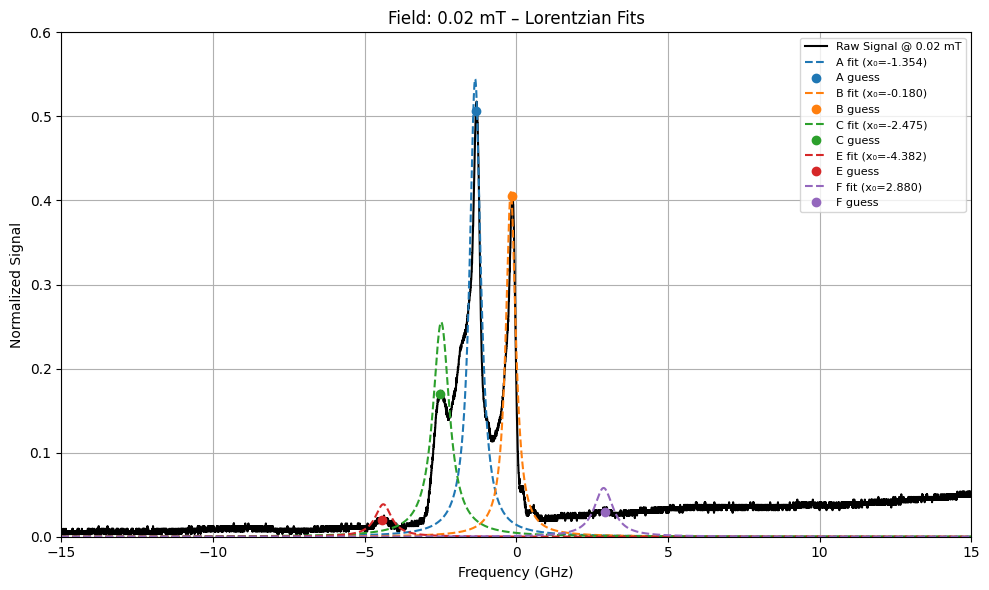

20.93

--- Fitting Lorentzians at B = 0.02 mT ---
  Trying A at B = 20.93 mT
    Guess: Gamma=0.4435, x0=-1.2832, scale=0.3536
    Bounds: [[np.float64(0.0075398689105433195), np.float64(2.880261815491335), np.float64(0.00858622825)]], [[np.float64(0.7539868910543319), np.float64(2.9802618154913345), np.float64(0.068689826)]]
  Trying B at B = 20.93 mT
    Guess: Gamma=0.4435, x0=-0.1744, scale=0.2853
    Bounds: [[np.float64(0.004435217006201952), np.float64(-1.3331943400000001), np.float64(0.08839604702345308)]], [[np.float64(0.4435217006201952), np.float64(-1.23319434), np.float64(0.7071683761876246)]]
  Trying C at B = 20.93 mT
    Guess: Gamma=0.5322, x0=-2.5251, scale=0.1379
    Bounds: [[np.float64(0.004435217006201988), np.float64(-0.22439008900000001), np.float64(0.07131971913252855)]], [[np.float64(0.4435217006201988), np.float64(-0.124390089), np.float64(0.5705577530602284)]]
  Trying E at B = 20.93 mT
    Guess: Gamma=0.6209, x0=-4.2104, scale=0.0168
    Bounds: [[np.float6

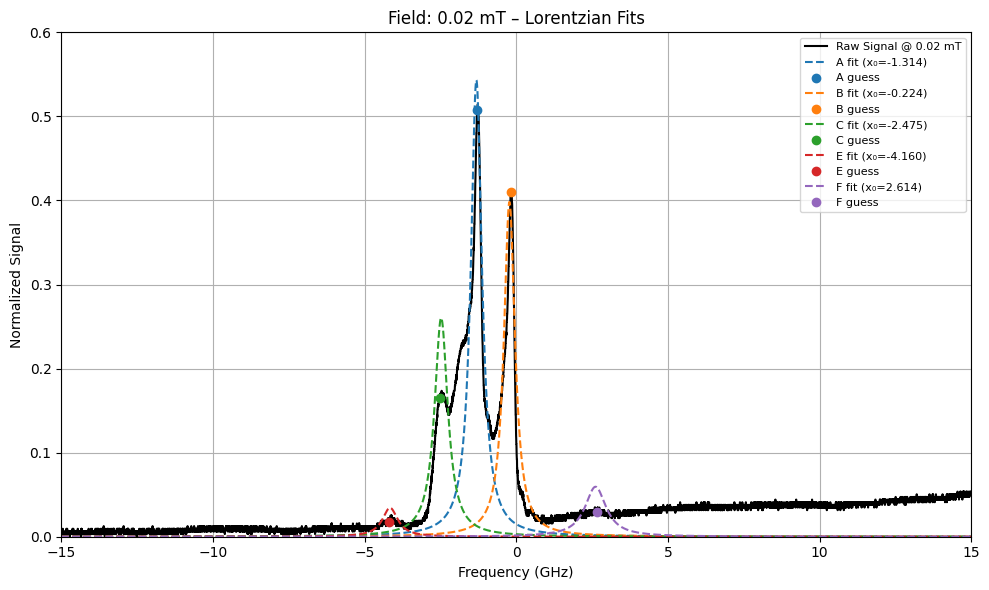

19.41333333333333

--- Fitting Lorentzians at B = 0.02 mT ---
  Trying A at B = 19.41 mT
    Guess: Gamma=0.4435, x0=-1.2388, scale=0.3554
    Bounds: [[np.float64(0.008426912311783745), np.float64(2.6141487951192173), np.float64(0.0098365815858498)]], [[np.float64(0.8426912311783745), np.float64(2.714148795119217), np.float64(0.0786926526867984)]]
  Trying B at B = 19.41 mT
    Guess: Gamma=0.4435, x0=-0.2187, scale=0.2863
    Bounds: [[np.float64(0.004435217006201952), np.float64(-1.2888421700000001), np.float64(0.0888606785598163)]], [[np.float64(0.4435217006201952), np.float64(-1.18884217), np.float64(0.7108854284785304)]]
  Trying C at B = 19.41 mT
    Guess: Gamma=0.7540, x0=-2.4364, scale=0.2012
    Bounds: [[np.float64(0.004435217006201988), np.float64(-0.268742259), np.float64(0.0715700664134066)]], [[np.float64(0.4435217006201988), np.float64(-0.168742259), np.float64(0.5725605313072528)]]
  Trying E at B = 19.41 mT
    Guess: Gamma=0.5322, x0=-3.8113, scale=0.0178
    Bounds

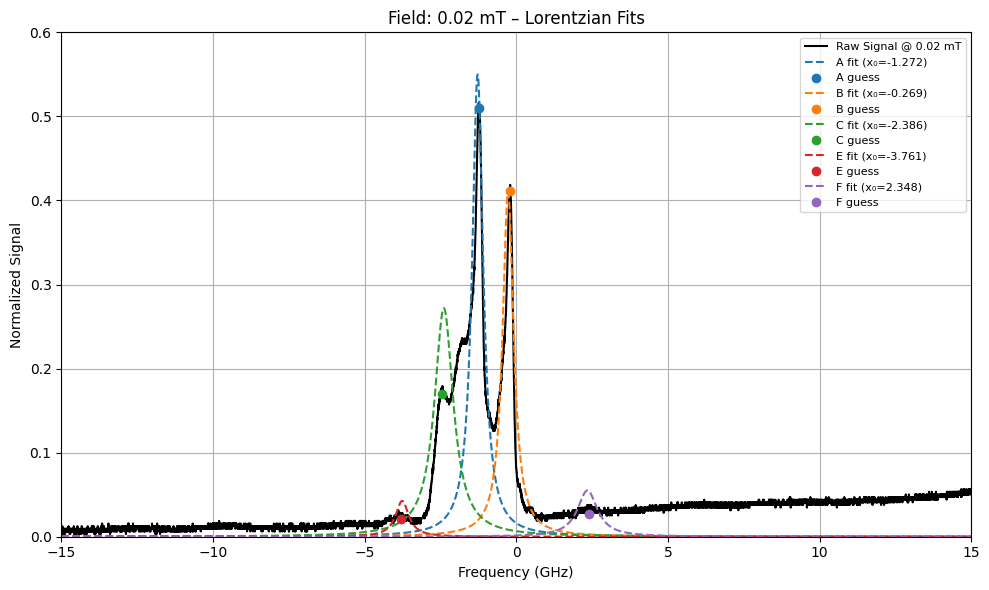

17.89666666666667

--- Fitting Lorentzians at B = 0.02 mT ---
  Trying A at B = 17.90 mT
    Guess: Gamma=0.4435, x0=-1.1945, scale=0.3558
    Bounds: [[np.float64(0.00798339061), np.float64(2.3480357747471006), np.float64(0.008643142)]], [[np.float64(0.798339061), np.float64(2.4480357747471), np.float64(0.069145136)]]
  Trying B at B = 17.90 mT
    Guess: Gamma=0.3992, x0=-0.2631, scale=0.2583
    Bounds: [[np.float64(0.004435217006201952), np.float64(-1.24449), np.float64(0.08894794097296672)]], [[np.float64(0.4435217006201952), np.float64(-1.14449), np.float64(0.7115835277837338)]]
  Trying C at B = 17.90 mT
    Guess: Gamma=0.8870, x0=-2.4364, scale=0.2332
    Bounds: [[np.float64(0.0039916953055817925), np.float64(-0.313094429), np.float64(0.06456442300415985)]], [[np.float64(0.3991695305581793), np.float64(-0.21309442900000003), np.float64(0.5165153840332788)]]
  Trying E at B = 17.90 mT
    Guess: Gamma=0.4435, x0=-3.7226, scale=0.0141
    Bounds: [[np.float64(0.00887043401), np

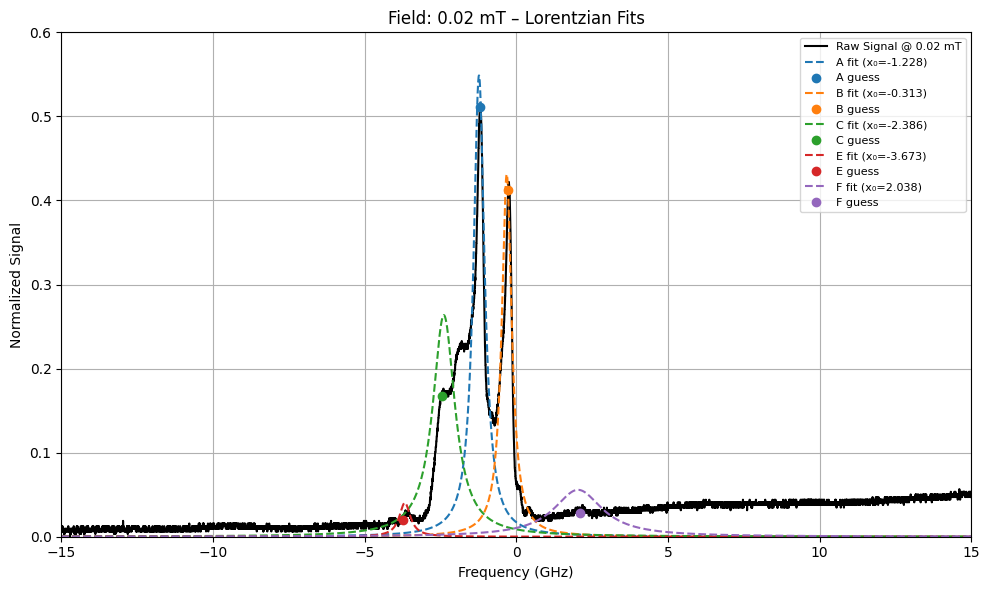

16.380000000000003

--- Fitting Lorentzians at B = 0.02 mT ---
  Trying A at B = 16.38 mT
    Guess: Gamma=0.3548, x0=-1.1501, scale=0.2839
    Bounds: [[np.float64(0.019514954827288666), np.float64(2.037570584), np.float64(0.021369414)]], [[np.float64(1.9514954827288664), np.float64(2.1375705839999997), np.float64(0.170955312)]]
  Trying B at B = 16.38 mT
    Guess: Gamma=0.3548, x0=-0.3074, scale=0.2321
    Bounds: [[np.float64(0.003548173604961562), np.float64(-1.20013783), np.float64(0.07096911495378855)]], [[np.float64(0.3548173604961562), np.float64(-1.10013783), np.float64(0.5677529196303084)]]
  Trying C at B = 16.38 mT
    Guess: Gamma=0.7983, x0=-2.3476, scale=0.2082
    Bounds: [[np.float64(0.003548173604961562), np.float64(-0.357446599), np.float64(0.05803112655431782)]], [[np.float64(0.3548173604961562), np.float64(-0.257446599), np.float64(0.4642490124345426)]]
  Trying E at B = 16.38 mT
    Guess: Gamma=0.4435, x0=-3.3677, scale=0.0179
    Bounds: [[np.float64(0.00798339

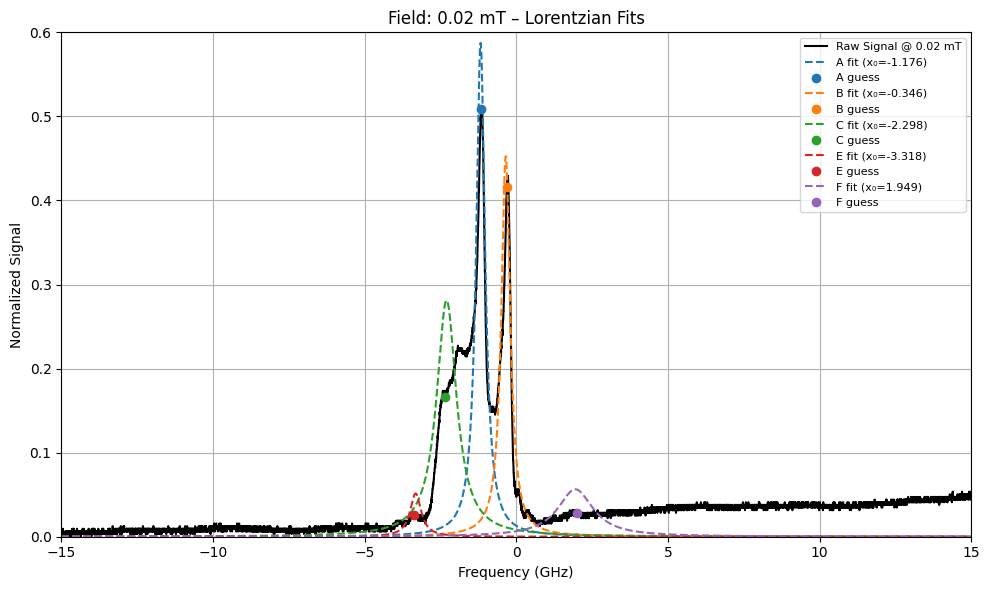

14.863333333333337

--- Fitting Lorentzians at B = 0.01 mT ---
  Trying A at B = 14.86 mT
    Guess: Gamma=0.3992, x0=-1.1945, scale=0.2508
    Bounds: [[np.float64(0.01419269441984632), np.float64(1.9488662441889208), np.float64(0.01573061475)]], [[np.float64(1.419269441984632), np.float64(2.048866244188921), np.float64(0.125844918)]]
  Trying B at B = 14.86 mT
    Guess: Gamma=0.3548, x0=-0.3518, scale=0.2301
    Bounds: [[np.float64(0.003991695305581757), np.float64(-1.24449), np.float64(0.06268905574294957)]], [[np.float64(0.3991695305581757), np.float64(-1.14449), np.float64(0.5015124459435966)]]
  Trying C at B = 14.86 mT
    Guess: Gamma=1.0645, x0=-1.9041, scale=0.3769
    Bounds: [[np.float64(0.003548173604961562), np.float64(-0.401798769), np.float64(0.05752421586837525)]], [[np.float64(0.3548173604961562), np.float64(-0.301798769), np.float64(0.460193726947002)]]
  Trying D at B = 14.86 mT
    Guess: Gamma=0.9314, x0=-1.9041, scale=0.3298
    Bounds: [[np.float64(0.010644520

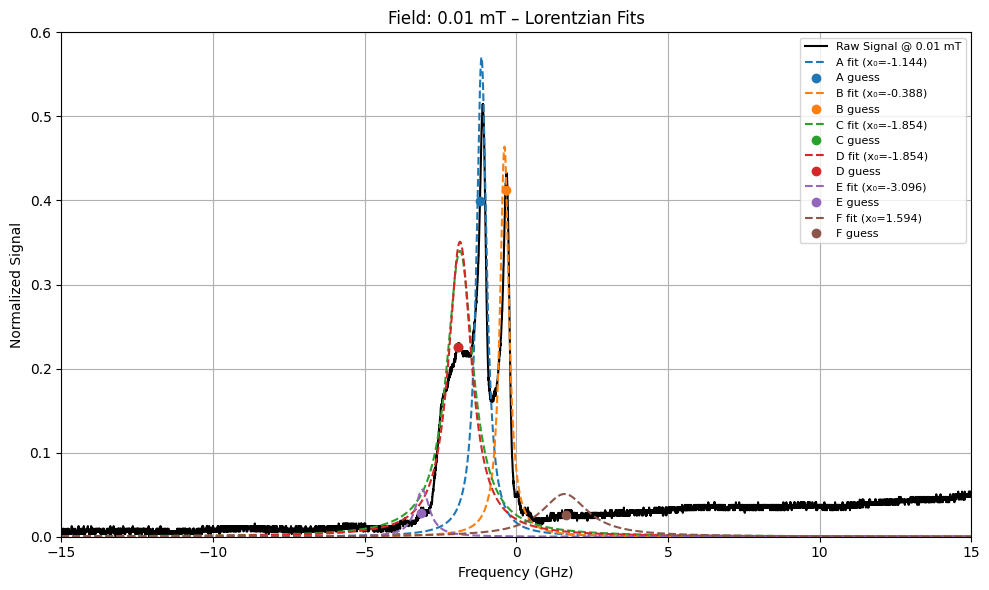

13.346666666666668

--- Fitting Lorentzians at B = 0.01 mT ---
  Trying A at B = 13.35 mT
    Guess: Gamma=0.3992, x0=-1.1058, scale=0.2972
    Bounds: [[np.float64(0.018627911426048274), np.float64(1.5940488836927649), np.float64(0.018594386)]], [[np.float64(1.8627911426048271), np.float64(1.694048883692765), np.float64(0.148755088)]]
  Trying B at B = 13.35 mT
    Guess: Gamma=0.2661, x0=-0.3962, scale=0.1705
    Bounds: [[np.float64(0.003991695305581757), np.float64(-1.15578566), np.float64(0.07429642983650198)]], [[np.float64(0.3991695305581757), np.float64(-1.05578566), np.float64(0.5943714386920158)]]
  Trying C at B = 13.35 mT
    Guess: Gamma=0.8870, x0=-1.9485, scale=0.3087
    Bounds: [[np.float64(0.002661130203721171), np.float64(-0.44615093899999997), np.float64(0.042621904472717624)]], [[np.float64(0.2661130203721171), np.float64(-0.346150939), np.float64(0.340975235781741)]]
  Trying D at B = 13.35 mT
    Guess: Gamma=1.0645, x0=-1.9485, scale=0.3704
    Bounds: [[np.floa

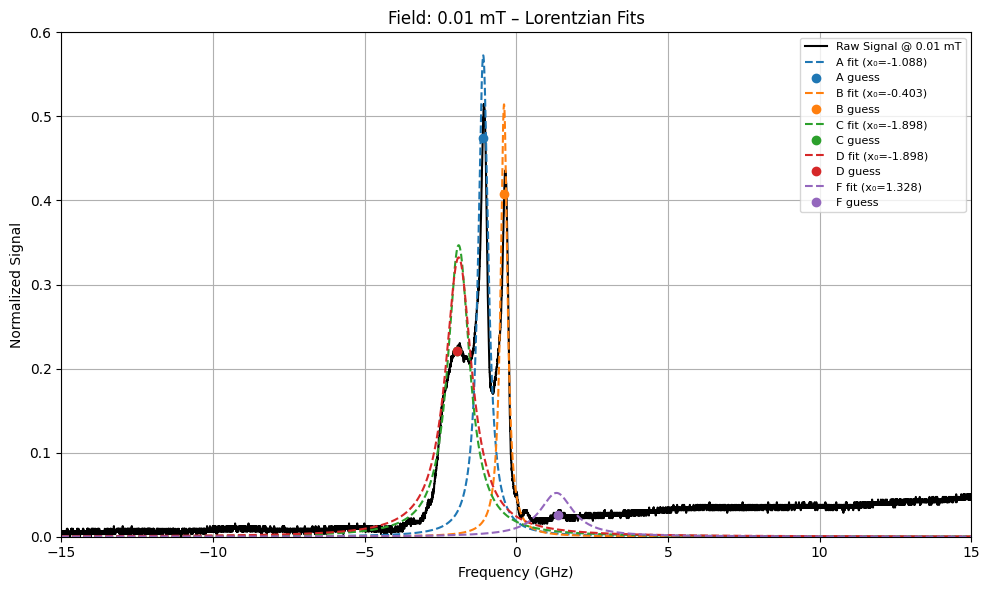

11.83

--- Fitting Lorentzians at B = 0.01 mT ---
  Trying A at B = 11.83 mT
    Guess: Gamma=0.3548, x0=-1.0614, scale=0.2672
    Bounds: [[np.float64(0.013305651018605893), np.float64(1.3279358633206442), np.float64(0.013612313267930725)]], [[np.float64(1.3305651018605893), np.float64(1.4279358633206443), np.float64(0.1088985061434458)]]
  Trying B at B = 11.83 mT
    Guess: Gamma=0.4435, x0=-0.3962, scale=0.3034
    Bounds: [[np.float64(0.003548173604961562), np.float64(-1.11143349), np.float64(0.0667985751034034)]], [[np.float64(0.3548173604961562), np.float64(-1.01143349), np.float64(0.5343886008272272)]]
  Trying C at B = 11.83 mT
    Guess: Gamma=0.8427, x0=-2.0815, scale=0.3006
    Bounds: [[np.float64(0.004435217006201952), np.float64(-0.44615093899999997), np.float64(0.07586218934426403)]], [[np.float64(0.4435217006201952), np.float64(-0.346150939), np.float64(0.6068975147541122)]]
  Trying D at B = 11.83 mT
    Guess: Gamma=0.9757, x0=-2.0372, scale=0.3522
    Bounds: [[np.f

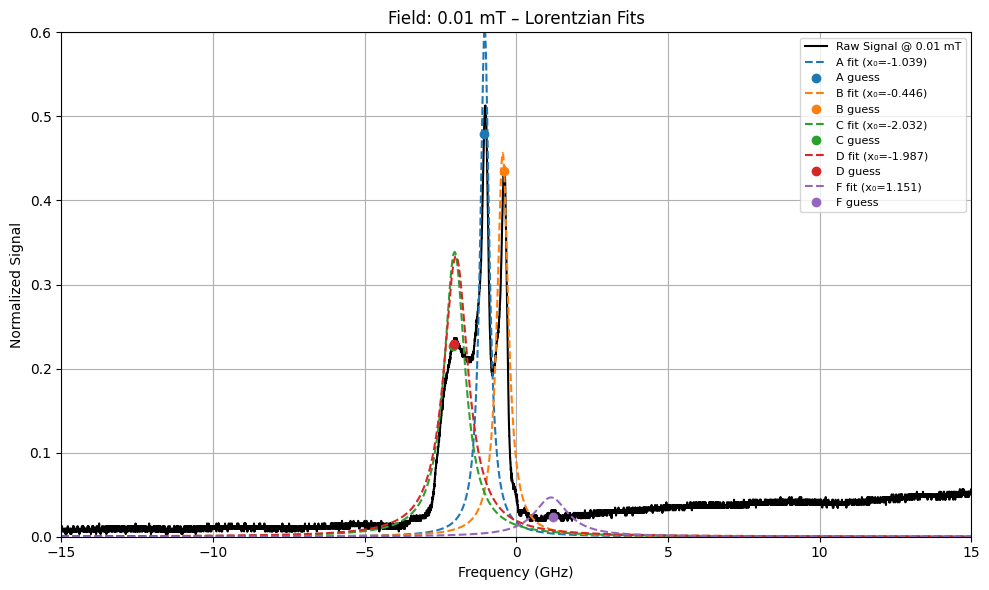

10.313333333333334

--- Fitting Lorentzians at B = 0.01 mT ---
  Trying A at B = 10.31 mT
    Guess: Gamma=0.4879, x0=-1.0171, scale=0.3721
    Bounds: [[np.float64(0.013749172719226124), np.float64(1.1505271830725659), np.float64(0.0126115055)]], [[np.float64(1.3749172719226124), np.float64(1.250527183072566), np.float64(0.100892044)]]
  Trying B at B = 10.31 mT
    Guess: Gamma=0.4879, x0=-0.4849, scale=0.3047
    Bounds: [[np.float64(0.004878738706822184), np.float64(-1.06708132), np.float64(0.0930141471937439)]], [[np.float64(0.4878738706822183), np.float64(-0.9670813199999999), np.float64(0.7441131775499512)]]
  Trying C at B = 10.31 mT
    Guess: Gamma=0.9314, x0=-2.0815, scale=0.3496
    Bounds: [[np.float64(0.004878738706822147), np.float64(-0.534855279), np.float64(0.07618271025938993)]], [[np.float64(0.4878738706822147), np.float64(-0.434855279), np.float64(0.6094616820751194)]]
  Trying D at B = 10.31 mT
    Guess: Gamma=0.7983, x0=-2.0815, scale=0.2997
    Bounds: [[np.floa

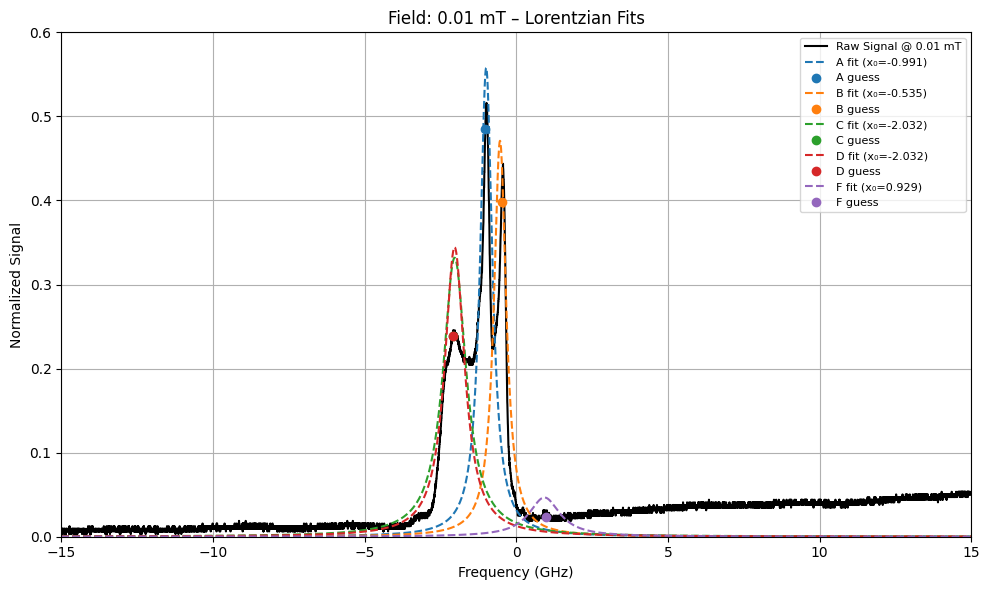

8.796666666666669

--- Fitting Lorentzians at B = 0.01 mT ---
  Trying A at B = 8.80 mT
    Guess: Gamma=0.3992, x0=-0.9727, scale=0.3122
    Bounds: [[np.float64(0.012418607617365539), np.float64(0.9287663327624683), np.float64(0.01138519925)]], [[np.float64(1.2418607617365538), np.float64(1.0287663327624683), np.float64(0.091081594)]]
  Trying B at B = 8.80 mT
    Guess: Gamma=0.3548, x0=-0.4849, scale=0.2444
    Bounds: [[np.float64(0.0039916953055817925), np.float64(-1.02272915), np.float64(0.07804062053761553)]], [[np.float64(0.3991695305581793), np.float64(-0.92272915), np.float64(0.6243249643009242)]]
  Trying C at B = 8.80 mT
    Guess: Gamma=0.8427, x0=-2.1259, scale=0.3306
    Bounds: [[np.float64(0.003548173604961562), np.float64(-0.534855279), np.float64(0.0611044195)]], [[np.float64(0.3548173604961562), np.float64(-0.434855279), np.float64(0.488835356)]]
  Trying D at B = 8.80 mT
    Guess: Gamma=1.0645, x0=-2.1259, scale=0.4176
    Bounds: [[np.float64(0.00842691231178378

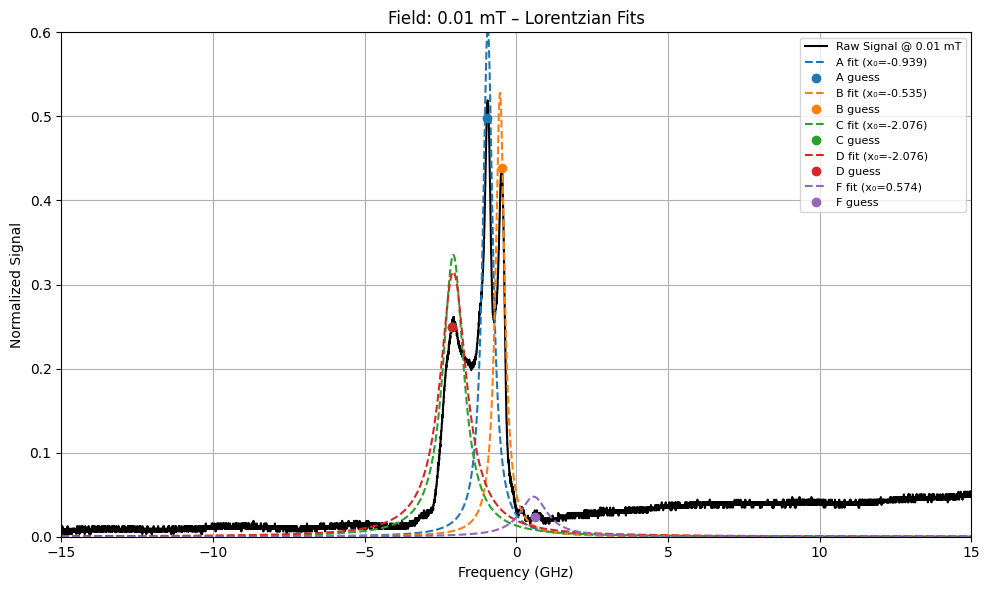

7.28

--- Fitting Lorentzians at B = 0.01 mT ---
  Trying A at B = 7.28 mT
    Guess: Gamma=0.4435, x0=-0.9727, scale=0.3057
    Bounds: [[np.float64(0.011088042515504918), np.float64(0.5739489722663087), np.float64(0.0103647550647848)]], [[np.float64(1.1088042515504917), np.float64(0.6739489722663088), np.float64(0.0829180405182784)]]
  Trying B at B = 7.28 mT
    Guess: Gamma=0.3105, x0=-0.5292, scale=0.2230
    Bounds: [[np.float64(0.004435217006201988), np.float64(-1.02272915), np.float64(0.07641880887290722)]], [[np.float64(0.4435217006201988), np.float64(-0.92272915), np.float64(0.6113504709832578)]]
  Trying C at B = 7.28 mT
    Guess: Gamma=1.0201, x0=-2.0372, scale=0.4073
    Bounds: [[np.float64(0.003104651904341367), np.float64(-0.5792074490000001), np.float64(0.055742796801360524)]], [[np.float64(0.3104651904341367), np.float64(-0.47920744900000006), np.float64(0.4459423744108842)]]
  Trying D at B = 7.28 mT
    Guess: Gamma=1.0645, x0=-2.0815, scale=0.4217
    Bounds: [[np

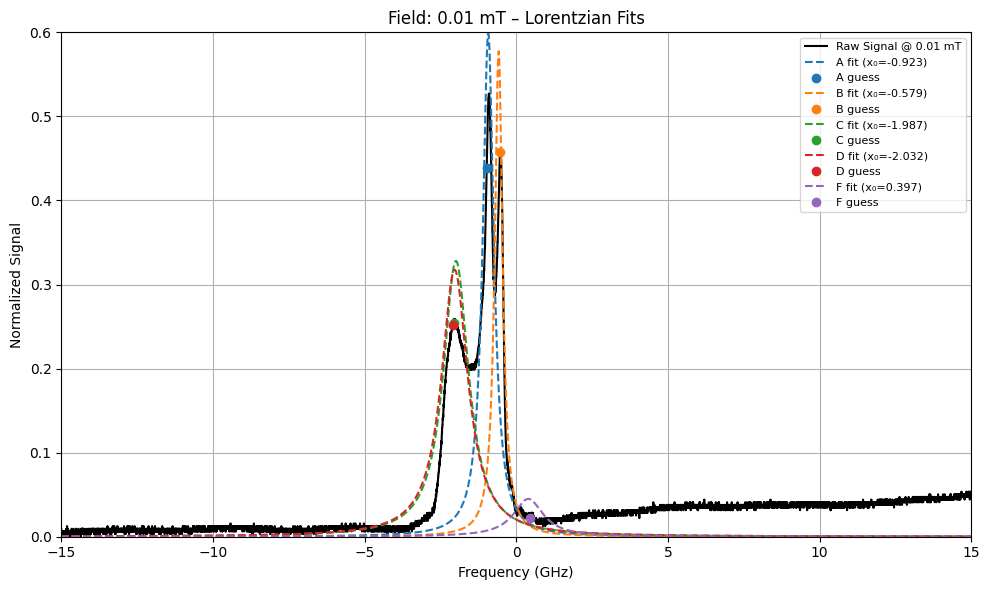

5.763333333333334

--- Fitting Lorentzians at B = 0.01 mT ---
  Trying A at B = 5.76 mT
    Guess: Gamma=0.3548, x0=-0.9284, scale=0.2528
    Bounds: [[np.float64(0.011975085916745344), np.float64(0.3965402920182306), np.float64(0.0105722875)]], [[np.float64(1.1975085916745345), np.float64(0.4965402920182306), np.float64(0.0845783)]]
  Trying B at B = 5.76 mT
    Guess: Gamma=0.3548, x0=-0.6179, scale=0.2299
    Bounds: [[np.float64(0.003548173604961597), np.float64(-0.9783769800000001), np.float64(0.06319308902416315)]], [[np.float64(0.3548173604961597), np.float64(-0.87837698), np.float64(0.5055447121933052)]]
  Trying C at B = 5.76 mT
    Guess: Gamma=0.9314, x0=-2.1259, scale=0.3695
    Bounds: [[np.float64(0.003548173604961562), np.float64(-0.667911789), np.float64(0.05746261053281292)]], [[np.float64(0.3548173604961562), np.float64(-0.567911789), np.float64(0.4597008842625034)]]
  Trying D at B = 5.76 mT
    Guess: Gamma=1.1975, x0=-2.0372, scale=0.4851
    Bounds: [[np.float64(0

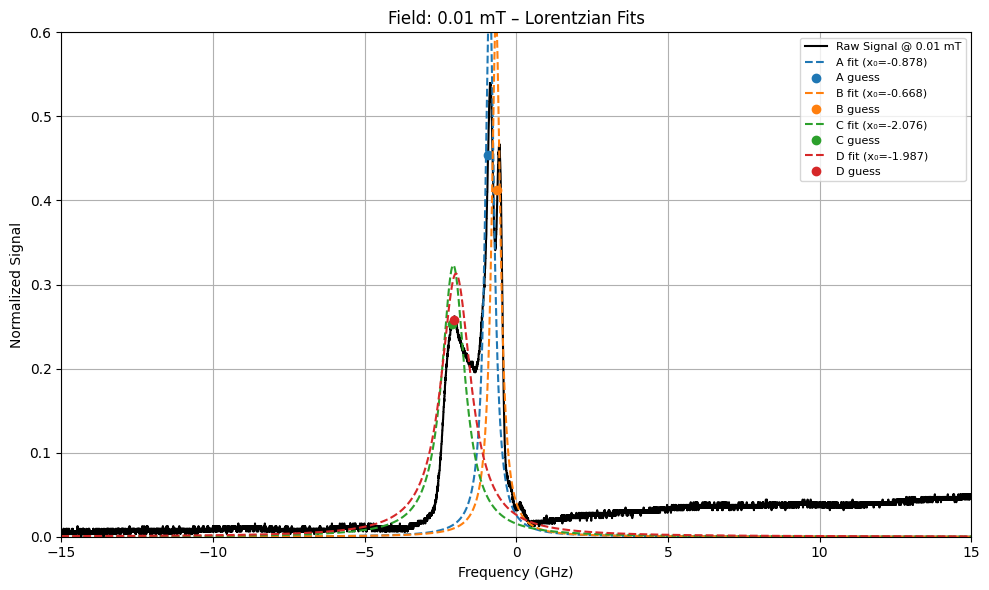

4.246666666666667

--- Fitting Lorentzians at B = 0.00 mT ---
  Trying A at B = 4.25 mT
    Guess: Gamma=0.3105, x0=-0.8397, scale=0.2652
    Bounds: [[np.float64(0.011975085916745308), np.float64(-2.0871812309999997), np.float64(0.121272200233245)]], [[np.float64(1.1975085916745307), np.float64(-1.9871812309999999), np.float64(0.97017760186596)]]
  Trying B at B = 4.25 mT
    Guess: Gamma=0.3548, x0=-0.6179, scale=0.2658
    Bounds: [[np.float64(0.0031046519043414025), np.float64(-0.88967264), np.float64(0.06630375817063765)]], [[np.float64(0.3104651904341402), np.float64(-0.7896726399999999), np.float64(0.5304300653651012)]]
  Trying C at B = 4.25 mT
    Guess: Gamma=0.9314, x0=-2.0815, scale=0.3767
    Bounds: [[np.float64(0.003548173604961562), np.float64(-0.667911789), np.float64(0.06643907871619953)]], [[np.float64(0.3548173604961562), np.float64(-0.567911789), np.float64(0.5315126297295962)]]
  Trying D at B = 4.25 mT
    Guess: Gamma=1.1088, x0=-2.1702, scale=0.4348
    Bounds:

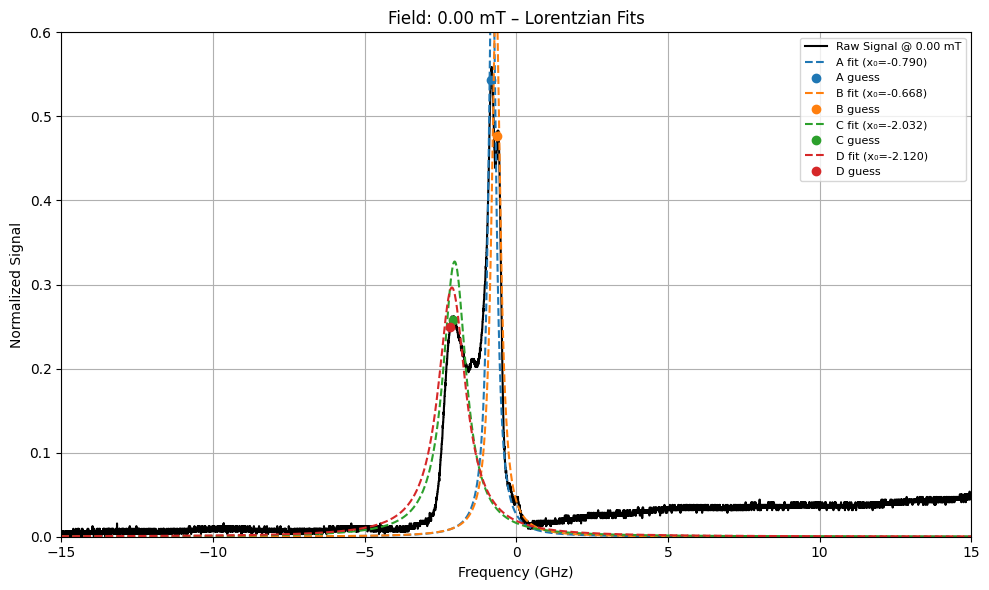

2.7300000000000004

--- Fitting Lorentzians at B = 0.00 mT ---
  Trying A at B = 2.73 mT
    Guess: Gamma=0.5322, x0=-0.8397, scale=0.4261
    Bounds: [[np.float64(0.011088042515504918), np.float64(-2.2202377419999997), np.float64(0.10869188102353942)]], [[np.float64(1.1088042515504917), np.float64(-2.120237742), np.float64(0.8695350481883154)]]
  Trying B at B = 2.73 mT
    Guess: Gamma=0.6209, x0=-0.7510, scale=0.5569
    Bounds: [[np.float64(0.005322260407442379), np.float64(-0.88967264), np.float64(0.10653536157223452)]], [[np.float64(0.5322260407442378), np.float64(-0.7896726399999999), np.float64(0.8522828925778761)]]
  Trying C at B = 2.73 mT
    Guess: Gamma=0.9314, x0=-2.2589, scale=0.3294
    Bounds: [[np.float64(0.006209303808682769), np.float64(-0.8009683000000001), np.float64(0.1392131539238353)]], [[np.float64(0.6209303808682769), np.float64(-0.7009683), np.float64(1.1137052313906823)]]
  Trying D at B = 2.73 mT
    Guess: Gamma=1.0201, x0=-2.2589, scale=0.3608
    Bounds

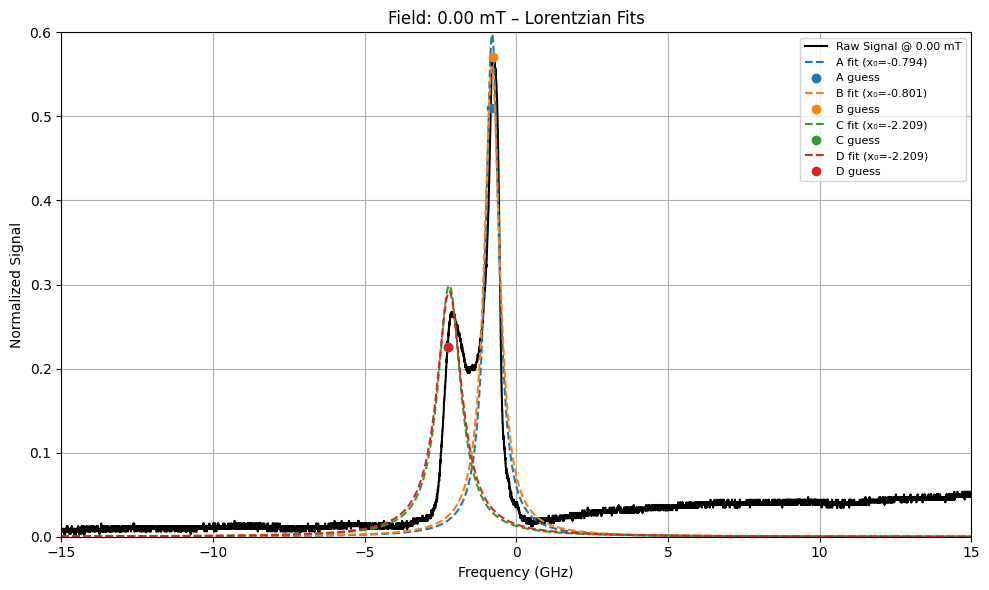

1.2133333333333334

--- Fitting Lorentzians at B = 0.00 mT ---
  Trying A at B = 1.21 mT
    Guess: Gamma=0.5322, x0=-0.7066, scale=0.4776
    Bounds: [[np.float64(0.010200999114264527), np.float64(-2.3089420819999997), np.float64(0.09019850984207264)]], [[np.float64(1.0200999114264526), np.float64(-2.208942082), np.float64(0.7215880787365812)]]
  Trying B at B = 1.21 mT
    Guess: Gamma=0.5766, x0=-0.7953, scale=0.4958
    Bounds: [[np.float64(0.005322260407442379), np.float64(-0.75661613), np.float64(0.11941060225)]], [[np.float64(0.5322260407442378), np.float64(-0.65661613), np.float64(0.955284818)]]
  Trying C at B = 1.21 mT
    Guess: Gamma=0.9757, x0=-2.1259, scale=0.4114
    Bounds: [[np.float64(0.005765782108062574), np.float64(-0.84532047), np.float64(0.12394430246546195)]], [[np.float64(0.5765782108062574), np.float64(-0.7453204699999999), np.float64(0.9915544197236956)]]
  Trying D at B = 1.21 mT
    Guess: Gamma=0.9757, x0=-2.1259, scale=0.4114
    Bounds: [[np.float64(0.00

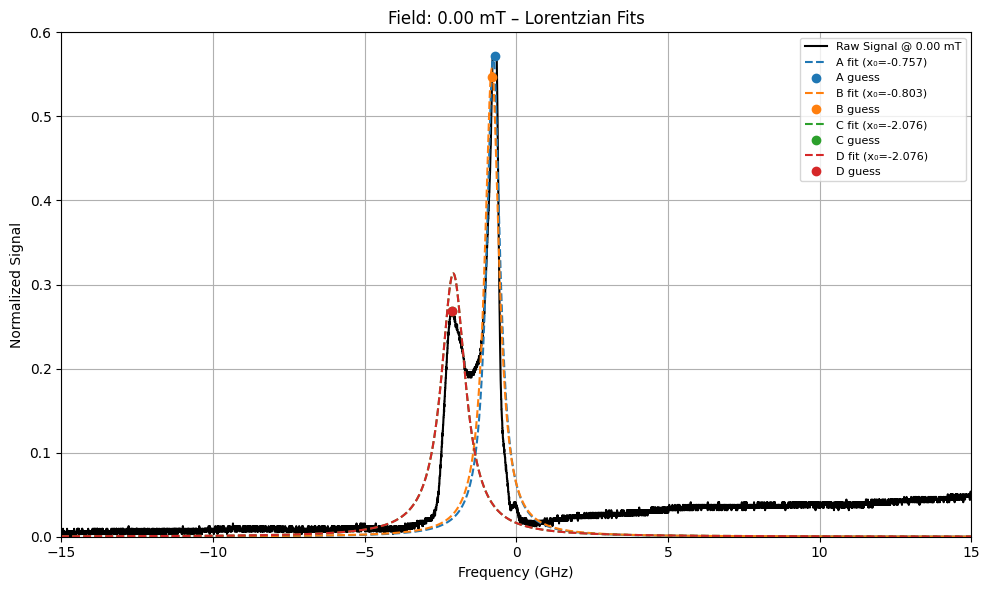

In [75]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import numpy as np

# --- Lorentzian function ---
def lorentzian(x, Gamma, x0, scale):
    return scale * (1 / np.pi) * (Gamma / 2) / ((x - x0)**2 + (Gamma / 2)**2)

# --- Storage dictionary ---
fit_results = {peak: [] for peak in peak_data.keys()}  # A–F

# --- Loop over magnetic fields from peak_data["A"] ---
for B_target_mT in peak_data["A"]["b_field"]:
    print(B_target_mT)
    # Match B field exactly with raw data (converted to mT)
    idx = np.where(np.isclose(fields*1000, B_target_mT, atol=1e-3))[0]
    if len(idx) == 0:
        print(f"Field {B_target_mT:.2f} mT not found in raw data.")
        continue
    raw_idx = idx[0]
    raw_signal = signals[raw_idx]
    B_matched = fields[raw_idx]  # For consistent units

    print(f"\n--- Fitting Lorentzians at B = {B_matched:.2f} mT ---")

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(freq_axis_GHz, raw_signal, color='black', label=f"Raw Signal @ {B_matched:.2f} mT")

    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    peak_color_idx = 0

    # --- Loop over each peak A–F ---
    for peak_label, pdata in peak_data.items():
        b_fields = pdata["b_field"]
        freqs = pdata["freq"]
        gammas = pdata["linewidth"]
        scales = pdata["scale"]

        # Find match at this field
        match_idx = np.where(np.isclose(b_fields, B_target_mT, atol=1e-3))[0]
        if len(match_idx) == 0:
            continue  # Skip if no match

        for idx in match_idx:
            Gamma_0 = gammas[idx]
            x0_0 = freqs[idx]
            scale_0 = scales[idx]
            guess = [Gamma_0, x0_0, scale_0]

            print(f"  Trying {peak_label} at B = {B_target_mT:.2f} mT")
            print(f"    Guess: Gamma={Gamma_0:.4f}, x0={x0_0:.4f}, scale={scale_0:.4f}")
            print(f"    Bounds: [{lower_bounds}], [{upper_bounds}]")


            # Use guess-centered bounds (± reasonable factor)
            lower_bounds = [Gamma_0 * 0.01, x0_0 - 0.05, scale_0 * 0.1]
            upper_bounds = [Gamma_0 * 1, x0_0 + 0.05, scale_0 * 2]


            try:
                popt, _ = curve_fit(
                    lorentzian,
                    freq_axis_GHz,
                    raw_signal,
                    p0=guess,
                    bounds=(lower_bounds, upper_bounds),
                    maxfev=10000
                )
                Gamma_fit, x0_fit, scale_fit = popt

                # Plot Lorentzian fit
                L = lorentzian(freq_axis_GHz, *popt)
                ax.plot(freq_axis_GHz, L, '--', color=colors[peak_color_idx % 10],
                        label=f"{peak_label} fit (x₀={x0_fit:.3f})")

                # Plot marker at guessed x₀
                y0_guess = lorentzian(x0_0, *guess)
                ax.plot(x0_0, y0_guess, 'o', color=colors[peak_color_idx % 10], label=f"{peak_label} guess")

                # Store result
                fit_results[peak_label].append({
                    "B Field (mT)": B_matched,
                    "Gamma (GHz)": Gamma_fit,
                    "Center Frequency (GHz)": x0_fit,
                    "Scale": scale_fit
                })

            except (RuntimeError, ValueError) as e:
                print(f"Fit failed for {peak_label} at B = {B_matched:.2f} mT: {e}")
                continue

        peak_color_idx += 1

    # --- Plot formatting ---
    ax.set_xlim([-15, 15])
    ax.set_ylim([0, 0.6])
    ax.set_title(f"Field: {B_matched:.2f} mT – Lorentzian Fits")
    ax.set_xlabel("Frequency (GHz)")
    ax.set_ylabel("Normalized Signal")
    ax.legend(fontsize=8)
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# --- Convert to DataFrames ---
fit_dataframes = {
    peak: pd.DataFrame(entries) for peak, entries in fit_results.items() if entries
}


In [77]:
# Define your save directory
save_dir = "data_optics/fitted_lorentzian_data_2025-03-25_IH_site1"
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Loop through and save each DataFrame
for peak_label, df in fit_dataframes.items():
    save_path = os.path.join(save_dir, f"lorentzian_fits_peak_{peak_label}.csv")
    df.to_csv(save_path, index=False)
    print(f"Saved: {save_path}")

Saved: data_optics/fitted_lorentzian_data_2025-03-25_IH_site1/lorentzian_fits_peak_A.csv
Saved: data_optics/fitted_lorentzian_data_2025-03-25_IH_site1/lorentzian_fits_peak_B.csv
Saved: data_optics/fitted_lorentzian_data_2025-03-25_IH_site1/lorentzian_fits_peak_C.csv
Saved: data_optics/fitted_lorentzian_data_2025-03-25_IH_site1/lorentzian_fits_peak_D.csv
Saved: data_optics/fitted_lorentzian_data_2025-03-25_IH_site1/lorentzian_fits_peak_E.csv
Saved: data_optics/fitted_lorentzian_data_2025-03-25_IH_site1/lorentzian_fits_peak_F.csv


340.97197407468127
401.5162062228336
Peak A:
  Slope = 1.535357 MHz/mT ± 0.642721
  Total broadening (ΔΓ) = 60.544232 MHz
  Over = 39.433333 mT
  Slope of linewidth: 0.001535 GHz/mT
  d(ΔB)/dB = 0.008786 ± 0.003678 (unitless)
  Field inhomogeneity: 0.8786% ± 0.3736%

465.7632481763913
631.3363038713734
Peak B:
  Slope = 4.198810 MHz/mT ± 0.637529
  Total broadening (ΔΓ) = 165.573056 MHz
  Over = 39.433333 mT
  Slope of linewidth: 0.004199 GHz/mT
  d(ΔB)/dB = 0.024027 ± 0.003648 (unitless)
  Field inhomogeneity: 2.4027% ± 0.4069%

614.2423552240031
588.19425534631
Peak C:
  Slope = -0.660560 MHz/mT ± 0.912027
  Total broadening (ΔΓ) = -26.048100 MHz
  Over = 39.433333 mT
  Slope of linewidth: -0.000661 GHz/mT
  d(ΔB)/dB = -0.003780 ± 0.005219 (unitless)
  Field inhomogeneity: -0.3780% ± -0.5227%

1321.1783992019618
1445.0828742958606
Peak D:
  Slope = 3.142125 MHz/mT ± 1.301899
  Total broadening (ΔΓ) = 123.904475 MHz
  Over = 39.433333 mT
  Slope of linewidth: 0.003142 GHz/mT
  d(ΔB)/d

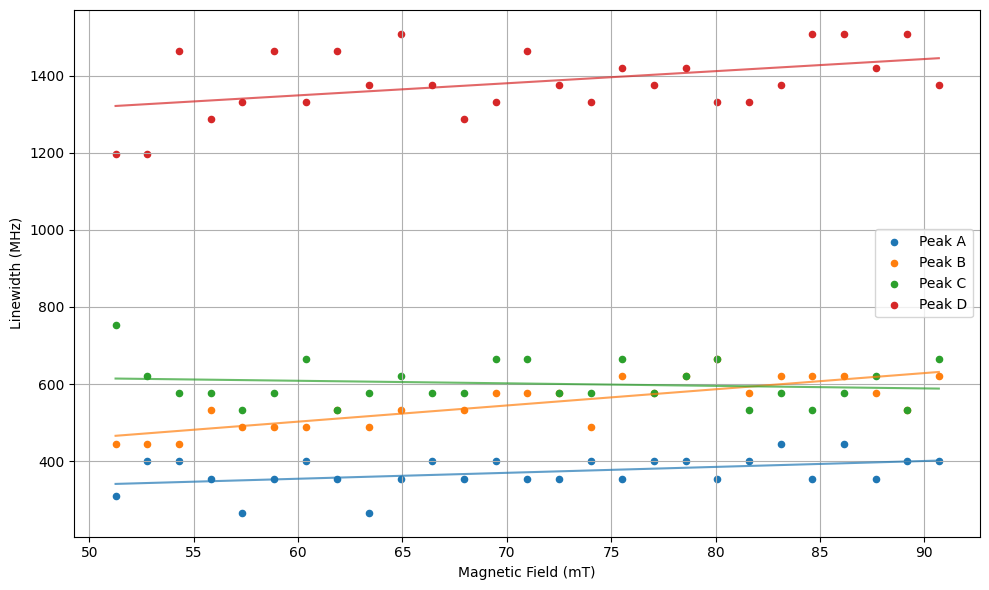

In [135]:
import matplotlib.pyplot as plt
import numpy as np

# Define magnetic field threshold (in mT)
exclude_below = 50  # exclude B-fields ≤ 45 mT

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Define distinct colors for each peak
colors = plt.cm.tab10(range(len(fit_dataframes)))

# ---- Physical constants ----
muB = 9.27400968e-24  # Bohr Magneton (J/T)
hbar = 1.054571817E-34  # Reduced Planck constant (Js)
h = 2 * np.pi * hbar
scale = (h / muB) * 1e9 / 1e-3  # Converts GHz/mT to unitless g_eff

g_eff = 12.485805793985856  # unitless

# Input B-field relative uncertainty (0.27/3.6)
B_relative_uncertainty = 0.27 / 3.6

# Plot linewidth vs B-field and apply linear fits
for i, (peak_label, df) in enumerate(fit_dataframes.items()):
    if "B Field (mT)" not in df.columns or "Gamma (GHz)" not in df.columns:
        continue

    if peak_label in ["E", "F"]:
        continue

    # Extract data
    B_fields = df["B Field (mT)"].values
    gammas = df["Gamma (GHz)"].values
    gammas = gammas * 1000
    B_fields = B_fields * 1000

    # Mask out data with B-field ≤ 45 mT
    mask = B_fields > exclude_below
    B_fit = B_fields[mask]
    gamma_fit = gammas[mask]

    # Linear fit
    if len(B_fit) > 1:
        # Sort B_fit and gamma_fit by B-field
        sort_indices = np.argsort(B_fit)
        B_fit_sorted = B_fit[sort_indices]

        coeffs, cov = np.polyfit(B_fit, gamma_fit, 1, cov=True)
        slope, intercept = coeffs
        slope_err = np.sqrt(cov[0, 0])  # 1σ uncertainty in slope

        fit_line = np.poly1d(coeffs)(B_fit)

        # R² calculation
        residuals = gamma_fit - fit_line
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((gamma_fit - np.mean(gamma_fit))**2)
        r_squared = 1 - (ss_res / ss_tot)

        # Total broadening
        print(fit_line[-1])
        print(fit_line[0])
        total_broadening = fit_line[0] - fit_line[-1]
        field_range = np.max(B_fit) - np.min(B_fit)

        # Print results
        print(f"Peak {peak_label}:")
        print(f"  Slope = {slope:.6f} MHz/mT ± {slope_err:.6f}")
        print(f"  Total broadening (ΔΓ) = {total_broadening:.6f} MHz")
        print(f"  Over = {field_range:.6f} mT")

        # --- Slope of linewidth vs field (in GHz/mT) ---
        linewidth_slope = slope * 1e-3  # dΓ/dB in GHz/mT
        linewidth_slope_err = slope_err * 1e-3

        # --- Convert slope to Hz/T ---
        linewidth_slope_Hz_per_T = linewidth_slope * 1e9 / 1e-3  # Hz/T
        linewidth_slope_Hz_per_T_err = linewidth_slope_err * 1e9 / 1e-3

        # --- Compute d(delta_B)/dB ---
        dDeltaB_dB = (h * linewidth_slope_Hz_per_T) / (muB * g_eff)  # unitless
        dDeltaB_dB_err = (h * linewidth_slope_Hz_per_T_err) / (muB * g_eff)

        # --- Express as percentage ---
        percent_inhomogeneity_per_T = dDeltaB_dB * 100
        percent_inhomogeneity_per_T_err = dDeltaB_dB_err * 100

        percent_inhomogeneity_per_mT = dDeltaB_dB * 100 / 1e3
        percent_inhomogeneity_per_mT_err = dDeltaB_dB_err * 100 / 1e3

        # Include B-field measurement uncertainty
        total_percent_error = np.sqrt((dDeltaB_dB_err / dDeltaB_dB) ** 2 + B_relative_uncertainty ** 2)
        total_percent_uncertainty = percent_inhomogeneity_per_T * total_percent_error

        print(f"  Slope of linewidth: {linewidth_slope:.6f} GHz/mT")
        print(f"  d(ΔB)/dB = {dDeltaB_dB:.6f} ± {dDeltaB_dB_err:.6f} (unitless)")
        print(f"  Field inhomogeneity: {percent_inhomogeneity_per_T:.4f}% ± {total_percent_uncertainty:.4f}%\n")
        # print(f"  Field inhomogeneity per mT: {percent_inhomogeneity_per_mT:.6f}% ± {percent_inhomogeneity_per_mT_err:.6f}%\n")

        # Plot only masked data
        ax.scatter(B_fit, gamma_fit, label=f"Peak {peak_label}", color=colors[i], s=20)
        ax.plot(B_fit, fit_line, '-', color=colors[i], linewidth=1.5, alpha=0.7)

# Final plot formatting
ax.set_xlabel("Magnetic Field (mT)")
ax.set_ylabel("Linewidth (MHz)")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


In [128]:
# ---- Physical constants ----
muB = 9.27400968e-24  # Bohr Magneton (J/T)
hbar = 1.054571817E-34  # Reduced Planck constant (Js)
h = 2 * np.pi * hbar
scale = (h / muB) * 1e9 / 1e-3  # Converts GHz/mT to unitless g_eff


g_eff =12          # unitless

# --- Slope of linewidth vs field (in GHz/mT) ---
linewidth_slope = 1.535357e-3  # dΓ/dB in GHz/mT

# --- Convert slope to Hz/T ---
linewidth_slope_Hz_per_T = linewidth_slope * 1e9 / 1e-3  # Hz/T

# --- Compute d(delta_B)/dB ---
dDeltaB_dB = (h * linewidth_slope_Hz_per_T) / (muB * g_eff)  # unitless

# --- Express as percentage ---
percent_inhomogeneity_per_T = dDeltaB_dB * 100
percent_inhomogeneity_per_mT = dDeltaB_dB * 100 / 1e3  # per mT

print(f"Slope of linewidth: {linewidth_slope:.6f} GHz/mT")
print(f"d(ΔB)/dB = {dDeltaB_dB:.6f} (unitless)")
print(f"Field inhomogeneity per T: {percent_inhomogeneity_per_T:.4f}%")
print(f"Field inhomogeneity per mT: {percent_inhomogeneity_per_mT:.6f}%")



Slope of linewidth: 0.001535 GHz/mT
d(ΔB)/dB = 0.009141 (unitless)
Field inhomogeneity per T: 0.9141%
Field inhomogeneity per mT: 0.000914%
